<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
df = pd.read_csv('./housing.csv')

In [3]:
#open data description file
raw_file = ''
file = './data_description.txt'
with open(file, 'r') as f:
    raw_file = f.read()
    desc = [[float(row[i]) if row[i].isdigit() else row[i] for i in range(len(row))]
             for row in [line.split("\t") for line in raw_file.splitlines()]]
desc

[['MSSubClass: Identifies the type of dwelling involved in the sale.', ''],
 [''],
 ['        20', '1-STORY 1946 & NEWER ALL STYLES'],
 ['        30', '1-STORY 1945 & OLDER'],
 ['        40', '1-STORY W/FINISHED ATTIC ALL AGES'],
 ['        45', '1-1/2 STORY - UNFINISHED ALL AGES'],
 ['        50', '1-1/2 STORY FINISHED ALL AGES'],
 ['        60', '2-STORY 1946 & NEWER'],
 ['        70', '2-STORY 1945 & OLDER'],
 ['        75', '2-1/2 STORY ALL AGES'],
 ['        80', 'SPLIT OR MULTI-LEVEL'],
 ['        85', 'SPLIT FOYER'],
 ['        90', 'DUPLEX - ALL STYLES AND AGES'],
 ['       120', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'],
 ['       150', '1-1/2 STORY PUD - ALL AGES'],
 ['       160', '2-STORY PUD - 1946 & NEWER'],
 ['       180', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'],
 ['       190', '2 FAMILY CONVERSION - ALL STYLES AND AGES'],
 [''],
 ['MSZoning: Identifies the general zoning classification of the sale.'],
 ['', '', ''],
 ['       A', 'Agriculture'],
 ['  

Step 1: EDA

In [4]:
#remove non-residential sales
df = df[df['MSZoning'].isin(['A', 'C','I','C (all)'])==False]
#look into column data type and presence of missing cells
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [5]:
#null values in categorical variables represent houses without a certain feature, do not need to replace NA values.
#investigate null values for continuous variable LotFrontage, MasVnrArea
df[df['LotFrontage'].isnull()]#lot is present even though frontage area is not present. Replace LotFrontage with 0.
df['LotFrontage'].fillna(0, inplace=True)
df.loc[df['MasVnrArea'].isnull(), 'Id':'MasVnrArea']#MasVnrType should be unknown for these 8 houses. Drop them
df.dropna(subset=['MasVnrArea'], inplace=True)
df = df.drop('Id',axis=1) # drop Id column

In [6]:
#create cols of built/rennovation time difference to sale, so as to study plausible relationships
df['YearBuilt_tosale'] = df['YrSold']-df['YearBuilt']
df['YearRemodAdd_tosale'] = df['YrSold']-df['YearRemodAdd']
df['GarageYrBlt_tosale'] = df['YrSold']-df['GarageYrBlt']

In [7]:
#convert to objects: MSSubClass, YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold
df['MSSubClass'] = df['MSSubClass'].astype('O')
df['MoSold'] = df['MoSold'].astype('O')
df['YrSold'] = df['YrSold'].astype('O')

In [8]:
#get continuous and object columns
obj_col = []
cont_col = []
for c in df.columns:
    if df[c].dtype == 'O':
        obj_col.append(c)
    else:
        cont_col.append(c)
print 'No. of obj cols:',len(obj_col)
print 'No. of cont cols:',len(cont_col)
df_cont = df[cont_col]
df_obj = df[obj_col]

No. of obj cols: 46
No. of cont cols: 37


In [9]:
df_cont.iloc[:,:17].agg(['min','median','mean','max','std']) #check for negative values or extreme values

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
min        0.000000    1300.000000     1.000000     1.000000  1872.000000   
median    63.000000    9496.000000     6.000000     5.000000  1973.000000   
mean      57.551318   10514.252427     6.108183     5.585992  1971.442441   
max      313.000000  215245.000000    10.000000     9.000000  2010.000000   
std       34.702070   10020.693765     1.371142     1.107616    30.014081   

        YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
min      1950.000000     0.000000     0.000000     0.000000     0.000000   
median   1994.000000     0.000000   383.500000     0.000000   475.000000   
mean     1984.959778   104.404300   443.490291    47.130374   567.205964   
max      2010.000000  1600.000000  5644.000000  1474.000000  2336.000000   
std        20.559753   181.486539   455.618393   162.239256   442.806130   

        TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
min        0.000000   334.000000     0.000000       0.00000   334.000000   
median   992.000000  1088.000000     0.000000       0.00000  1466.000000   
mean    1057.826630  1163.419556   347.348128       5.56172  1516.329404   
max     6110.000000  4692.000000  2065.000000     572.00000  5642.000000   
std      438.627671   385.074042   436.938845      47.06125   525.306768   

        BsmtFullBath  BsmtHalfBath  
min         0.000000      0.000000  
median      0.000000      0.000000  
mean        0.425798      0.057559  
max         3.000000      2.000000  
std         0.519275      0.238871

In [10]:
df_cont.iloc[:,17:].agg(['min','median','mean','max','std']) #check for negative values or extreme values, -1 in YearRemodAdd_tosale

FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
min     0.000000  0.000000      0.000000       0.00000      2.000000   
median  2.000000  0.000000      3.000000       1.00000      6.000000   
mean    1.566574  0.383495      2.871012       1.04577      6.521498   
max     3.000000  2.000000      8.000000       3.00000     14.000000   
std     0.548867  0.503235      0.813662       0.21879      1.626002   

        Fireplaces  GarageYrBlt  GarageCars   GarageArea  WoodDeckSF  \
min       0.000000  1906.000000    0.000000     0.000000    0.000000   
median    1.000000  1980.000000    2.000000   478.000000    0.000000   
mean      0.615811  1978.495231    1.768377   472.771151   95.003467   
max       3.000000  2010.000000    4.000000  1418.000000  857.000000   
std       0.643744    24.592042    0.746325   212.987361  125.616473   

        OpenPorchSF  EnclosedPorch   3SsnPorch  ScreenPorch    PoolArea  \
min        0.000000       0.000000    0.000000     0.000000    0.000000   
median    25.000000       0.000000    0.000000     0.000000    0.000000   
mean      46.265603      21.517337    3.452150    15.180305    2.793343   
max      547.000000     552.000000  508.000000   480.000000  738.000000   
std       65.004272      60.807532   29.497376    56.036985   40.426271   

             MiscVal      SalePrice  YearBuilt_tosale  YearRemodAdd_tosale  \
min         0.000000   37900.000000          0.000000            -1.000000   
median      0.000000  163000.000000         35.000000            14.000000   
mean       43.606103  181350.757282         36.369626            22.852288   
max     15500.000000  755000.000000        136.000000            60.000000   
std       499.005429   79019.276227         30.056574            20.549454   

        GarageYrBlt_tosale  
min               0.000000  
median           28.000000  
mean             29.314747  
max             102.000000  
std              24.629411

In [11]:
#replace negative with 0 in dataframe
df.loc[df['YearRemodAdd_tosale']==-1,'YearRemodAdd_tosale']=0

No other negative values nor extreme values.

In [12]:
#for category occurrence in object columns
df_obj = df[obj_col]
for c in df_obj.columns:
    print df_obj[c].value_counts()
#may need to subsume datapoints <5% of dataframe len into others for credible sample size regression

20     530
60     296
50     140
120     86
30      67
160     63
70      59
80      58
90      52
190     29
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
RL    1146
RM     218
FV      62
RH      16
Name: MSZoning, dtype: int64
Pave    1438
Grvl       4
Name: Street, dtype: int64
Grvl    50
Pave    38
Name: Alley, dtype: int64
Reg    910
IR1    481
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1297
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64
AllPub    1441
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1038
Corner      260
CulDSac      93
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1367
Mod      62
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    149
OldTown    112
Edwards    100
Somerst     83
Gilbert     78
NridgHt     76
Sawyer      74
NWAmes      73
BrkSide     58
SawyerW     58
Crawfor     50
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      28
C

In [13]:
#replace categories in original dataframe with less than 0.05 of dataframe len with Others for credible sample size and limit no. of dummies
for col in df_obj.drop(['MoSold','YrSold'], axis=1).columns:
    otherls = []
    for i, e in df[col].value_counts().items():
        if e < 0.05*len(df):
            otherls.append(i)
    df.loc[df[col].isin(otherls), col] = 'Others'

In [14]:
df['SaleType'].value_counts()

WD        1256
New        119
Others      67
Name: SaleType, dtype: int64

Finished cleaning DataFrame. Select Fixed features for further EDA.

In [15]:
#investigate fixed features more thoroughly before doing regression
FF = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','TotalBsmtSF',
'1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
'TotRmsAbvGrd','Fireplaces','GarageFinish','GarageCars','GarageArea','PavedDrive','WoodDeckSF','OpenPorchSF',
'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence','MiscFeature','MiscVal','MoSold','YrSold','SaleType','SaleCondition',
'YearBuilt_tosale','YearRemodAdd_tosale','SalePrice']

In [16]:
len(FF)

48

In [17]:
df_ff = df[FF]
#split into object and continuous columns again
obj_col = []
cont_col = []
for c in df_ff.columns:
    if df_ff[c].dtype == 'O':
        obj_col.append(c)
    else:
        cont_col.append(c)
print 'No. of obj cols:',len(obj_col)
print 'No. of cont cols:',len(cont_col)
df_ff_obj = df_ff[obj_col]
df_ff_cont = df_ff[cont_col]

No. of obj cols: 22
No. of cont cols: 26


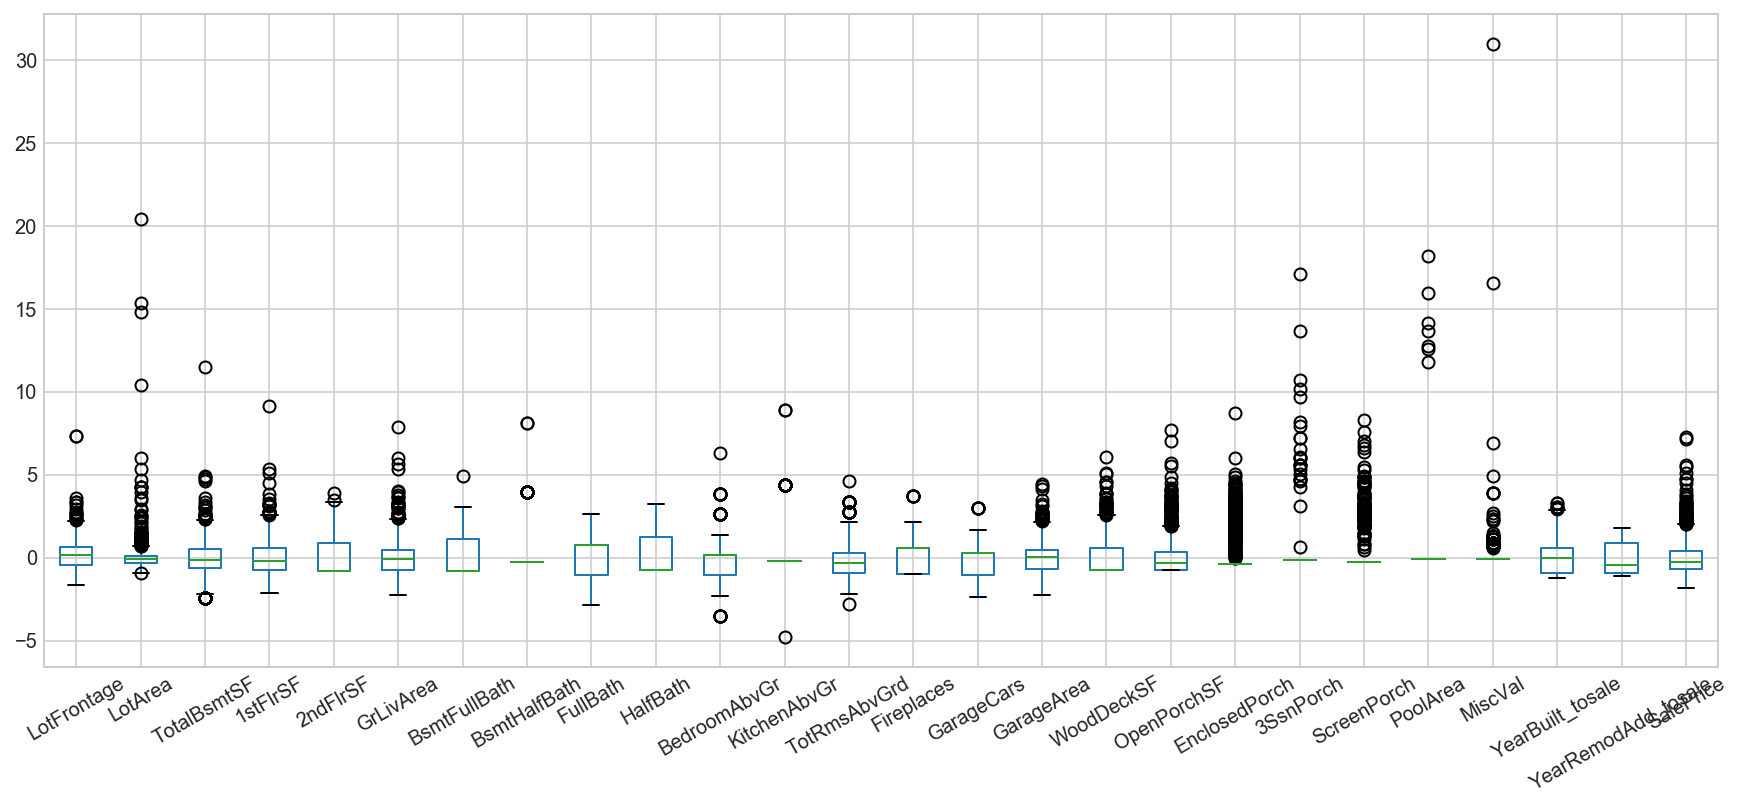

In [18]:
#standardizing continuous variables so as to have a better view of boxplot and distributions
from sklearn.preprocessing import StandardScaler
df_ff_conts = StandardScaler().fit_transform(df_ff_cont)
df_ff_conts = pd.DataFrame(df_ff_conts, columns = df_ff_cont.columns.values) 

ax = df_ff_conts.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
#looks like there are presence of lognormal distributions especially columns with areas and values

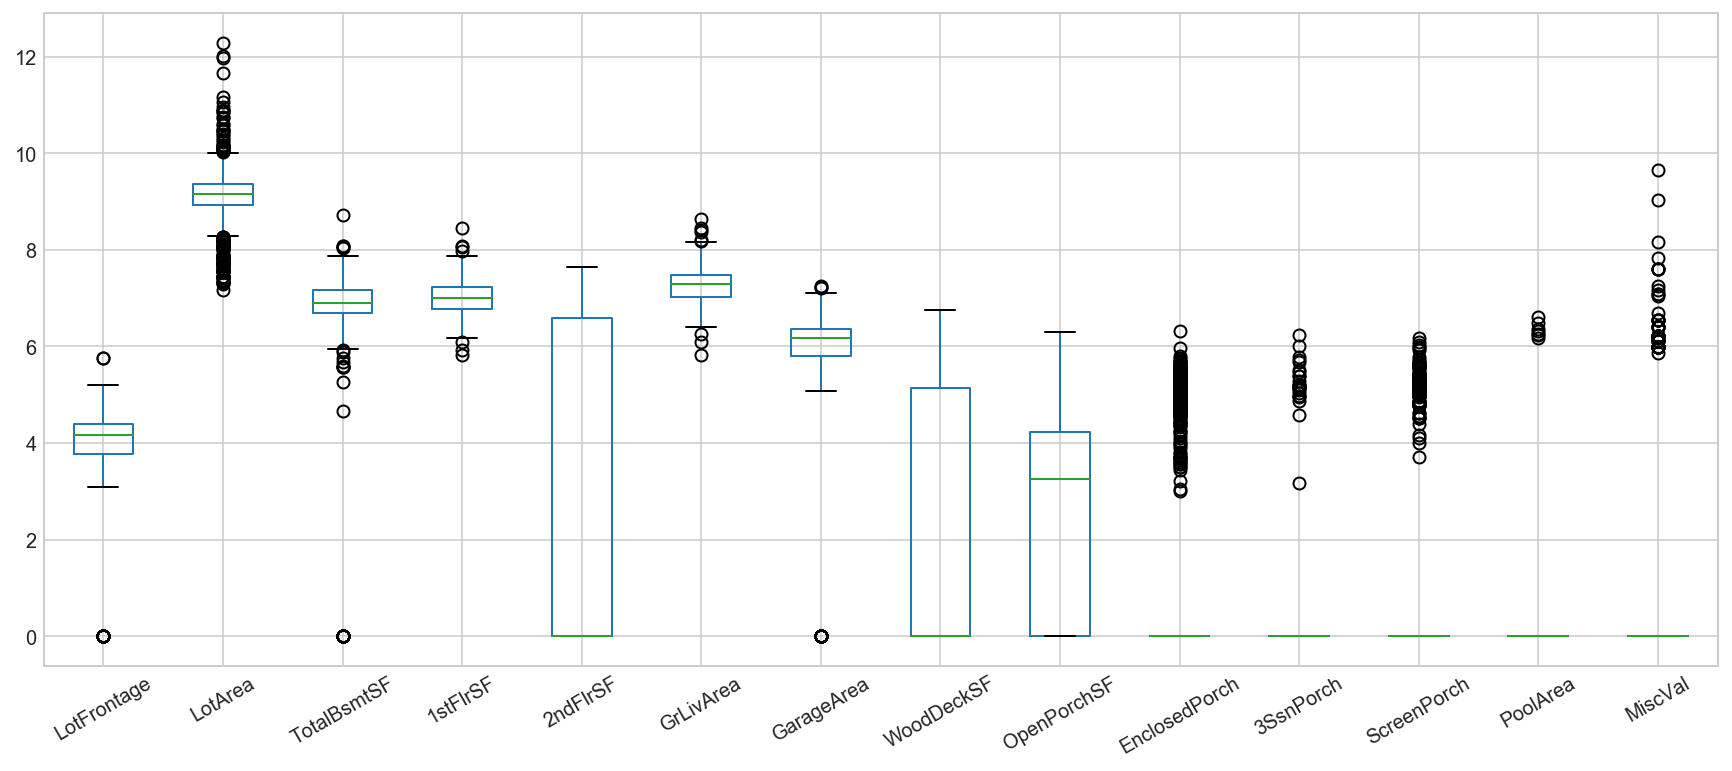

In [19]:
#log selected (area and value) columns of pre-standardized continuous variables, +1 to remove error from np.log(0)
log_df = np.log(df_ff_cont.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                                 'Fireplaces', 'GarageCars', 'YearBuilt_tosale','YearRemodAdd_tosale', 'SalePrice'], axis=1)
                +1)

ax = log_df.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

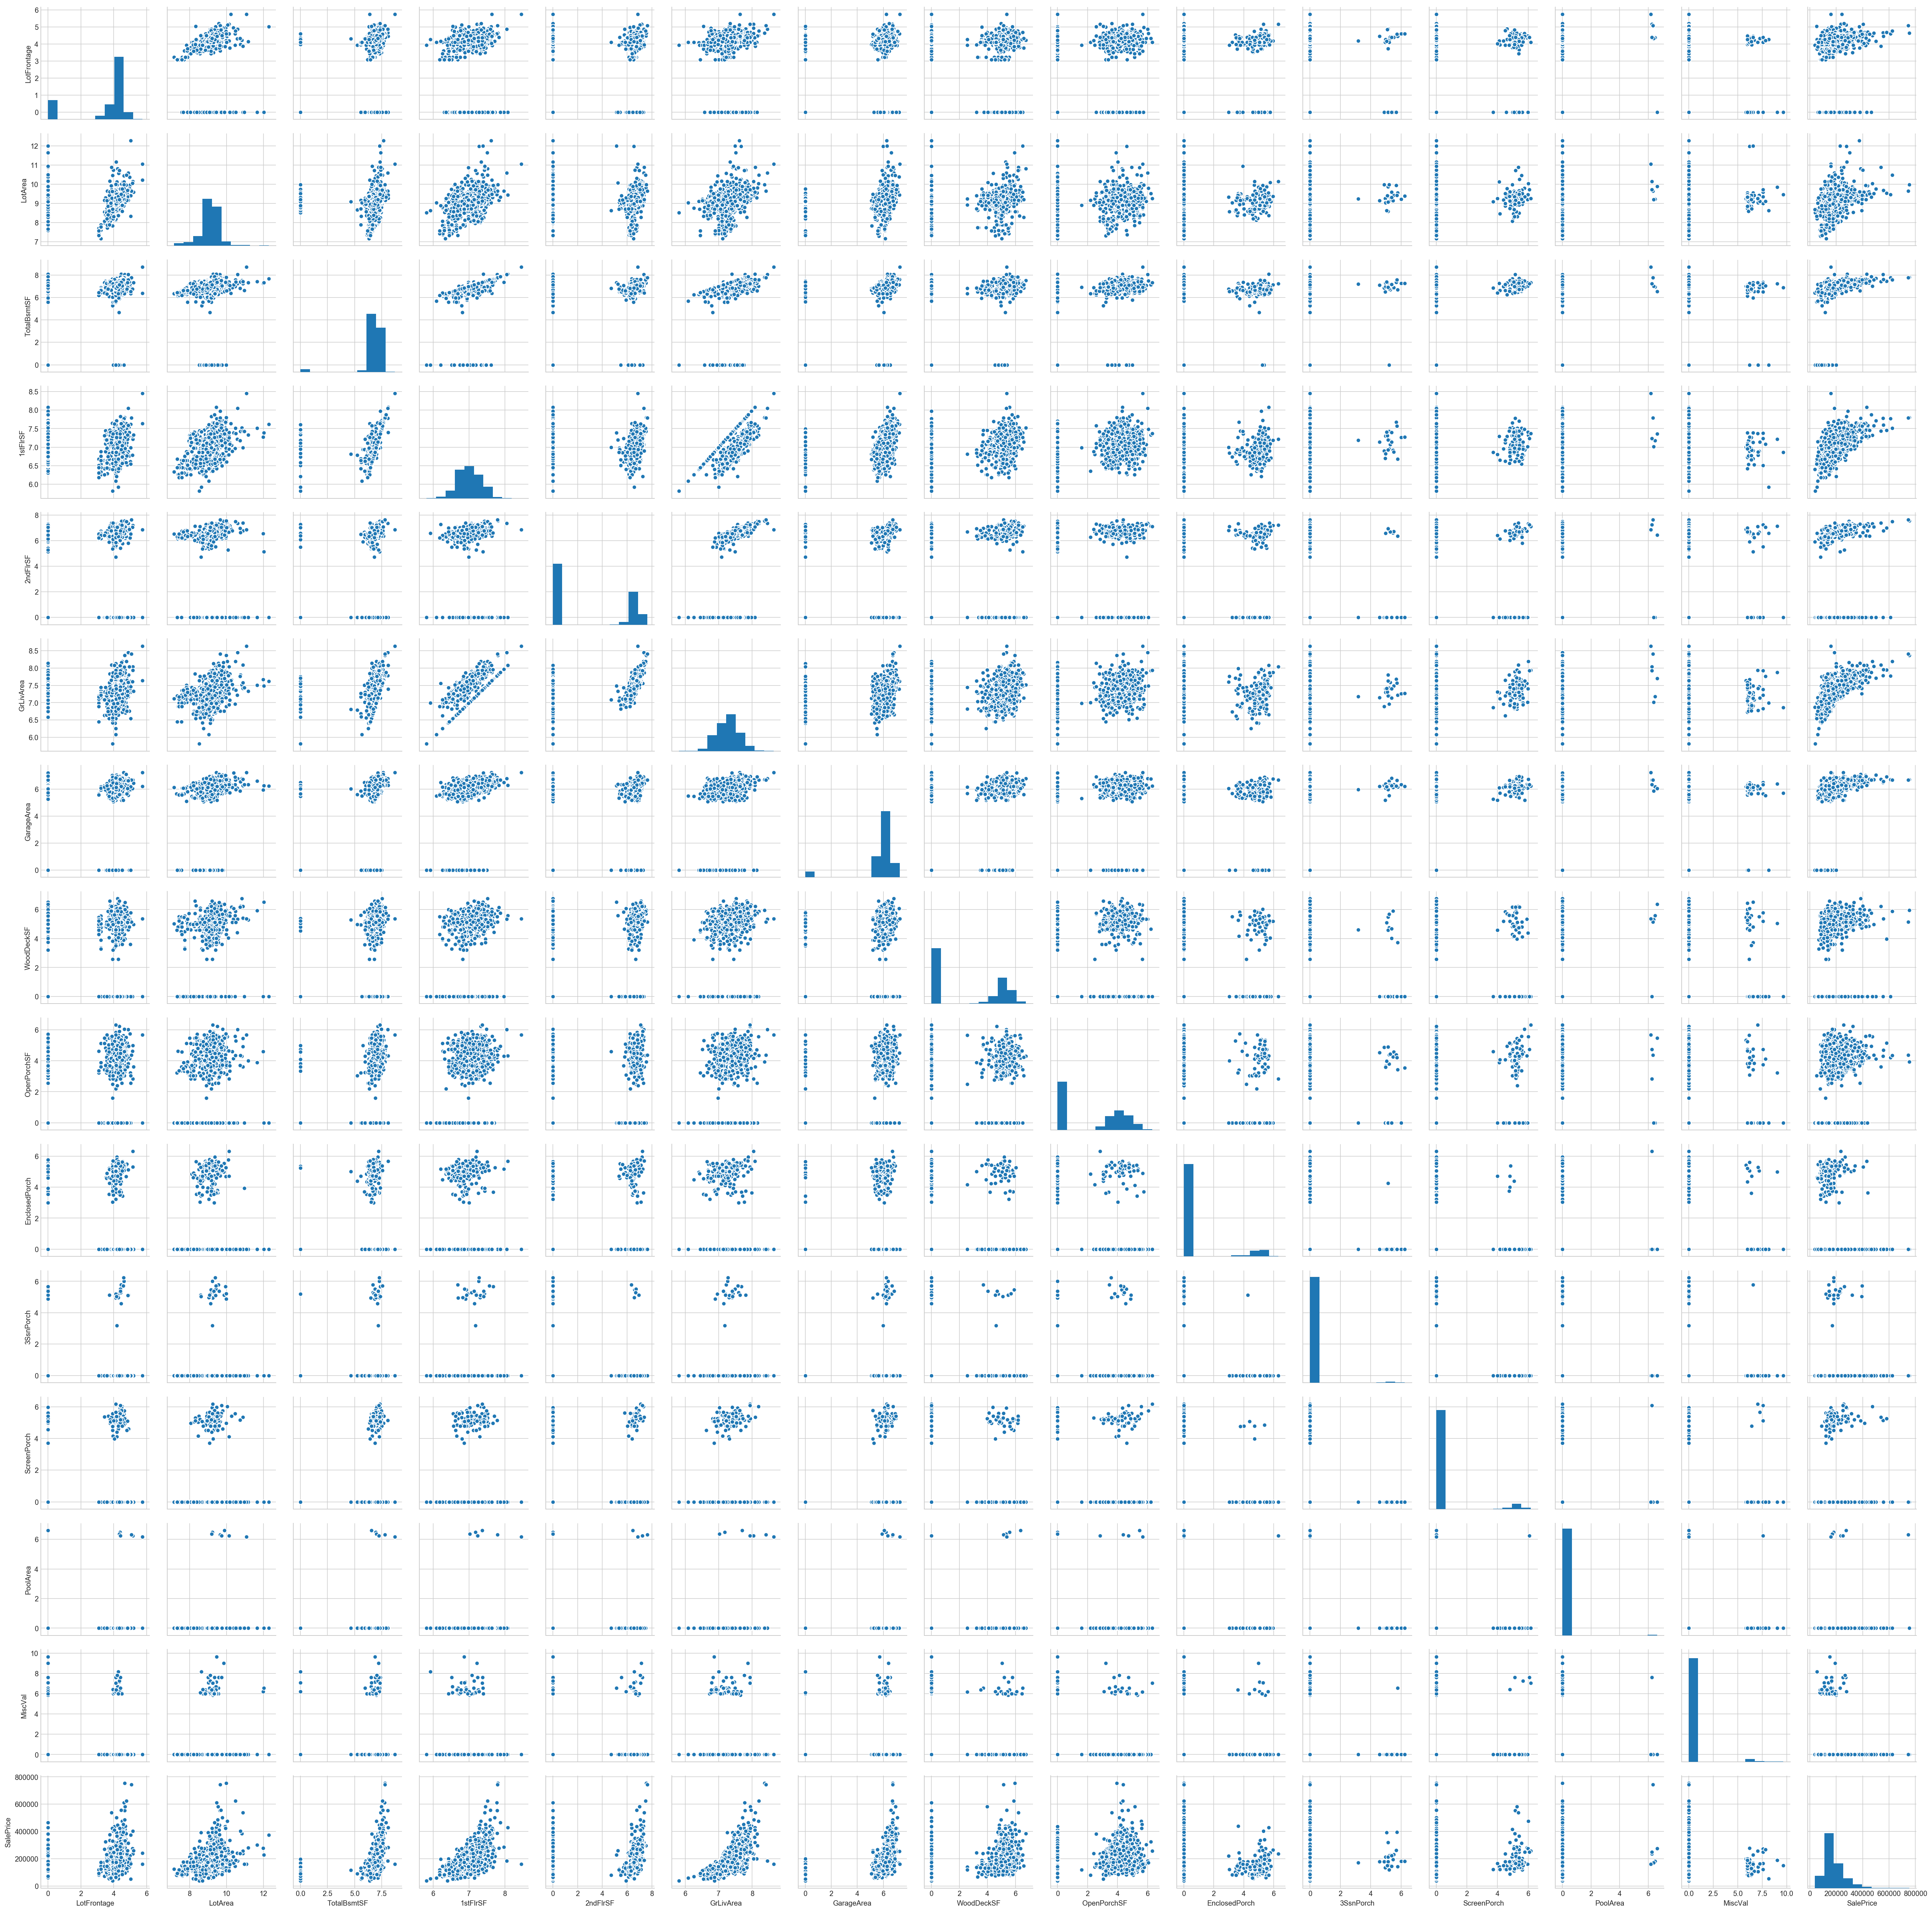

In [20]:
log_df['SalePrice'] = df['SalePrice']
sns.pairplot(log_df)
#positive correlation looks good for the lognormalized variables on SalePrice (last row)

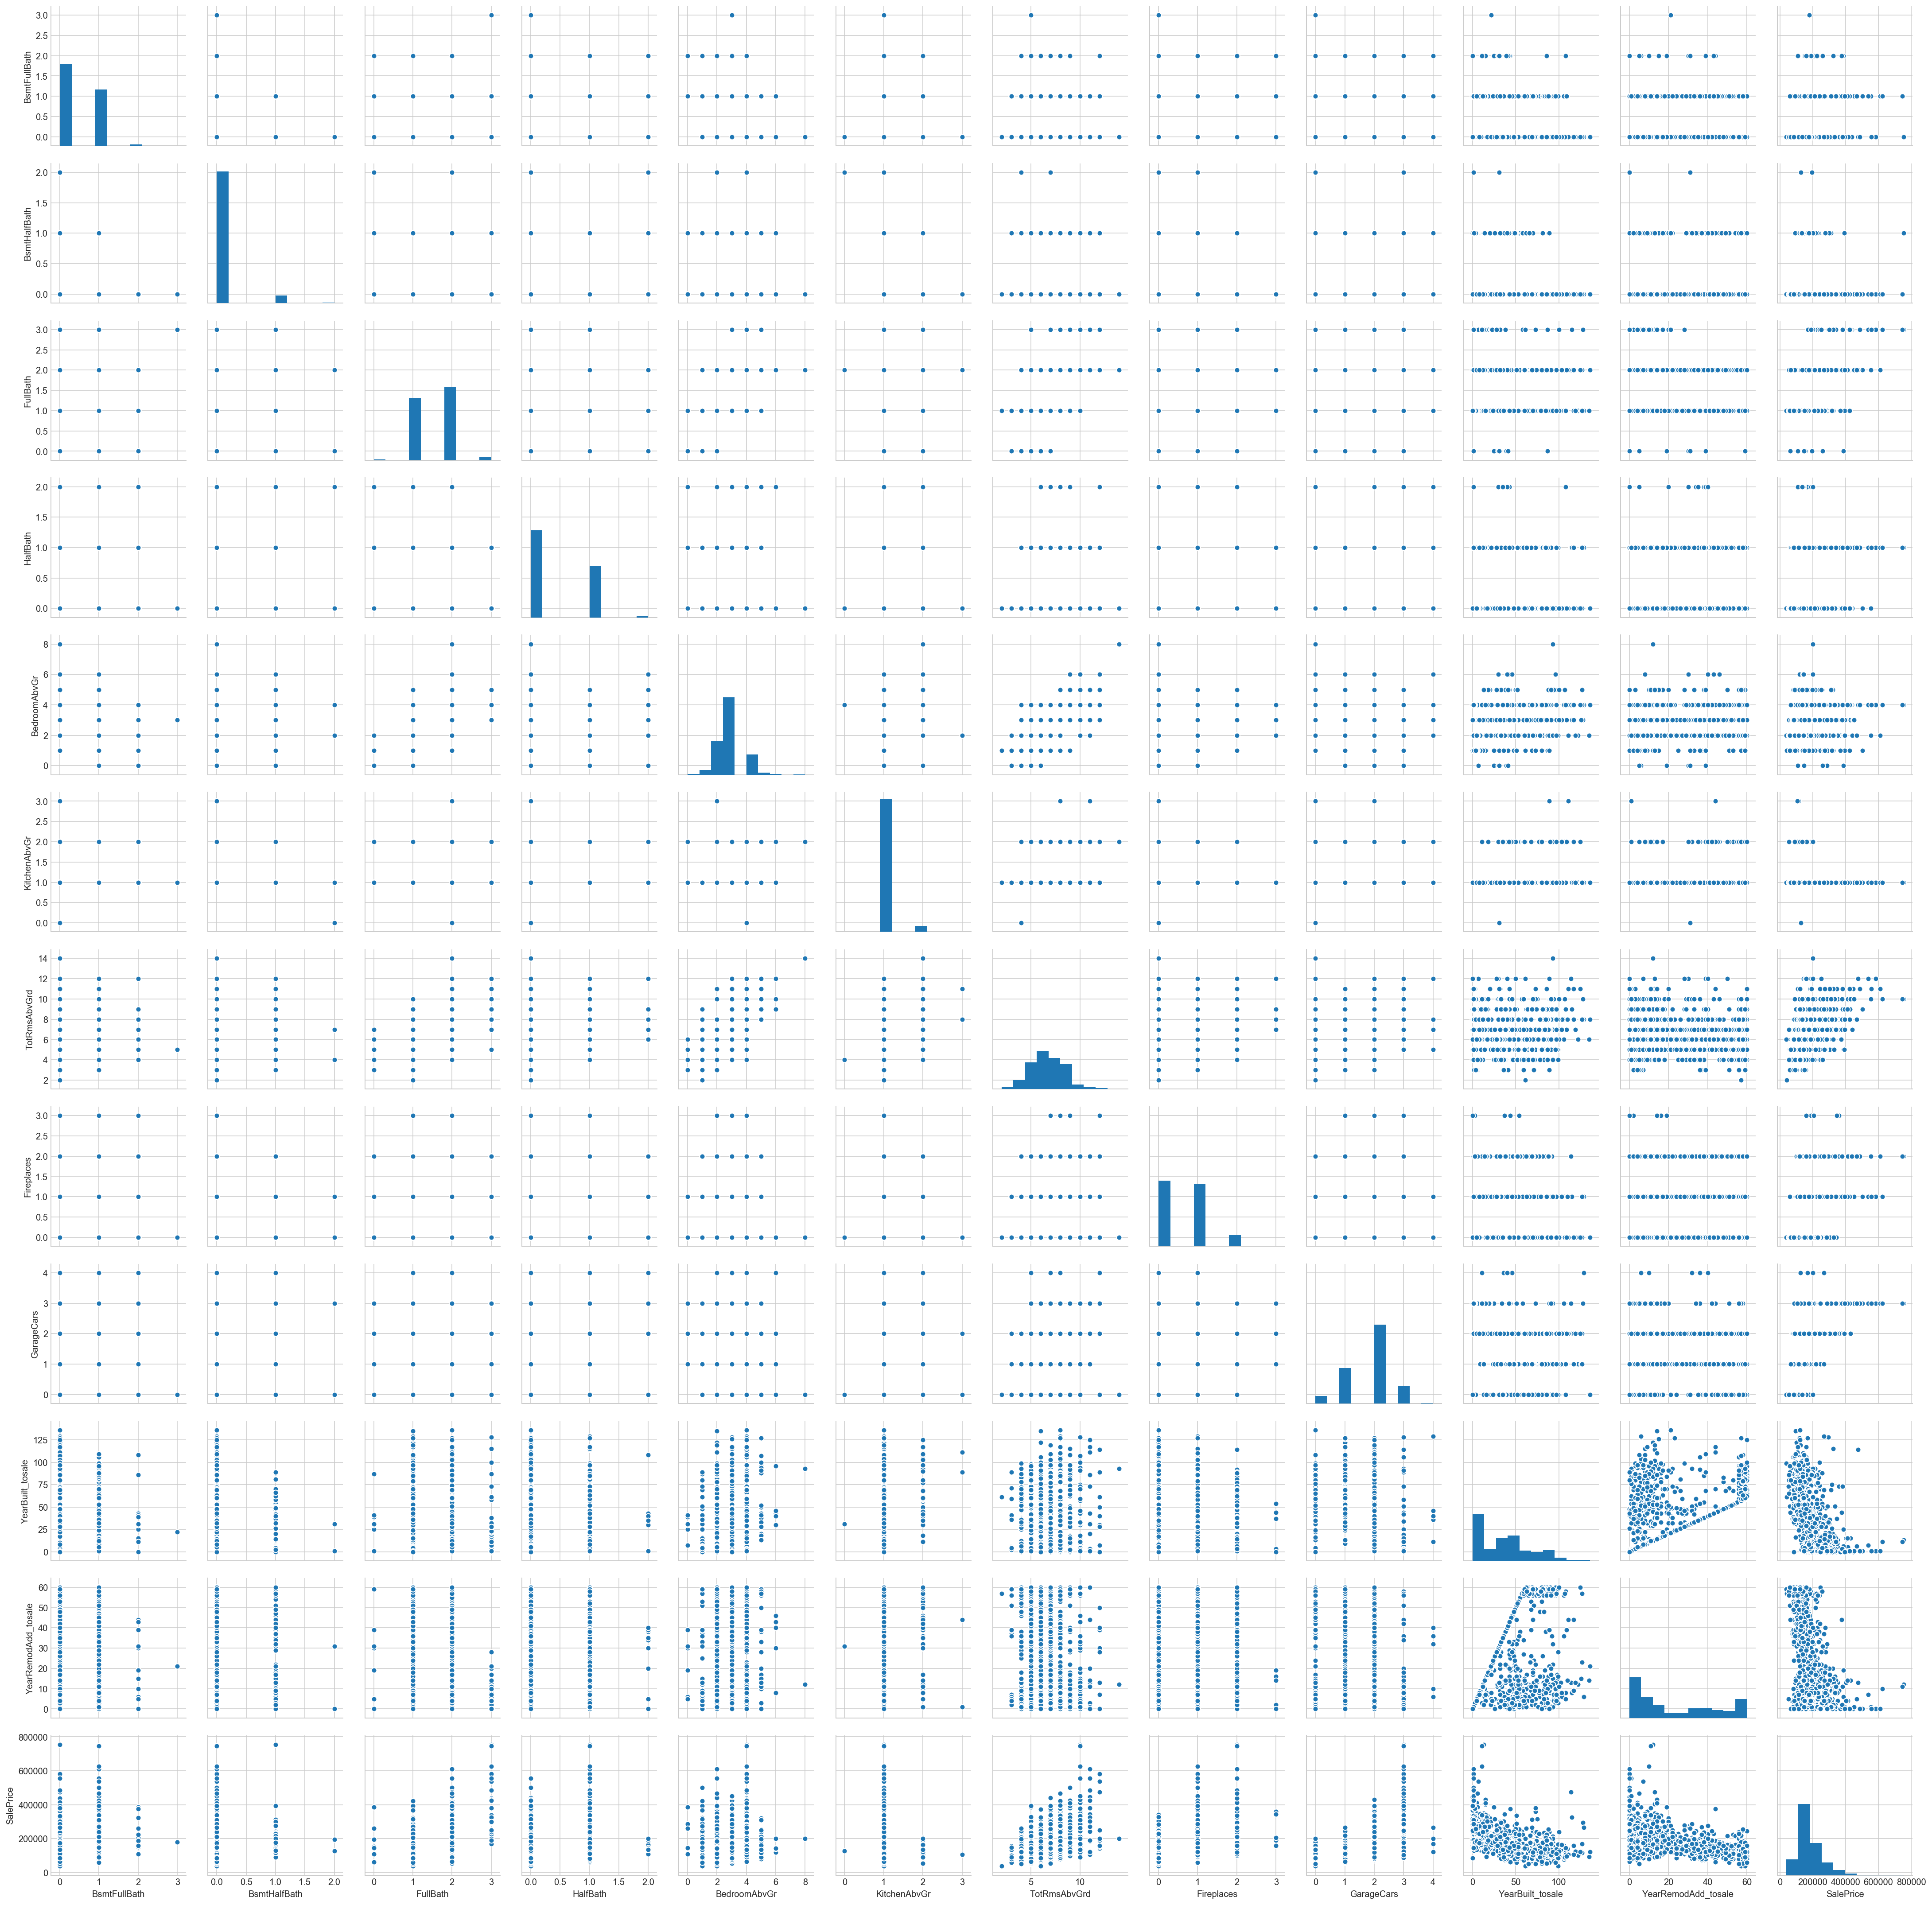

In [21]:
ord_df = df_ff_cont[['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                     'Fireplaces', 'GarageCars', 'YearBuilt_tosale','YearRemodAdd_tosale', 'SalePrice']]
sns.pairplot(ord_df)
#positive correlation looks good for ordered variables on SalePrice as well

In [22]:
#finished log-normal transformation, create new dataframe of lognormal and ordered continuous variables before running correlation check
ff_cont_new = pd.concat([log_df.iloc[:,:-1],ord_df], axis=1) 

In [23]:
#top 10 strongest correlation with SalePrice
c = ff_cont_new.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so2 = pd.DataFrame(so).reset_index()
so2[so2[0] != 1.0]
so2[(so2[0] != 1.0) & (so2['level_0'] == 'SalePrice')].head(10)

level_0              level_1         0
30  SalePrice            GrLivArea  0.696090
37  SalePrice           GarageCars  0.641424
42  SalePrice             1stFlrSF  0.588549
47  SalePrice             FullBath  0.558521
54  SalePrice         TotRmsAbvGrd  0.535965
58  SalePrice     YearBuilt_tosale  0.517864
63  SalePrice  YearRemodAdd_tosale  0.502966
73  SalePrice           Fireplaces  0.465263
85  SalePrice          OpenPorchSF  0.432265
97  SalePrice              LotArea  0.392585

In [24]:
ff_cont_new.columns

Index([u'LotFrontage', u'LotArea', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF',
       u'GrLivArea', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'GarageCars', u'YearBuilt_tosale', u'YearRemodAdd_tosale',
       u'SalePrice'],
      dtype='object')

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


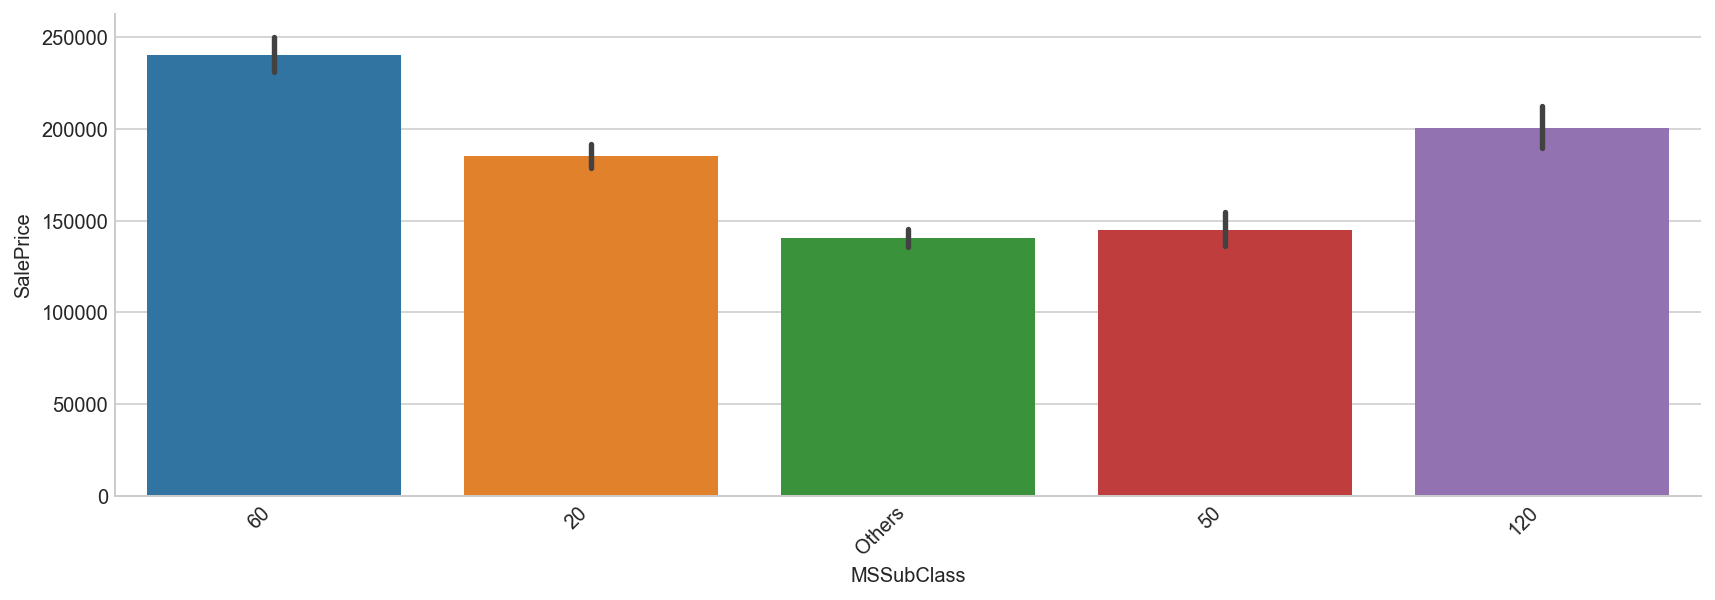

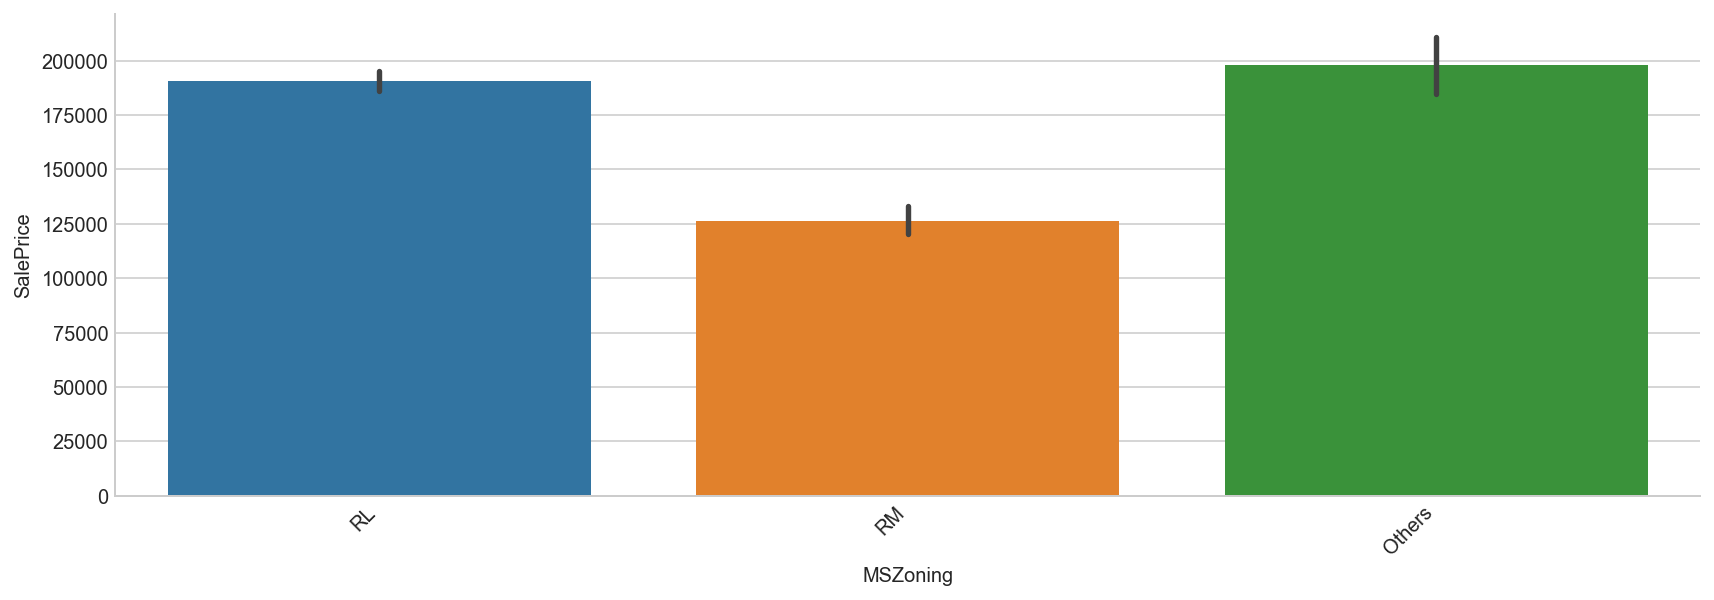

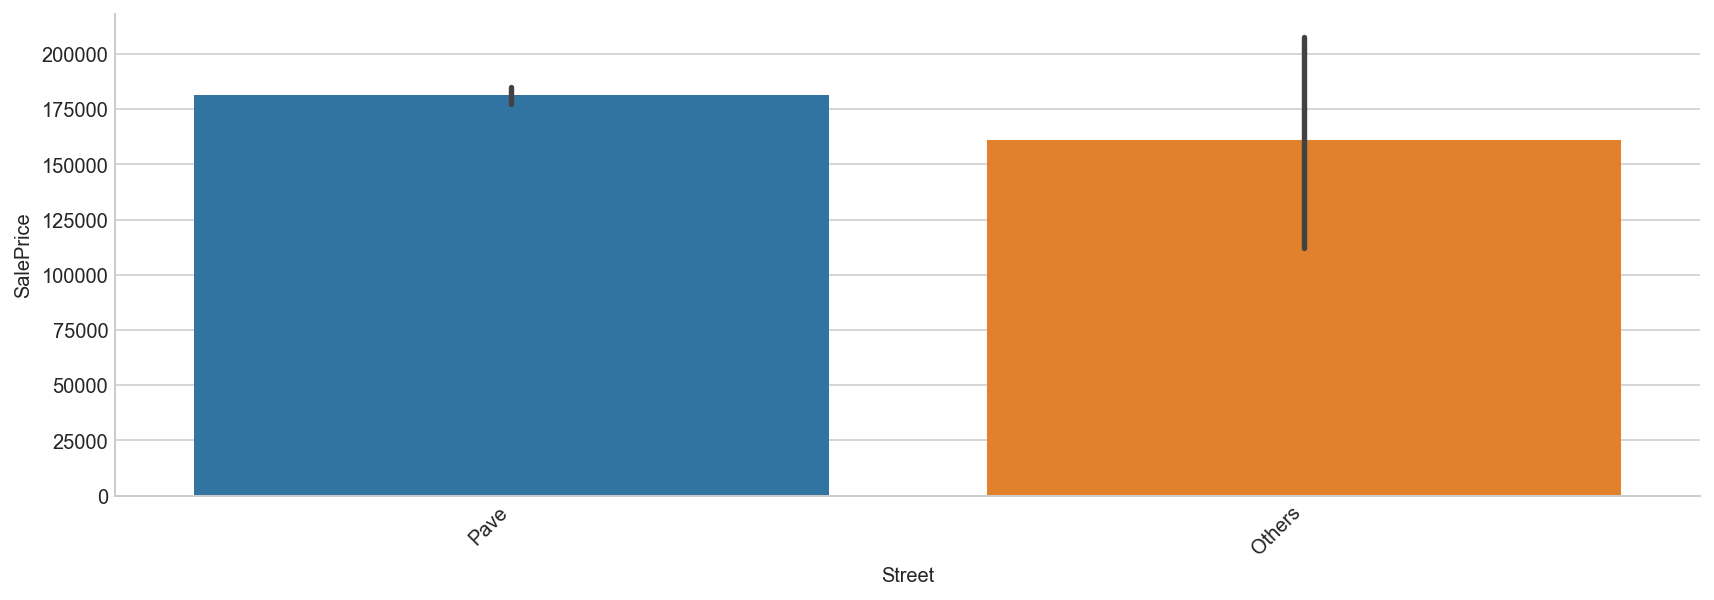

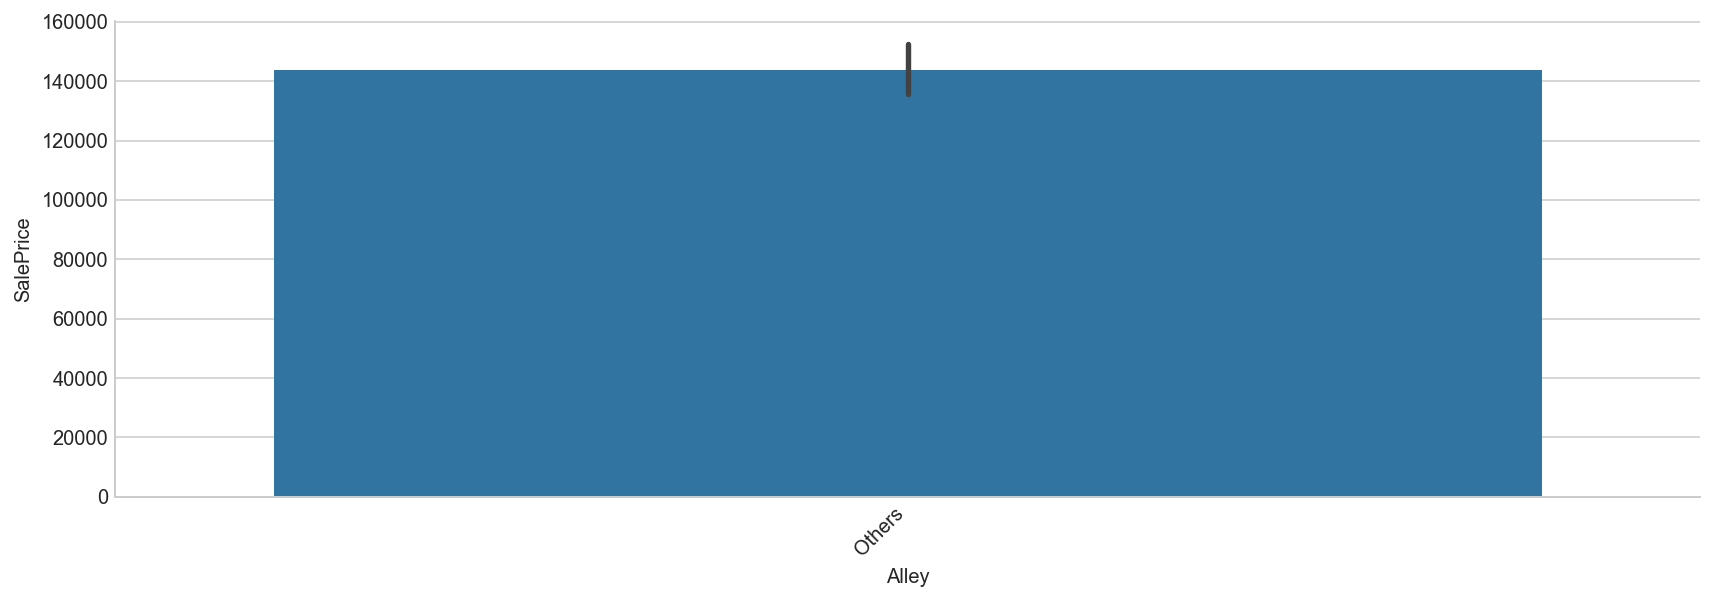

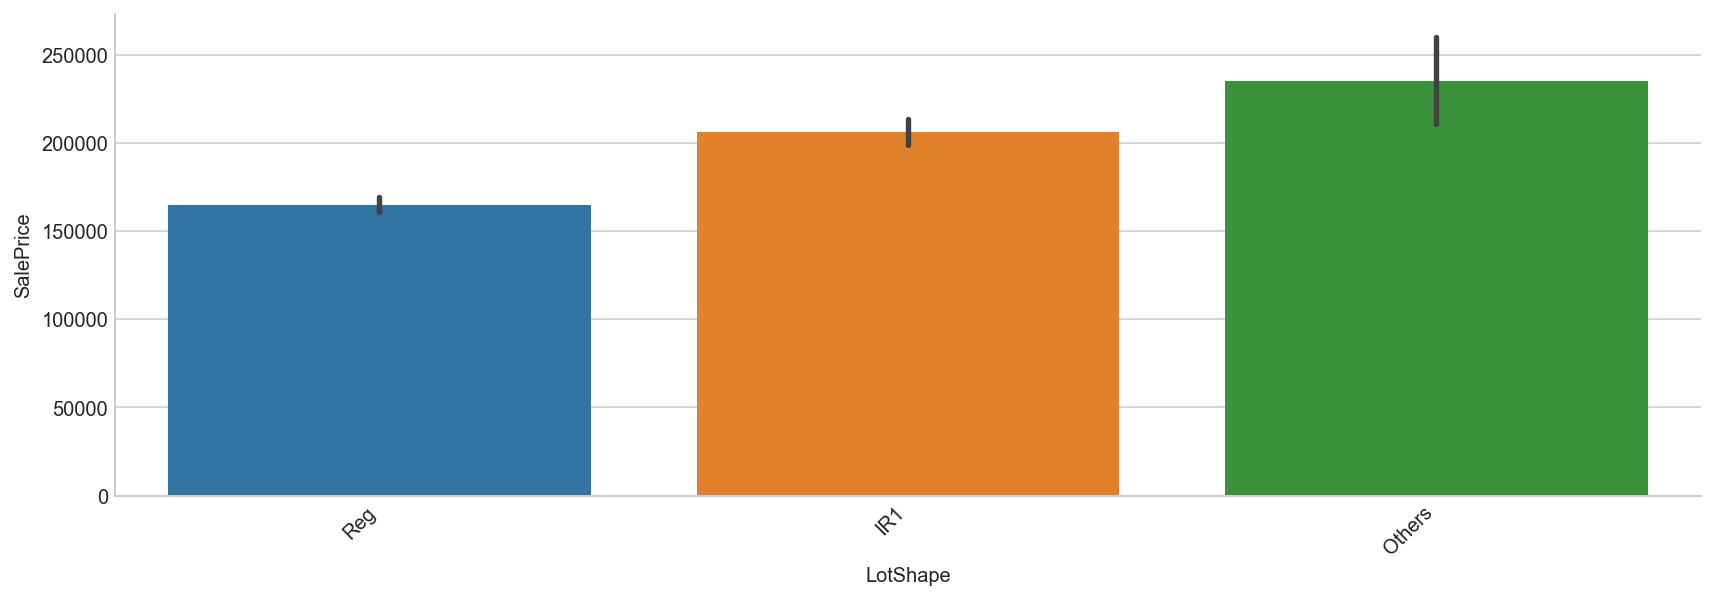

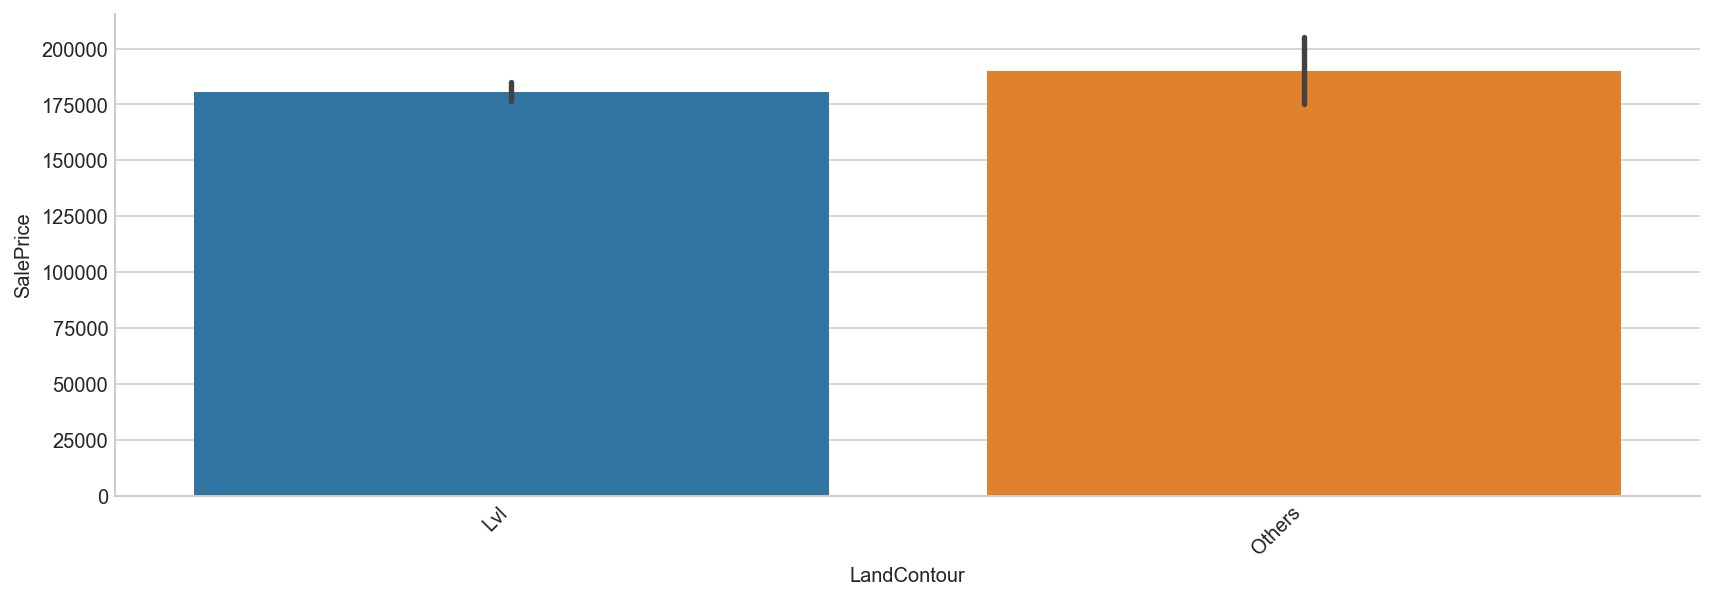

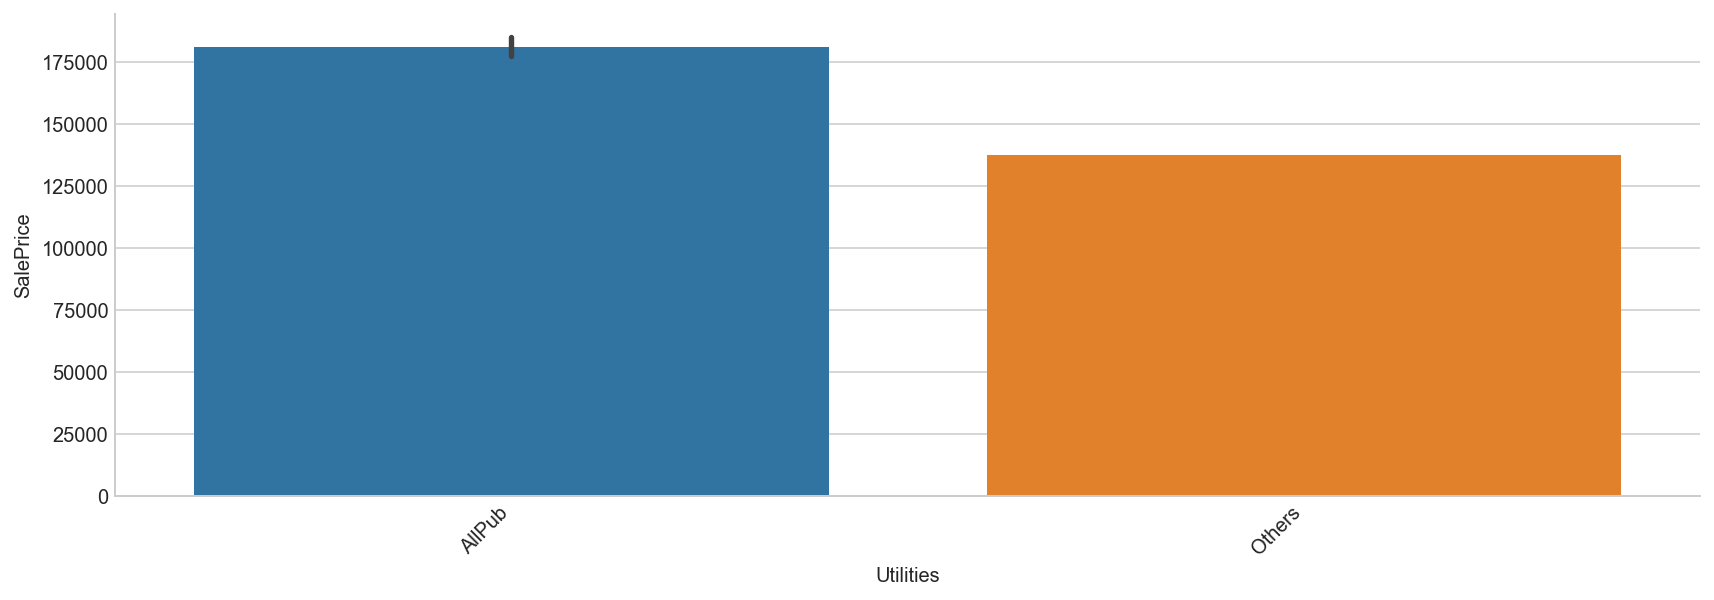

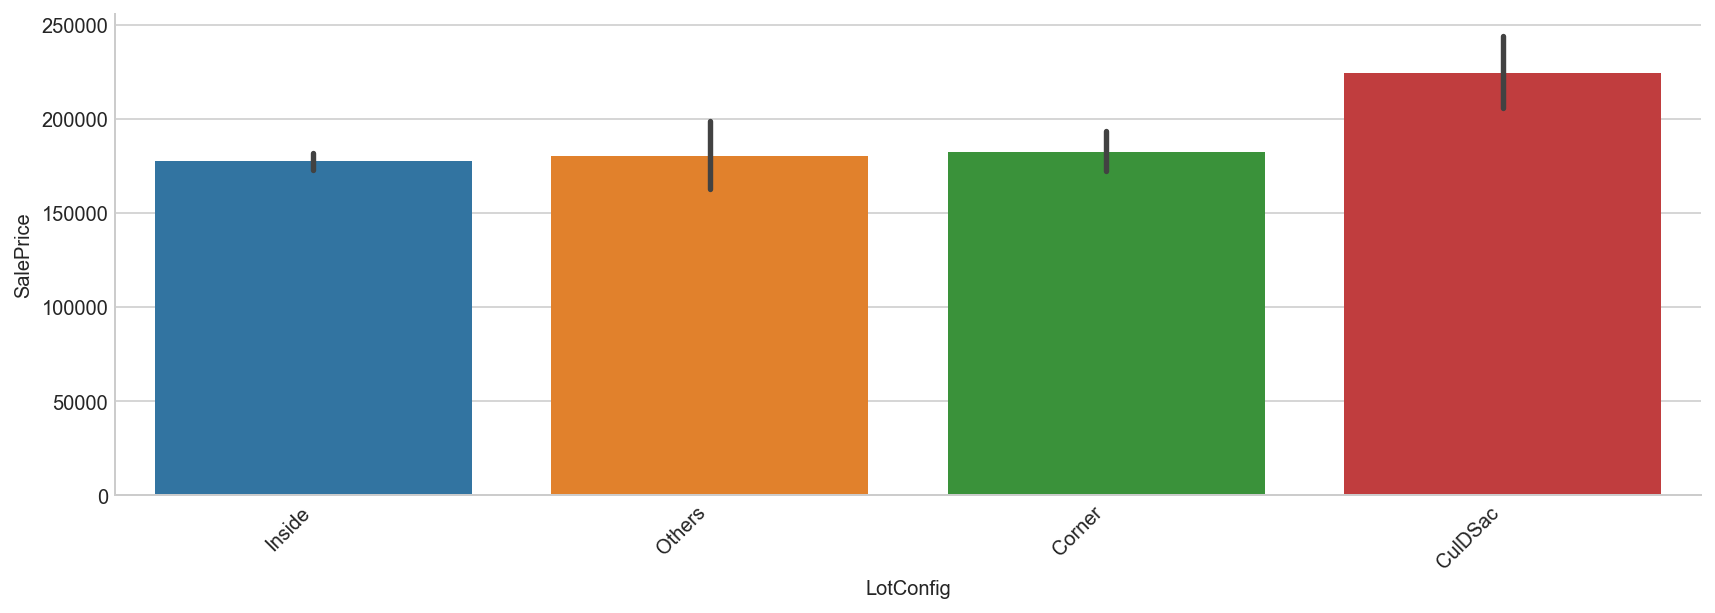

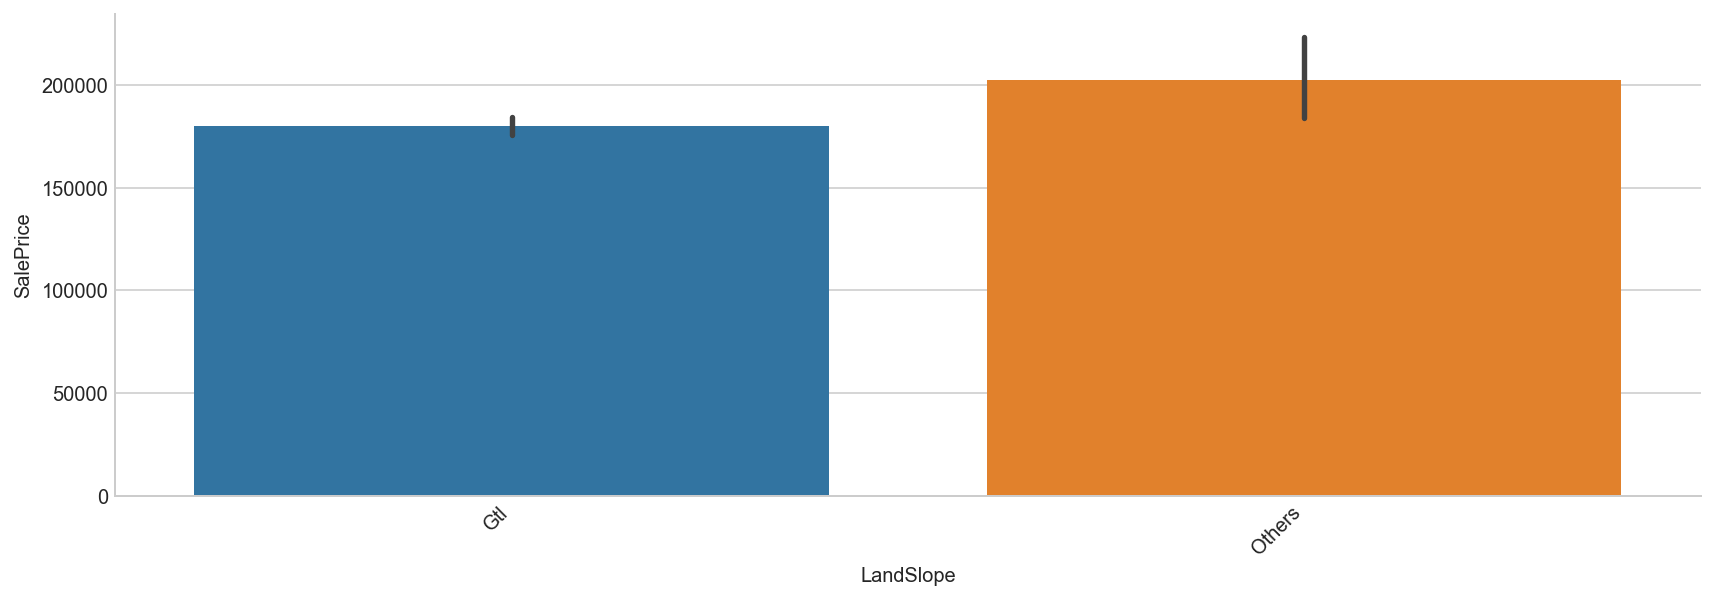

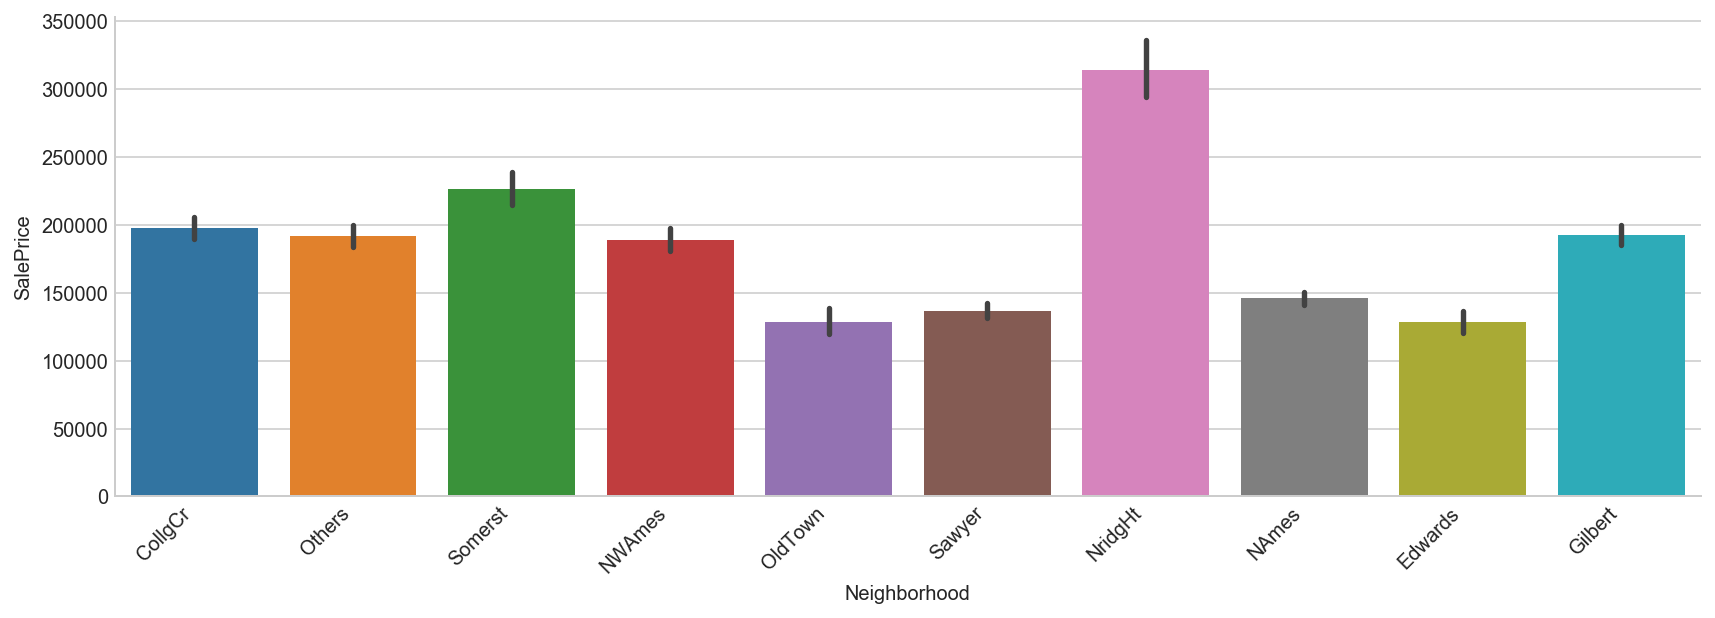

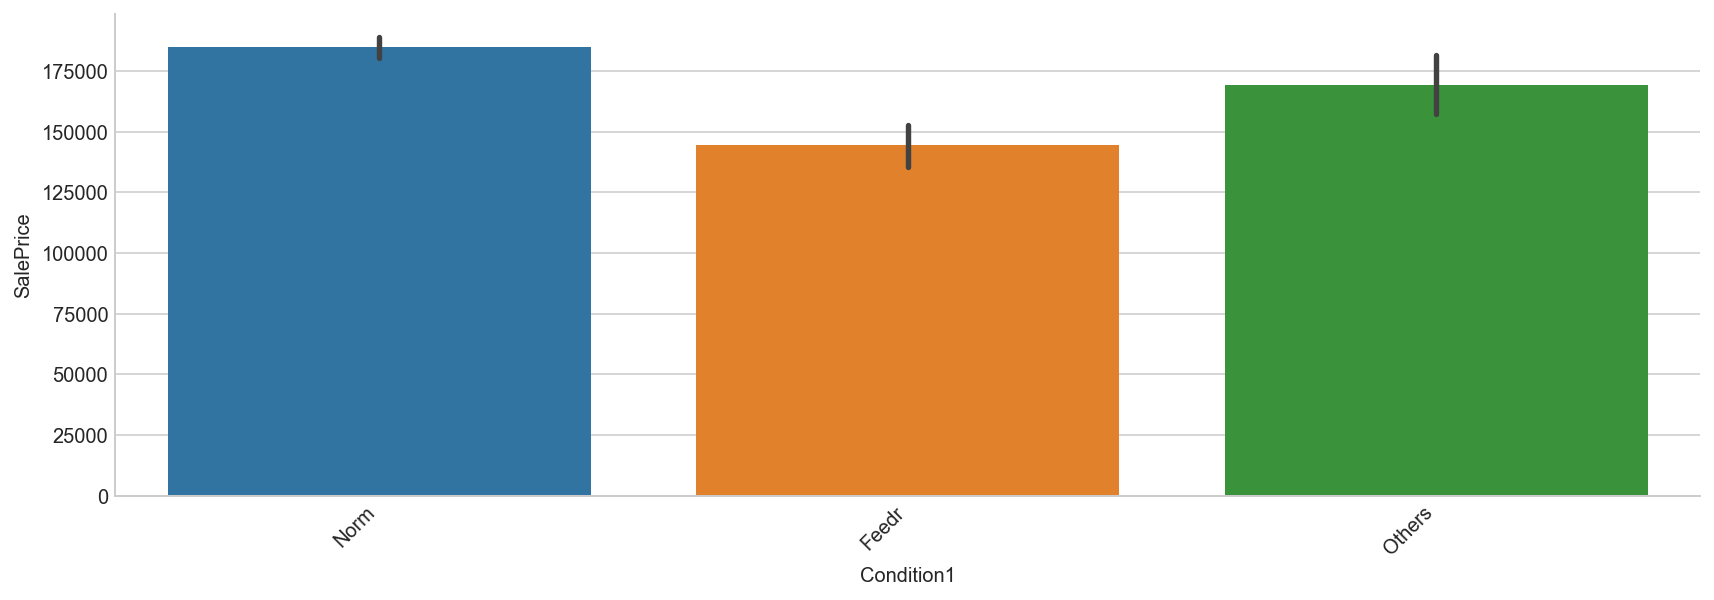

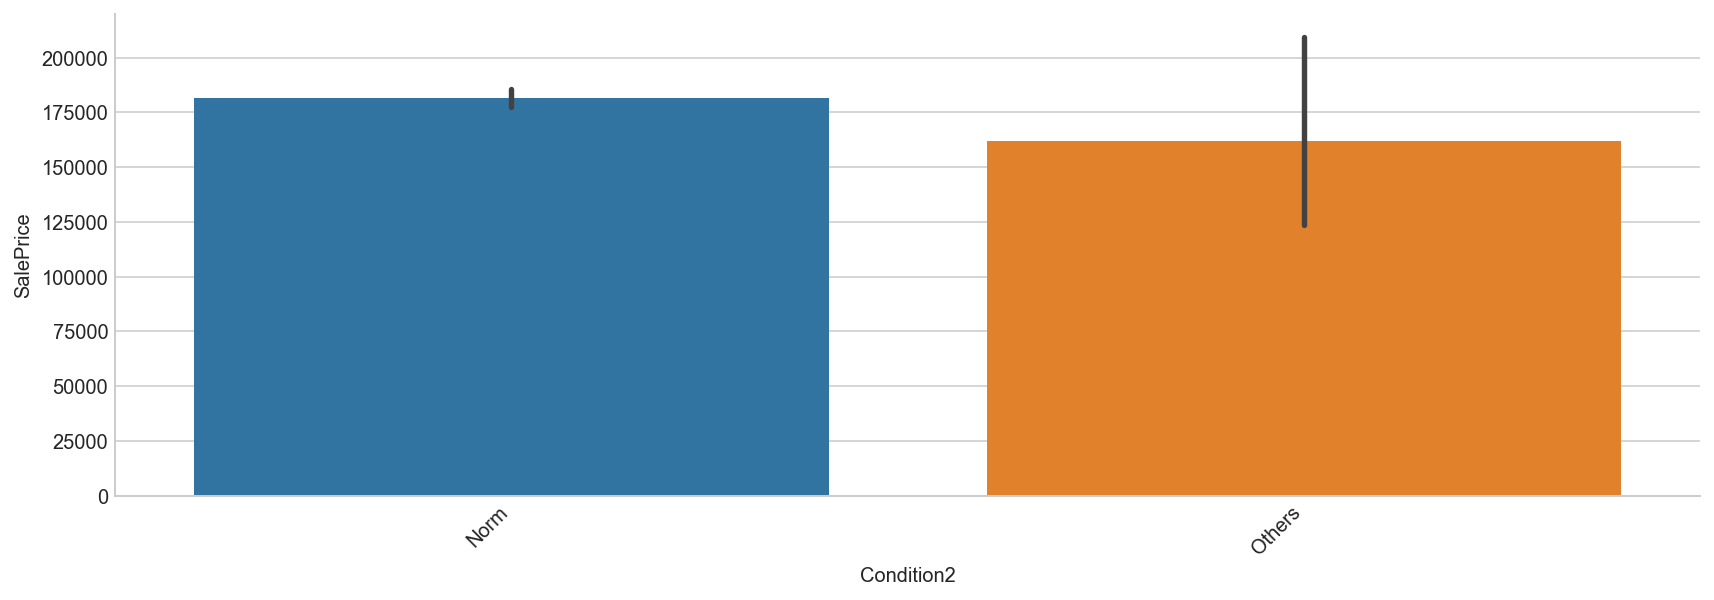

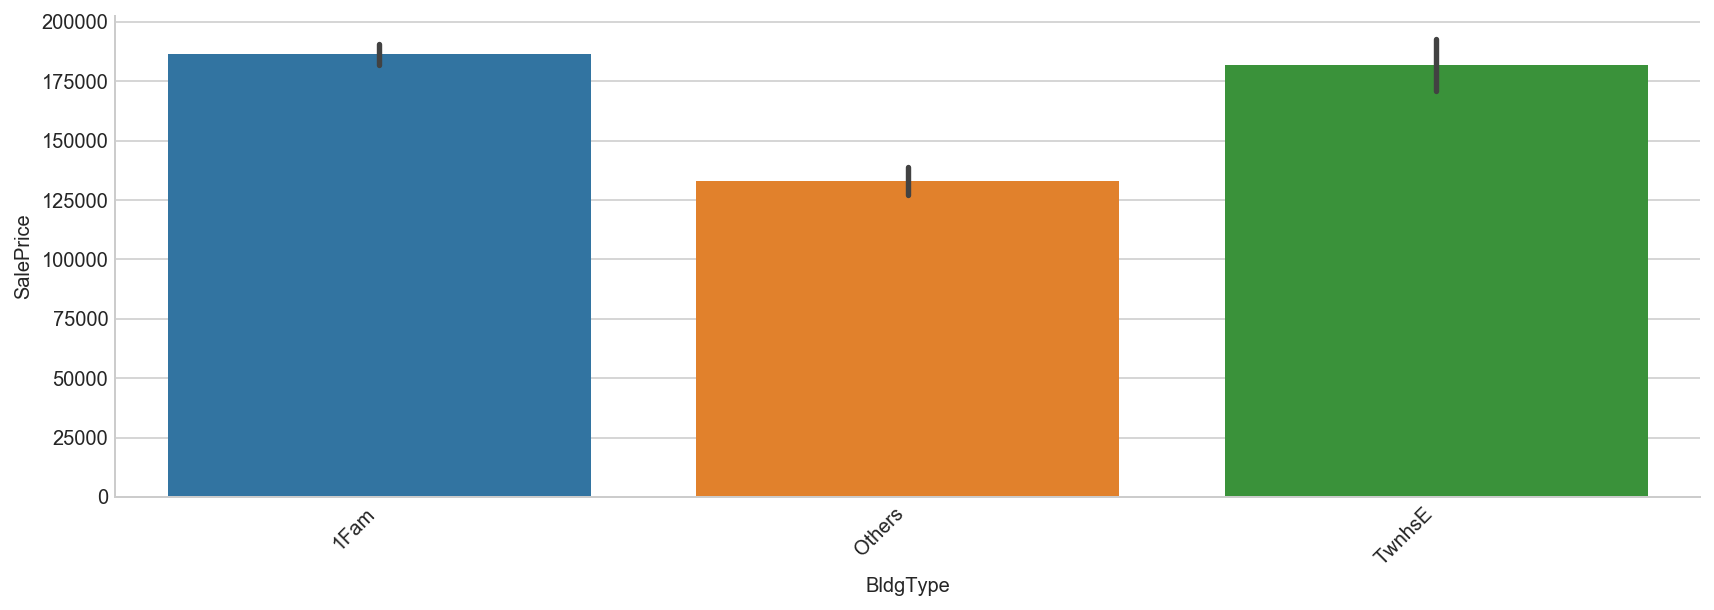

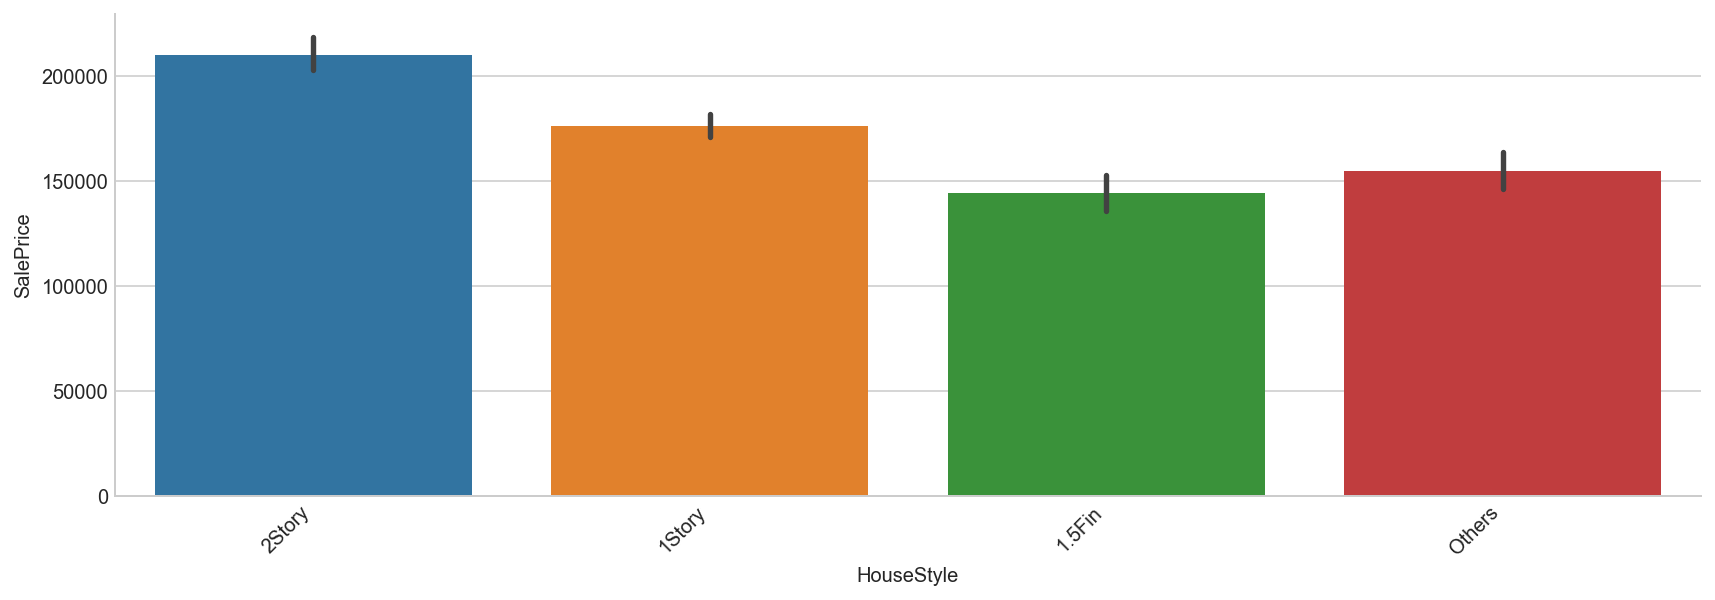

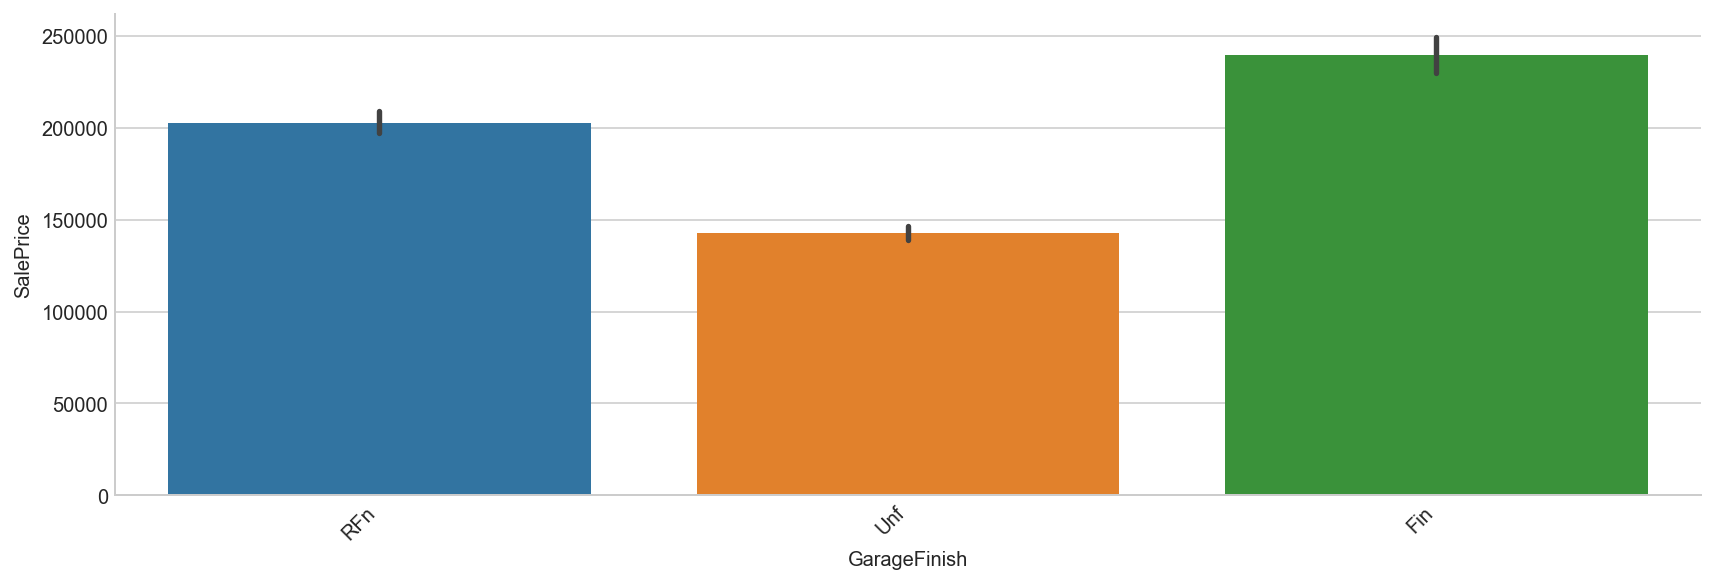

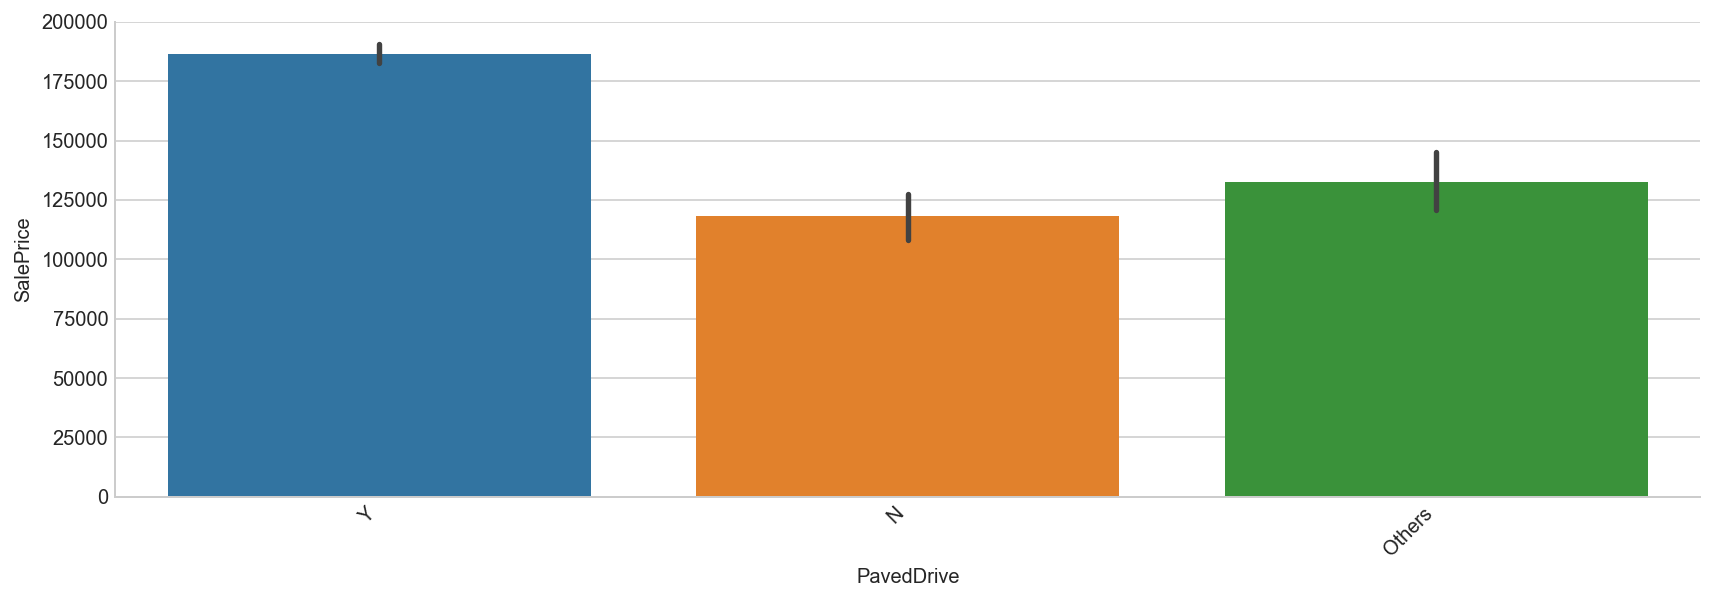

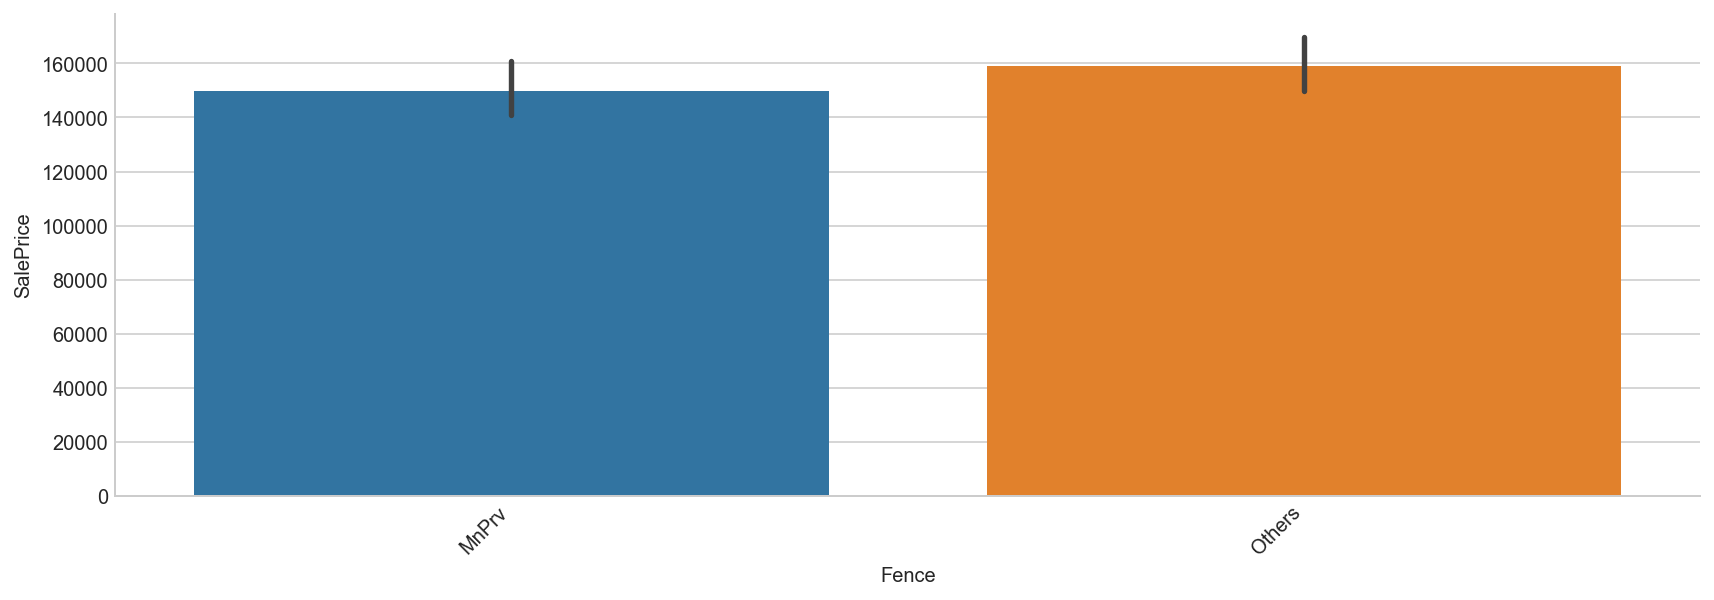

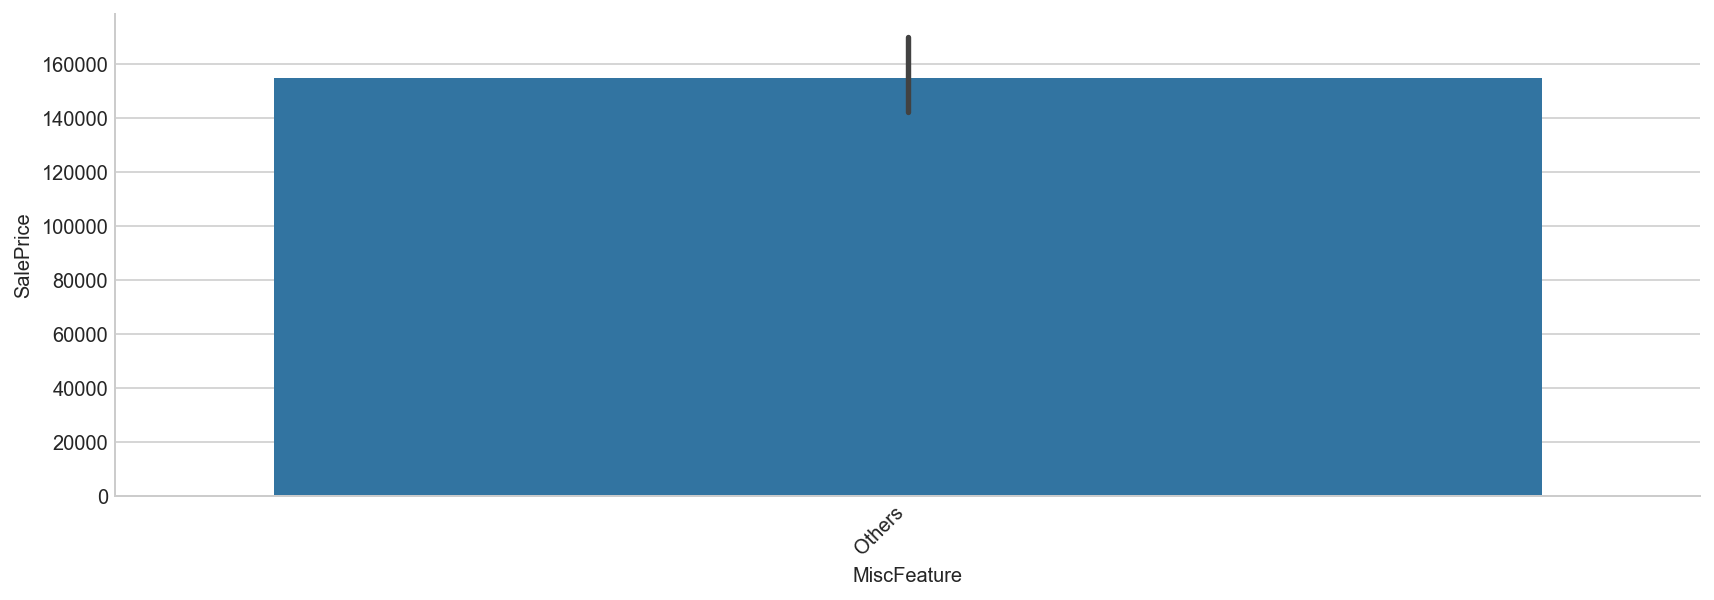

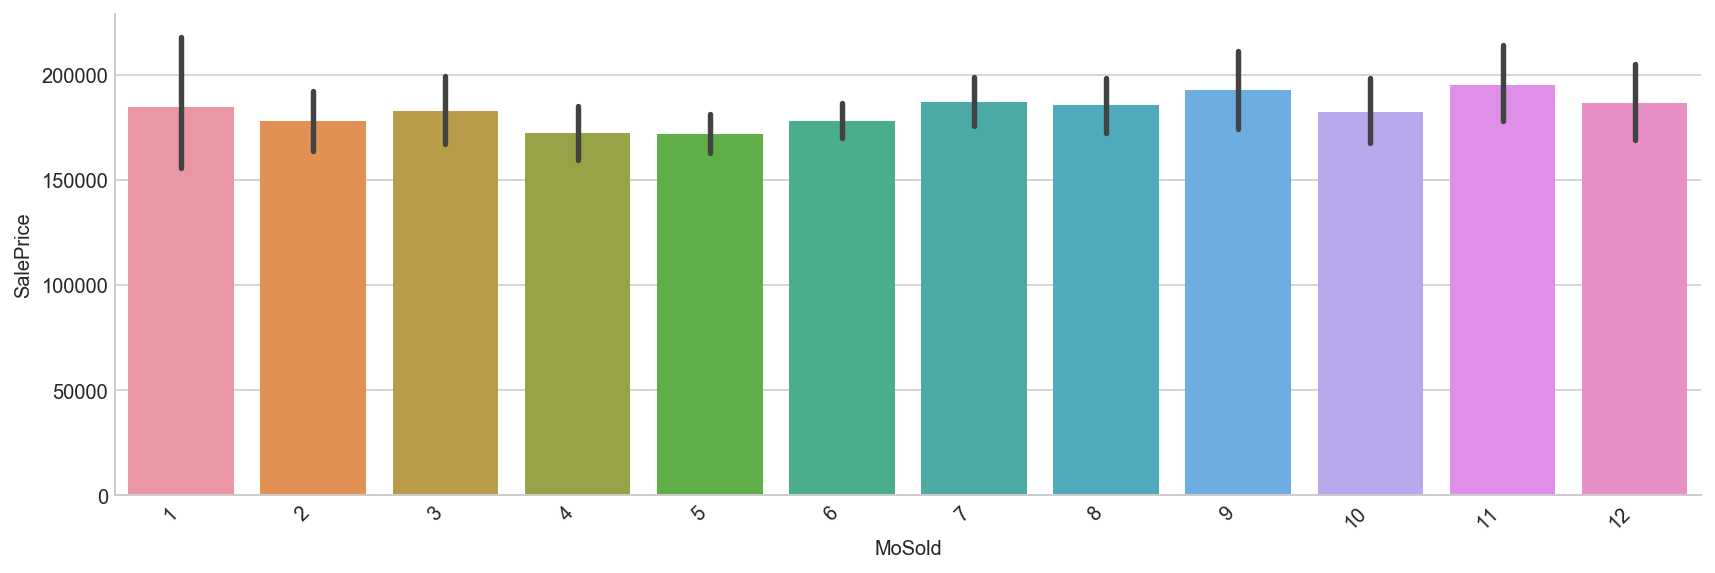

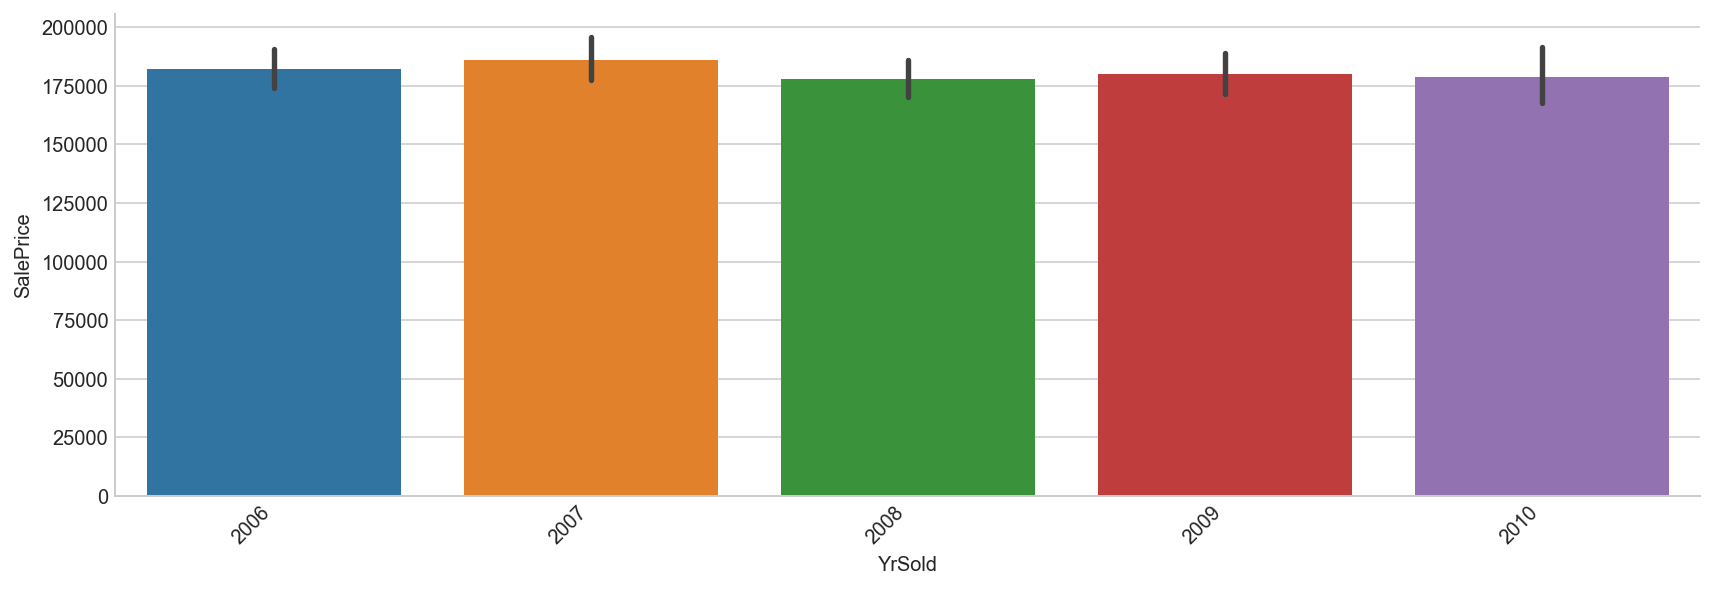

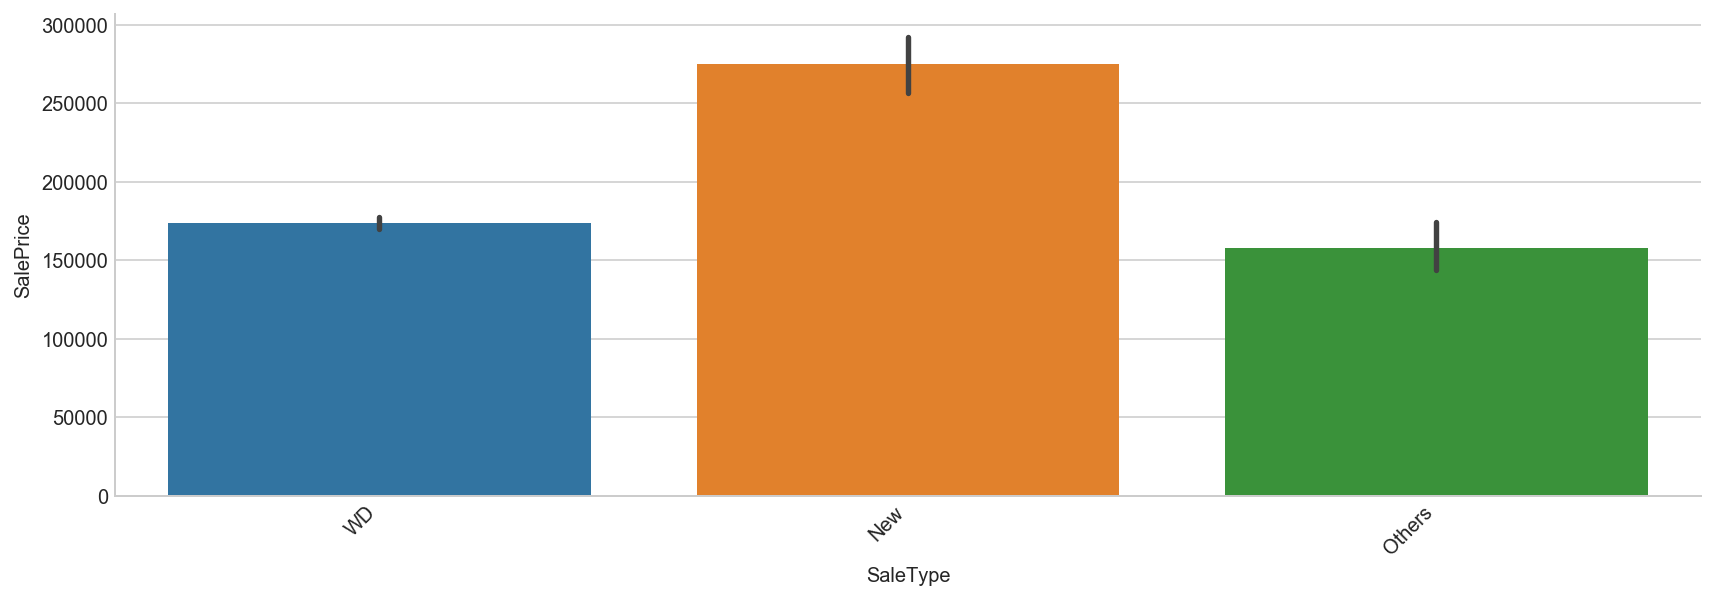

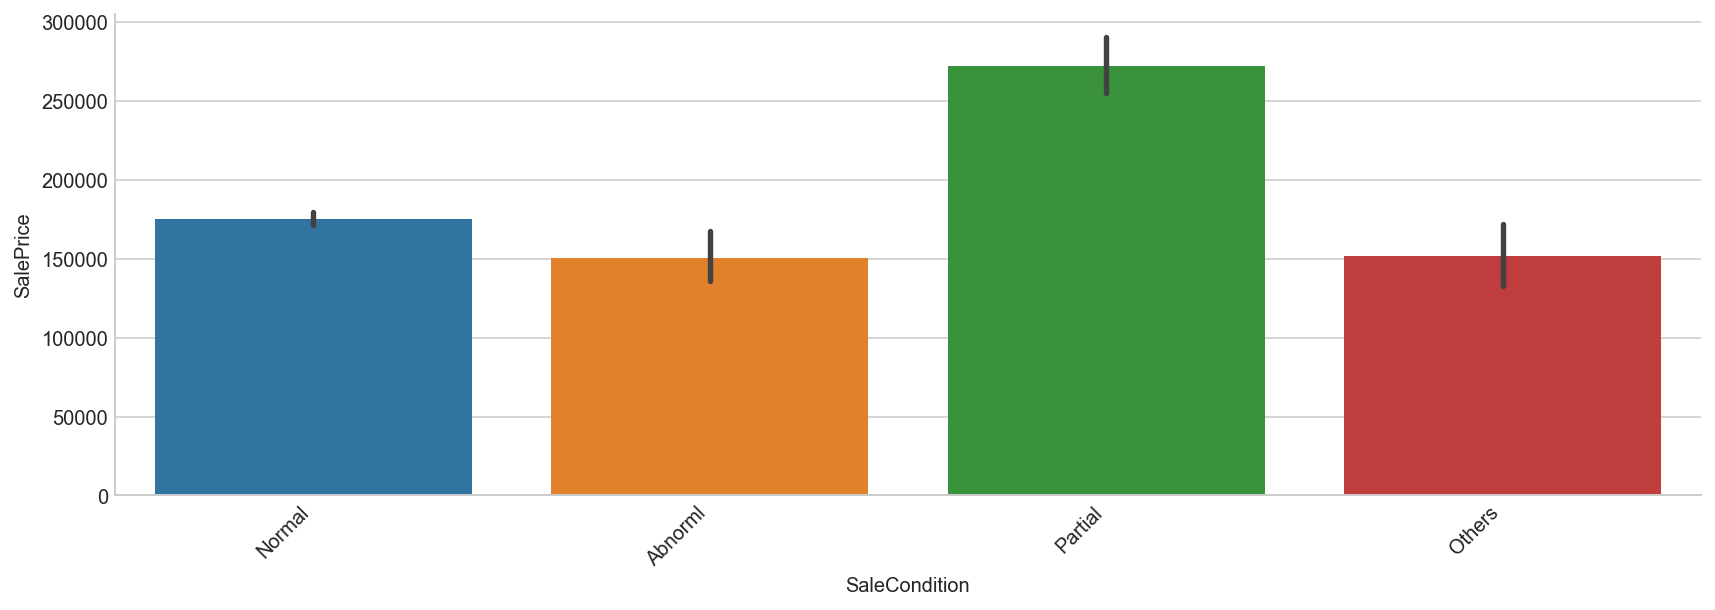

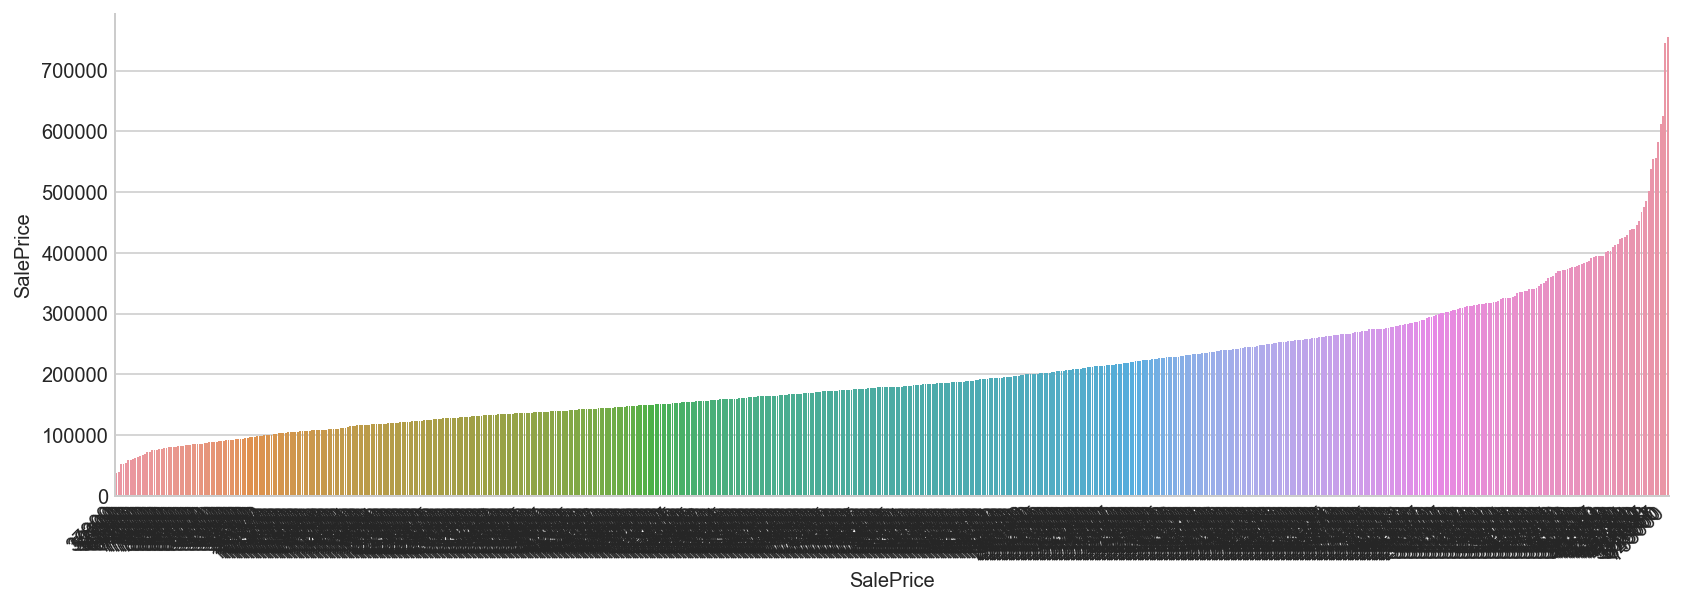

In [25]:
#most categories do have differences in mean saleprice
df_ff_obj['SalePrice'] = df['SalePrice']
for c in df_ff_obj.columns:
    sns.factorplot(x=c, y='SalePrice', data=df_ff_obj, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

In [26]:
#get dummies for obj columns
dummies = pd.get_dummies(df_ff_obj.iloc[:,:-1], drop_first = True)

Step 2 Feature Selection

In [27]:
#new dataframe making up of transformed columns
df_new = pd.concat([dummies,ff_cont_new], axis=1)
df_new.columns

Index([u'MSSubClass_50', u'MSSubClass_60', u'MSSubClass_120',
       u'MSSubClass_Others', u'MSZoning_RL', u'MSZoning_RM', u'Street_Pave',
       u'LotShape_Others', u'LotShape_Reg', u'LandContour_Others',
       u'Utilities_Others', u'LotConfig_CulDSac', u'LotConfig_Inside',
       u'LotConfig_Others', u'LandSlope_Others', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_NAmes', u'Neighborhood_NWAmes',
       u'Neighborhood_NridgHt', u'Neighborhood_OldTown',
       u'Neighborhood_Others', u'Neighborhood_Sawyer', u'Neighborhood_Somerst',
       u'Condition1_Norm', u'Condition1_Others', u'Condition2_Others',
       u'BldgType_Others', u'BldgType_TwnhsE', u'HouseStyle_1Story',
       u'HouseStyle_2Story', u'HouseStyle_Others', u'GarageFinish_RFn',
       u'GarageFinish_Unf', u'PavedDrive_Others', u'PavedDrive_Y',
       u'Fence_Others', u'MoSold_2', u'MoSold_3', u'MoSold_4', u'MoSold_5',
       u'MoSold_6', u'MoSold_7', u'MoSold_8', u'MoSold_9', u'MoSold_10',
     

In [28]:
#train_test split pre2010 sales and 2010 sales
train = df_new.ix[df[df['YrSold']<2010].index]
test = df_new.ix[df[df['YrSold']>=2010].index]

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [29]:
X_train = train.iloc[:,:-1]
y_train = train['SalePrice']
X_test = test.iloc[:,:-1]
y_test = test['SalePrice']
X_train_ss = StandardScaler().fit_transform(X_train)
X_test_ss = StandardScaler().fit_transform(X_test)

In [30]:
#f-test
from sklearn.feature_selection import SelectKBest, chi2, f_classif
selector=SelectKBest(score_func=f_classif,k=20) #select k predictors from f-test
selector.fit(X_train_ss,y_train)
list(zip(X_train.columns.values, selector.scores_, selector.pvalues_)) #print variable, F-test value & p-value
X_f_col = np.array(X_train.columns[selector.get_support(True)]) #select chosen column, true gives column index
X_f_col
#not to use Street_Pave and LotShape, condition2, SaleCondition_Alloca <10 pave data points only
#strong predictors are 'Neighborhood', 'SaleType', 'SaleCondition_Partial','TotalBsmtSF','GrLivArea', 'FullBath', 'GarageCars'

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [51] are constant.
  UserWarning)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array(['MSSubClass_60', 'Street_Pave', 'LotShape_Reg',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'GarageFinish_Unf',
       'SaleType_WD', 'SaleCondition_Normal', 'SaleCondition_Partial',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'OpenPorchSF', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'YearBuilt_tosale', 'YearRemodAdd_tosale'], dtype=object)

In [31]:
#Recursive feature elimination
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X_train_ss, y_train)
list(zip(X_train.columns.values, selector.support_, selector.ranking_)) #print variables, selection and ranks -> rank 1 is the best
X_RFECV_col = np.array(X_train.columns[selector.support_]) #select chosen column from TRUE
X_RFECV_col

#strong predictors are 'Neighbor', 'LotArea','TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
#'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
#'GarageCars', 'YearBuilt_tosale', 'YearRemodAdd_tosale'

array(['LotConfig_CulDSac', 'Neighborhood_Gilbert', 'Neighborhood_NWAmes',
       'Neighborhood_NridgHt', 'Neighborhood_Others',
       'Neighborhood_Somerst', 'Condition1_Norm', 'BldgType_Others',
       'BldgType_TwnhsE', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'SaleType_Others', 'SaleType_WD', 'SaleCondition_Partial',
       'LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'YearBuilt_tosale', 'YearRemodAdd_tosale'], dtype=object)

In [32]:
#lasso selection
from sklearn.linear_model import LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV decide what alphas to use, just set no. of alphas to test.
optimal_lasso.fit(X_train_ss, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=500, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [33]:
coefs = list(zip(X_train.columns.values, optimal_lasso.coef_))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
X_lasso_col = coefs[coefs['abs'] != 0].sort_values('abs', ascending=False).head(20)
X_lasso_col = np.array(X_lasso_col.iloc[:,0])
X_lasso_col

array(['GrLivArea', 'GarageCars', 'Neighborhood_NridgHt', '1stFlrSF',
       'BedroomAbvGr', 'BsmtFullBath', 'YearBuilt_tosale', 'KitchenAbvGr',
       'FullBath', 'LotArea', 'TotRmsAbvGrd', 'Neighborhood_Others',
       'SaleCondition_Partial', 'YearRemodAdd_tosale',
       'Neighborhood_Gilbert', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'Fireplaces', 'Neighborhood_Somerst', 'Condition1_Norm'],
      dtype=object)

In [34]:
sel = list(X_RFECV_col)
for e in list(X_f_col):
    sel.append(e)
for e in list(X_lasso_col):
    sel.append(e)
from collections import Counter
sel_fea = pd.DataFrame.from_dict(Counter(sel), orient='index').reset_index()
sel_fea[sel_fea[0]==3]
#features selected by f-test, recursive and lasso models.
#select all dummies for SaleCondition, GarageFinish and Neighborhood to be able to explain regression coefficient relative to baseline dummy

index  0
9               GrLivArea  3
10               1stFlrSF  3
11             Fireplaces  3
17           TotRmsAbvGrd  3
20               FullBath  3
22    YearRemodAdd_tosale  3
24  SaleCondition_Partial  3
25       GarageFinish_Unf  3
28       YearBuilt_tosale  3
31             GarageCars  3
32   Neighborhood_NridgHt  3
33   Neighborhood_Somerst  3

In [35]:
#selected columns
X_train_sel = X_train[['GrLivArea','1stFlrSF','Fireplaces','TotRmsAbvGrd','FullBath','YearRemodAdd_tosale','YearBuilt_tosale','GarageCars',
        'Neighborhood_Edwards','Neighborhood_Gilbert', 'Neighborhood_NAmes', 'Neighborhood_NWAmes','Neighborhood_NridgHt', 
         'Neighborhood_OldTown','Neighborhood_Others', 'Neighborhood_Sawyer', 'Neighborhood_Somerst','GarageFinish_RFn',
         'GarageFinish_Unf']]
X_test_sel = X_test[['GrLivArea','1stFlrSF','Fireplaces','TotRmsAbvGrd','FullBath','YearRemodAdd_tosale','YearBuilt_tosale','GarageCars',
        'Neighborhood_Edwards','Neighborhood_Gilbert', 'Neighborhood_NAmes', 'Neighborhood_NWAmes','Neighborhood_NridgHt', 
         'Neighborhood_OldTown','Neighborhood_Others', 'Neighborhood_Sawyer', 'Neighborhood_Somerst','GarageFinish_RFn',
         'GarageFinish_Unf']]

In [36]:
#final check on collinearity issue
c = X_train_sel.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so2 = pd.DataFrame(so).reset_index()
so2[so2[0] != 1.0].head(10)

level_0              level_1         0
19            GrLivArea         TotRmsAbvGrd  0.825438
20         TotRmsAbvGrd            GrLivArea  0.825438
21            GrLivArea             FullBath  0.646890
22             FullBath            GrLivArea  0.646890
23  YearRemodAdd_tosale     YearBuilt_tosale  0.591360
24     YearBuilt_tosale  YearRemodAdd_tosale  0.591360
25             FullBath         TotRmsAbvGrd  0.548253
26         TotRmsAbvGrd             FullBath  0.548253
27             1stFlrSF            GrLivArea  0.542833
28            GrLivArea             1stFlrSF  0.542833

In [37]:
import statsmodels.formula.api as sm
sm_df = pd.concat([X_train_sel,y_train], axis=1)
sm_df.rename(columns={'1stFlrSF':'firstFlrSF'}, inplace=True)
model = sm.ols('SalePrice~GrLivArea+firstFlrSF+Fireplaces+TotRmsAbvGrd+FullBath+YearRemodAdd_tosale+YearBuilt_tosale+GarageCars+Neighborhood_Edwards+Neighborhood_Gilbert+Neighborhood_NAmes+Neighborhood_NWAmes+Neighborhood_NridgHt+Neighborhood_OldTown+Neighborhood_Others+Neighborhood_Sawyer+Neighborhood_Somerst+GarageFinish_RFn+GarageFinish_Unf', data=sm_df).fit()
model.summary()
#strong collinearity among GrLivArea, TotRmsAbvGrd, FullBath leading to non-sig results.
#remove TotRmsAbvGrd and FullBath for explanatory model to give better coefficient interpretation
#however TotRmsAbvGrd and FullBath can be included for predictive model which does not require coefficient validity

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     188.2
Date:                Mon, 02 Jul 2018   Prob (F-statistic):               0.00
Time:                        20:47:49   Log-Likelihood:                -15277.
No. Observations:                1271   AIC:                         3.059e+04
Df Residuals:                    1251   BIC:                         3.070e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6.735e+05   5.05e+04    -13.329      0.000   -7.73e+05   -5.74e+05
GrLivArea             8.104e+04   7828.442     10.352      0.000    6.57e+04    9.64e+04
firstFlrSF            3.614e+04   4918.823      7.348      0.000    2.65e+04    4.58e+04
Fireplaces            1.427e+04   2174.829      6.561      0.000       1e+04    1.85e+04
TotRmsAbvGrd           821.2720   1312.386      0.626      0.532   -1753.448    3395.992
FullBath             -1406.5345   3191.149     -0.441      0.659   -7667.129    4854.060
YearRemodAdd_tosale   -455.2067     75.710     -6.012      0.000    -603.739    -306.674
YearBuilt_tosale      -302.4238     69.740     -4.336      0.000    -439.244    -165.603
GarageCars            1.938e+04   2184.663      8.873      0.000    1.51e+04    2.37e+04
Neighborhood_Edwards -1.498e+04   6135.720     -2.442      0.015    -2.7e+04   -2946.089
Neighborhood_Gilbert -2.418e+04   6274.299     -3.855      0.000   -3.65e+04   -1.19e+04
Neighborhood_NAmes   -7779.1312   5223.242     -1.489      0.137    -1.8e+04    2468.150
Neighborhood_NWAmes   -1.93e+04   6379.747     -3.025      0.003   -3.18e+04   -6785.084
Neighborhood_NridgHt  4.996e+04   6255.525      7.987      0.000    3.77e+04    6.22e+04
Neighborhood_OldTown -1.092e+04   6831.343     -1.599      0.110   -2.43e+04    2477.479
Neighborhood_Others   5600.9962   4497.739      1.245      0.213   -3222.948    1.44e+04
Neighborhood_Sawyer    -1.1e+04   6773.257     -1.625      0.104   -2.43e+04    2284.231
Neighborhood_Somerst  1.009e+04   5925.723      1.703      0.089   -1532.004    2.17e+04
GarageFinish_RFn       -1.4e+04   3153.316     -4.441      0.000   -2.02e+04   -7817.655
GarageFinish_Unf     -1.911e+04   3333.911     -5.731      0.000   -2.56e+04   -1.26e+04
==============================================================================
Omnibus:                      685.422   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17214.777
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                      20.592   Cond. No.                     2.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
model = sm.ols('SalePrice~GrLivArea+firstFlrSF+Fireplaces+YearRemodAdd_tosale+YearBuilt_tosale+GarageCars+Neighborhood_Edwards+Neighborhood_Gilbert+Neighborhood_NAmes+Neighborhood_NWAmes+Neighborhood_NridgHt+Neighborhood_OldTown+Neighborhood_Others+Neighborhood_Sawyer+Neighborhood_Somerst+GarageFinish_RFn+GarageFinish_Unf', data=sm_df).fit()
model.summary()
#interpretation as follows: a standard deviation increase in log GrLivArea increases SalePrice by 83440
#a standard deviation increase in no. of years (remodelled year to sales year) reduces price by 452
#neighborhood NridgHt gives highest prices followed by Somerst

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     210.5
Date:                Mon, 02 Jul 2018   Prob (F-statistic):               0.00
Time:                        20:47:49   Log-Likelihood:                -15277.
No. Observations:                1271   AIC:                         3.059e+04
Df Residuals:                    1253   BIC:                         3.068e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6.864e+05   3.76e+04    -18.275      0.000    -7.6e+05   -6.13e+05
GrLivArea             8.344e+04   4823.462     17.299      0.000     7.4e+04    9.29e+04
firstFlrSF             3.59e+04   4904.441      7.320      0.000    2.63e+04    4.55e+04
Fireplaces            1.421e+04   2136.500      6.650      0.000       1e+04    1.84e+04
YearRemodAdd_tosale   -452.6276     75.563     -5.990      0.000    -600.871    -304.384
YearBuilt_tosale      -291.9299     67.986     -4.294      0.000    -425.309    -158.551
GarageCars            1.939e+04   2182.080      8.886      0.000    1.51e+04    2.37e+04
Neighborhood_Edwards -1.501e+04   6127.751     -2.450      0.014    -2.7e+04   -2990.162
Neighborhood_Gilbert -2.429e+04   6250.944     -3.885      0.000   -3.65e+04    -1.2e+04
Neighborhood_NAmes   -7483.8958   5181.999     -1.444      0.149   -1.77e+04    2682.456
Neighborhood_NWAmes  -1.938e+04   6361.478     -3.046      0.002   -3.19e+04   -6894.702
Neighborhood_NridgHt  5.018e+04   6240.031      8.042      0.000    3.79e+04    6.24e+04
Neighborhood_OldTown  -1.12e+04   6809.439     -1.645      0.100   -2.46e+04    2155.698
Neighborhood_Others   5476.4682   4483.431      1.221      0.222   -3319.391    1.43e+04
Neighborhood_Sawyer  -1.055e+04   6729.127     -1.568      0.117   -2.38e+04    2651.738
Neighborhood_Somerst  9624.7317   5886.668      1.635      0.102   -1924.080    2.12e+04
GarageFinish_RFn     -1.424e+04   3131.607     -4.546      0.000   -2.04e+04   -8093.772
GarageFinish_Unf     -1.908e+04   3318.799     -5.750      0.000   -2.56e+04   -1.26e+04
==============================================================================
Omnibus:                      683.730   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16904.648
Skew:                           1.973   Prob(JB):                         0.00
Kurtosis:                      20.425   Cond. No.                     1.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Step 3 Model and Parameter Selection <br /> 
Feature selection is needed to explain variables' effects on Sale Prices that are statistically significant. <br /> 
Model selection for prediction does not require statistically significant variables' coefficient. <br /> 
We can throw all variables into the model and the best model gives the highest R_2 score.

In [39]:
#import
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
#Linear Regression
lm = LinearRegression()
lm_scores = cross_val_score(lm, X_train, y_train, cv=10)
print 'Baseline Regression Model CV Score:', np.mean(lm_scores)

#Ridge
#selecting optimal alpha/lambda
ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)
#optimal alpha Ridge model CV scores
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
print 'Optimal Ridge Regression Model CV Score:',np.mean(ridge_scores)

#Lasso
#selecting optimal alpha/lambda
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV decide what alphas to use, just set no. of alphas to test.
optimal_lasso.fit(X_train, y_train)
#optimal alpha Lasso model CV scores
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
print 'Optimal Lasso Regression Model CV Score:',np.mean(lasso_scores)

Baseline Regression Model CV Score: 0.7685108461425421
Optimal Ridge Regression Model CV Score: 0.7750094083320037
Optimal Lasso Regression Model CV Score: 0.7389502845114697


In [40]:
#trying out randomforest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_params = {
    'n_estimators':np.arange(5,15),
    'criterion':['mse'],
    'max_features':['auto','sqrt']
}

rf_gridsearch = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, verbose=1)
rf_gridsearch.fit(X_train, y_train)
print rf_gridsearch.best_score_
print rf_gridsearch.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8257900374216012
{'max_features': 'sqrt', 'n_estimators': 9, 'criterion': 'mse'}


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.9s finished


In [41]:
rf = RandomForestRegressor(n_estimators=13, max_features='sqrt', criterion='mse')
rf_scores = cross_val_score(rf, X_train, y_train, cv=5)
print 'Random Forest Regression Model CV Score:', np.mean(lm_scores)

Random Forest Regression Model CV Score: 0.7685108461425421


Test Best Model on test set to check for overfitting

In [42]:
ridge = Ridge(alpha=optimal_ridge.alpha_).fit(X_train, y_train)
print ridge.score(X_test, y_test)
#No overfitting. Test scores better than train scores.

0.8189149350919117


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

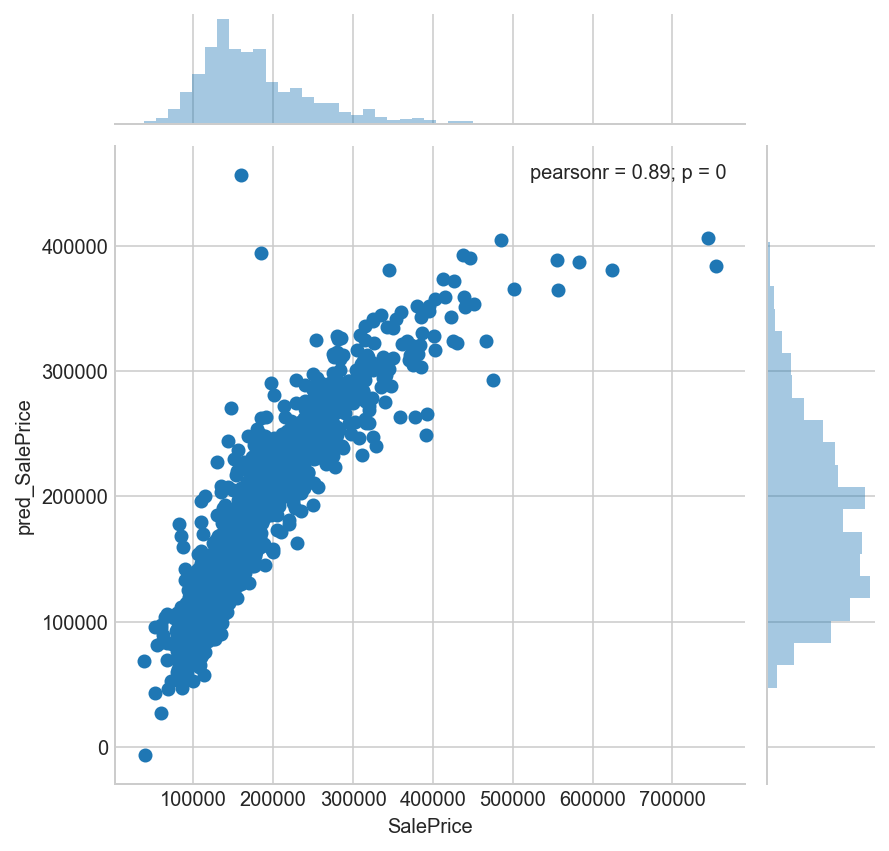

In [43]:
y_pred = ridge.predict(X_train)
y_pred = pd.DataFrame(y_pred)
y_train = y_train.reset_index(drop=True)
y_df = pd.concat([y_train,y_pred],axis=1)
y_df.columns = ['SalePrice', 'pred_SalePrice']
y_df['unexplained_price'] = y_df['SalePrice'] - y_df['pred_SalePrice']
sns.jointplot(y_df['SalePrice'], y_df['pred_SalePrice'], y_df)
#unexplained outliers where saleprice is much greater than predicted saleprice
#explanation could lie in quality, condition, and renovations

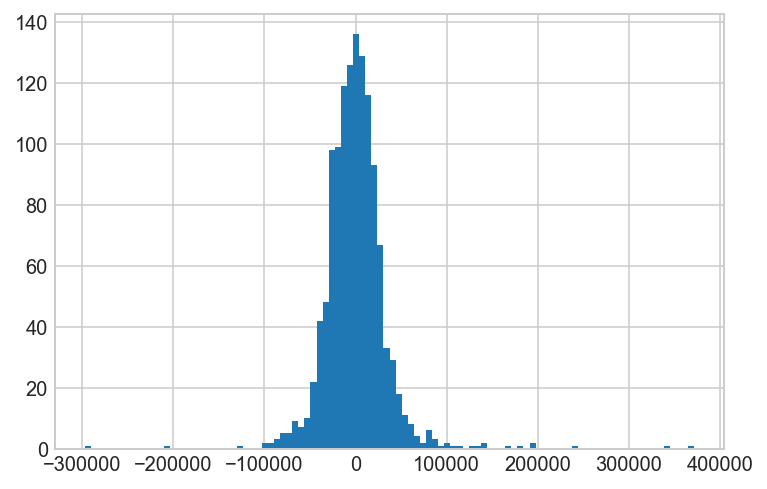

In [44]:
#prediction errors lie in a normal distribution with a few outliers
y_df['unexplained_price'].hist(bins=100)

In [45]:
#getting non fixed characteristics (easy-to-change aspects) of the property into dataframe
df_etc = df.iloc[:,df.columns.isin(FF)==False]
df_etc[['YrSold']] = df[['YrSold']] 

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [46]:
#get those before 2010 to concatenate with predicted saleprice and price error
train_etc = df_etc[df_etc['YrSold']<2010]
test_etc = df_etc[df_etc['YrSold']>=2010]
 
train_etc.reset_index(drop=True, inplace=True)
train_etc = pd.concat([train_etc,y_df['unexplained_price']], axis=1)
train_etc.head()

OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0            7            5       2003          2003     Gable  CompShg   
1            6            8       1976          1976     Gable  CompShg   
2            7            5       2001          2002     Gable  CompShg   
3            7            5       1915          1970     Gable  CompShg   
4            8            5       2000          2000     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType  MasVnrArea        ...          \
0     VinylSd     VinylSd    BrkFace       196.0        ...           
1     MetalSd     MetalSd       None         0.0        ...           
2     VinylSd     VinylSd    BrkFace       162.0        ...           
3     Wd Sdng      Others       None         0.0        ...           
4     VinylSd     VinylSd    BrkFace       350.0        ...           

  Functional FireplaceQu GarageType GarageYrBlt GarageQual GarageCond PoolQC  \
0        Typ         NaN     Attchd      2003.0         TA         TA    NaN   
1        Typ          TA     Attchd      1976.0         TA         TA    NaN   
2        Typ          TA     Attchd      2001.0         TA         TA    NaN   
3        Typ          Gd     Detchd      1998.0         TA         TA    NaN   
4        Typ          TA     Attchd      2000.0         TA         TA    NaN   

   GarageYrBlt_tosale YrSold  unexplained_price  
0                 5.0   2008        1182.827468  
1                31.0   2007        2600.017987  
2                 7.0   2008        5034.358445  
3                 8.0   2006      -52643.053184  
4                 8.0   2008      -27772.148113  

[5 rows x 37 columns]

In [47]:
train_etc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 37 columns):
OverallQual           1271 non-null int64
OverallCond           1271 non-null int64
YearBuilt             1271 non-null int64
YearRemodAdd          1271 non-null int64
RoofStyle             1271 non-null object
RoofMatl              1271 non-null object
Exterior1st           1271 non-null object
Exterior2nd           1271 non-null object
MasVnrType            1271 non-null object
MasVnrArea            1271 non-null float64
ExterQual             1271 non-null object
ExterCond             1271 non-null object
Foundation            1271 non-null object
BsmtQual              1239 non-null object
BsmtCond              1239 non-null object
BsmtExposure          1238 non-null object
BsmtFinType1          1239 non-null object
BsmtFinSF1            1271 non-null int64
BsmtFinType2          1238 non-null object
BsmtFinSF2            1271 non-null int64
BsmtUnfSF             1271 non-null in

In [48]:
#replace null values with 0 since quality and condition null values represent the absent of the feature
train_etc = train_etc.fillna(0)
#drop unwanted columns not relevant to features being studied eg. YrSold, YearBuild
train_etc.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','GarageYrBlt_tosale','YrSold'], axis=1, inplace=True)

In [49]:
obj_col = []
cont_col = []
for c in train_etc.columns:
    if train_etc[c].dtype == 'O':
        obj_col.append(c)
    else:
        cont_col.append(c)
train_etc_obj = train_etc[obj_col]
train_etc_cont = train_etc[cont_col].drop('unexplained_price',axis=1)
print 'No. of obj cols:',len(train_etc_obj.columns)
print 'No. of cont cols:',len(train_etc_cont.columns)

No. of obj cols: 24
No. of cont cols: 7


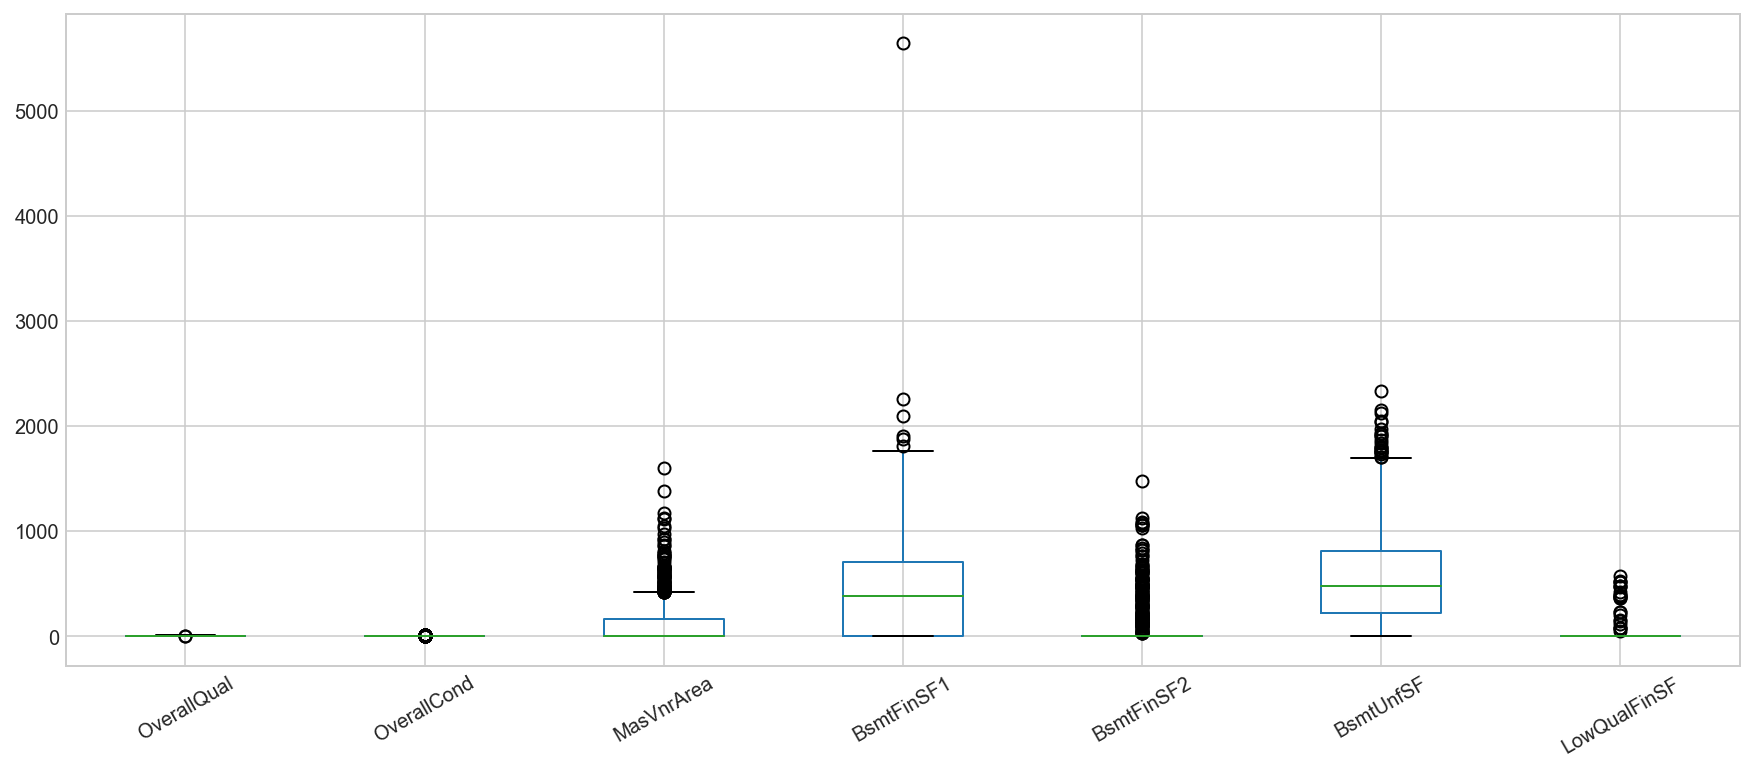

In [50]:
#standardizing continuous variables so as to have a better view of boxplot and distributions
train_etc_conts = StandardScaler().fit_transform(train_etc_cont)
train_etc_conts = pd.DataFrame(train_etc_cont, columns = train_etc_cont.columns.values) 

ax = train_etc_conts.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
#looks like there are presence of lognormal distributions for columns with square feet area

In [51]:
train_etc_cont.columns

Index([u'OverallQual', u'OverallCond', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'LowQualFinSF'],
      dtype='object')

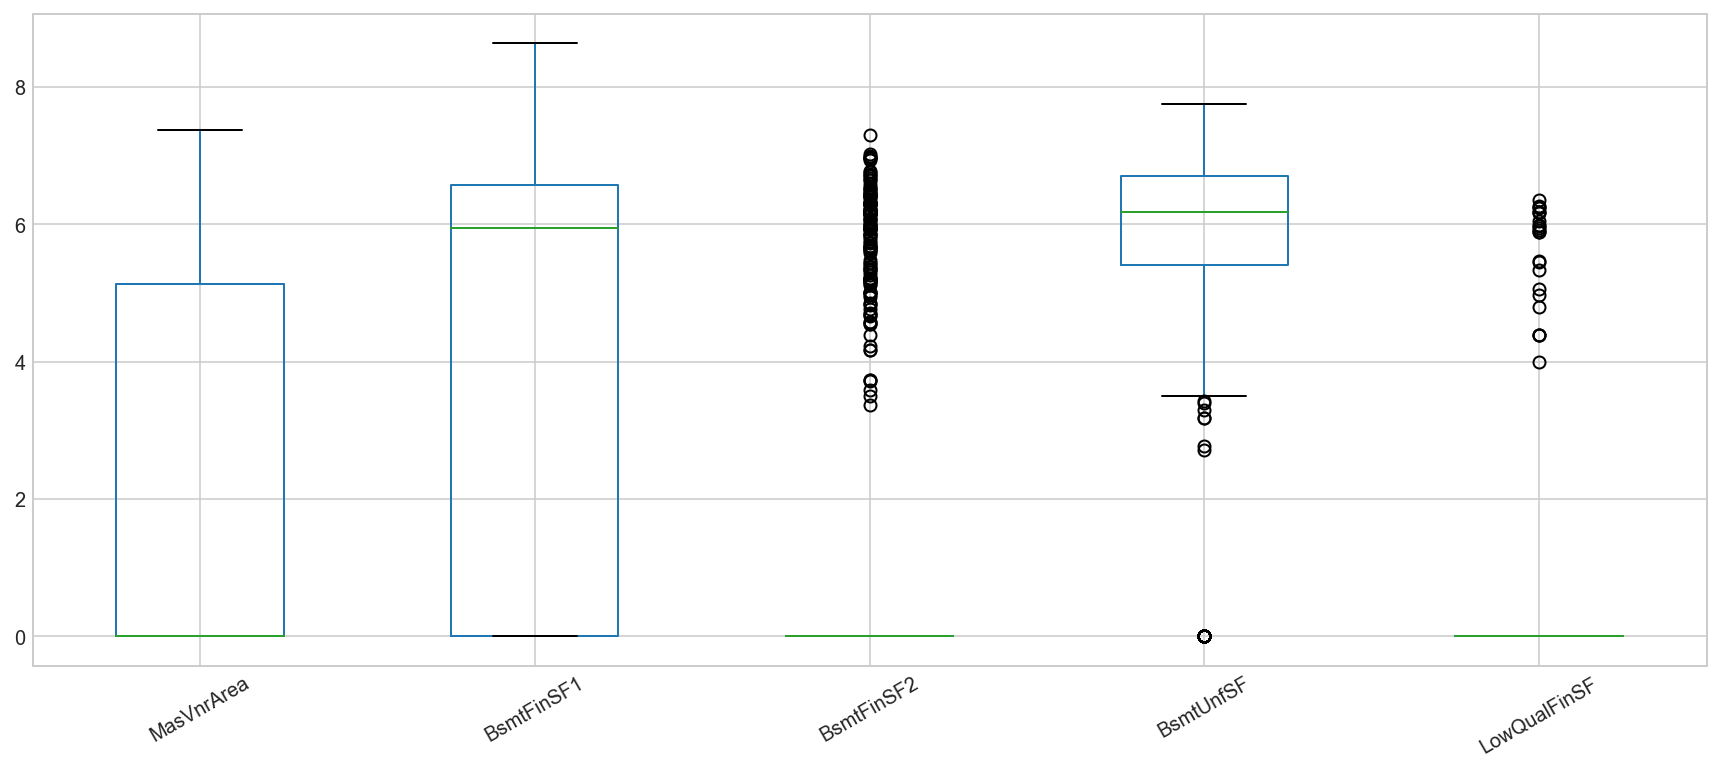

In [52]:
#log selected (area and value) columns of pre-standardized continuous variables, +1 to remove error from np.log(0)
log_train_etc_cont = np.log(train_etc_cont.drop(['OverallQual','OverallCond'], axis=1)+1)

ax = log_train_etc_cont.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [53]:
#finished log-normal transformation, create new dataframe of lognormal and ordered continuous variables before running correlation check
train_etc_cont_new = pd.concat([train_etc_cont.iloc[:,:2],log_train_etc_cont,train_etc['unexplained_price']], axis=1) 
train_etc_cont_new.head()

OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0            7            5    5.283204    6.561031         0.0   5.017280   
1            6            8    0.000000    6.886532         0.0   5.652489   
2            7            5    5.093750    6.188264         0.0   6.075346   
3            7            5    0.000000    5.379897         0.0   6.293419   
4            8            5    5.860786    6.486161         0.0   6.196444   

   LowQualFinSF  unexplained_price  
0           0.0        1182.827468  
1           0.0        2600.017987  
2           0.0        5034.358445  
3           0.0      -52643.053184  
4           0.0      -27772.148113

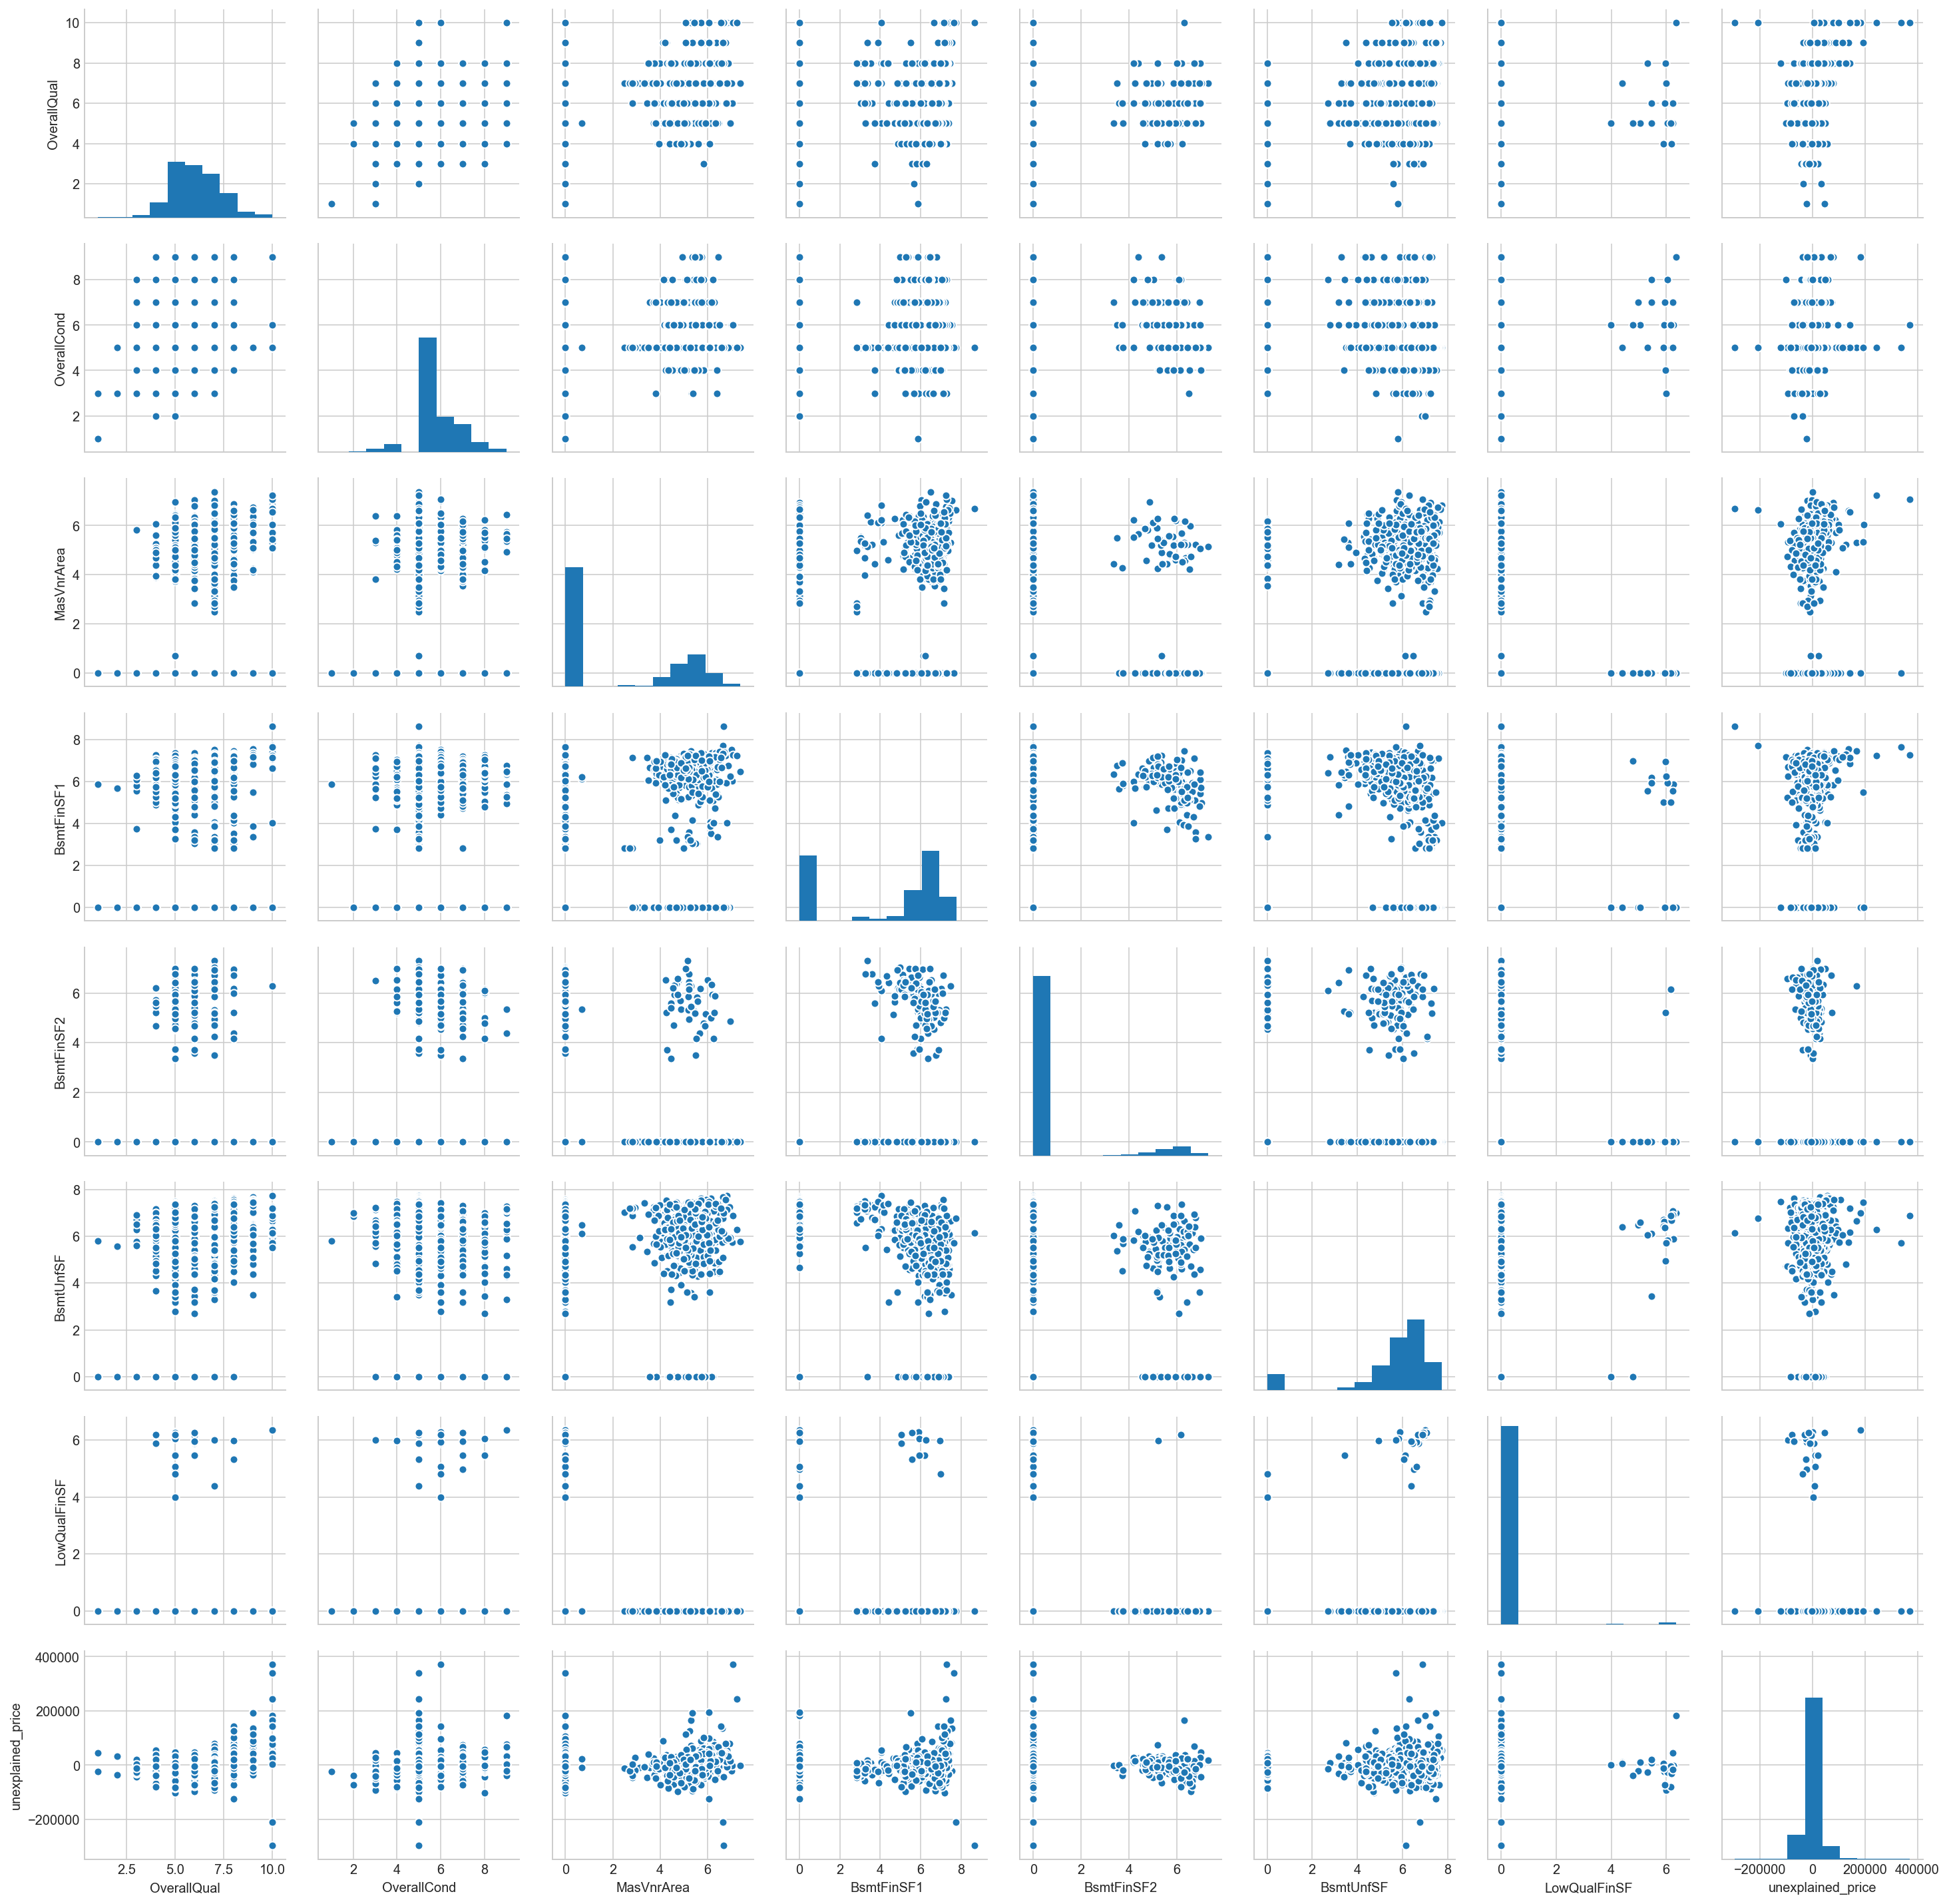

In [54]:
sns.pairplot(train_etc_cont_new)
#relationship of unexplained prices with the continuous variables aren't very strong

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


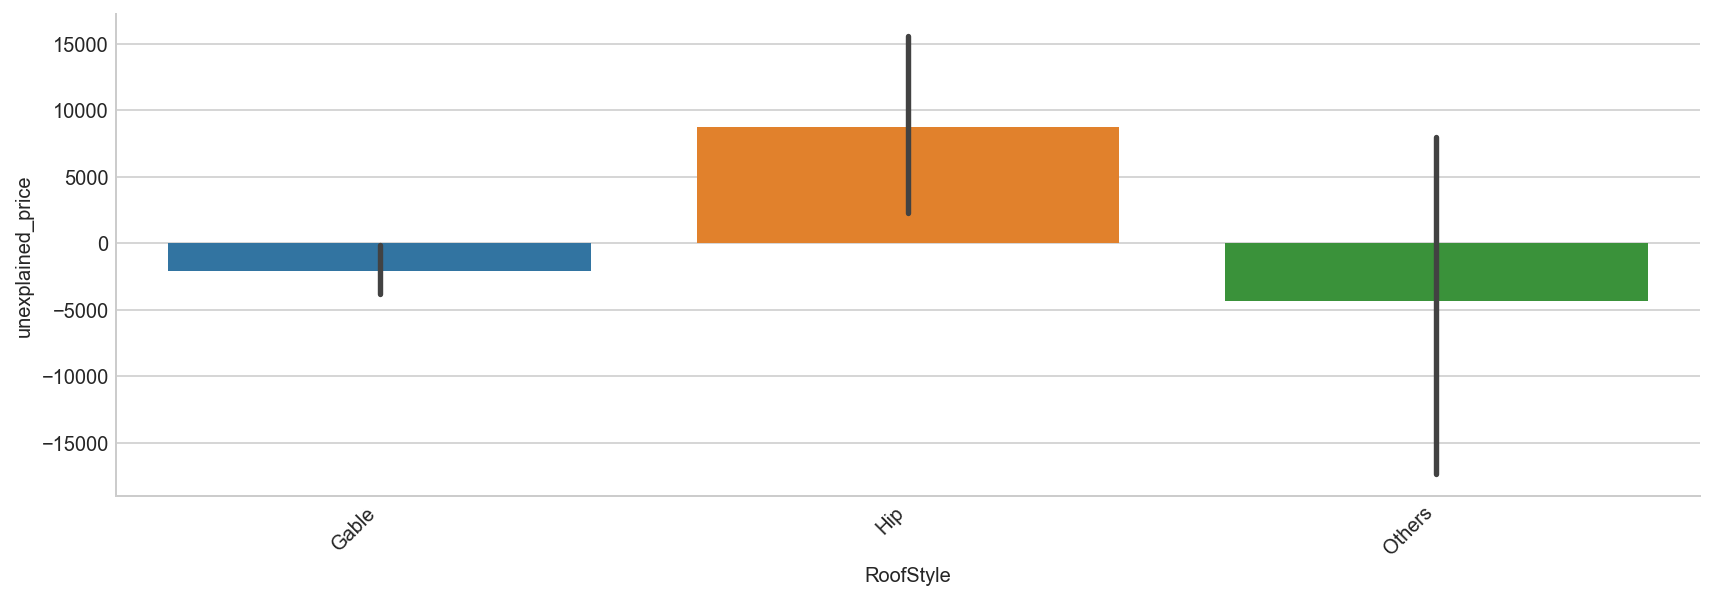

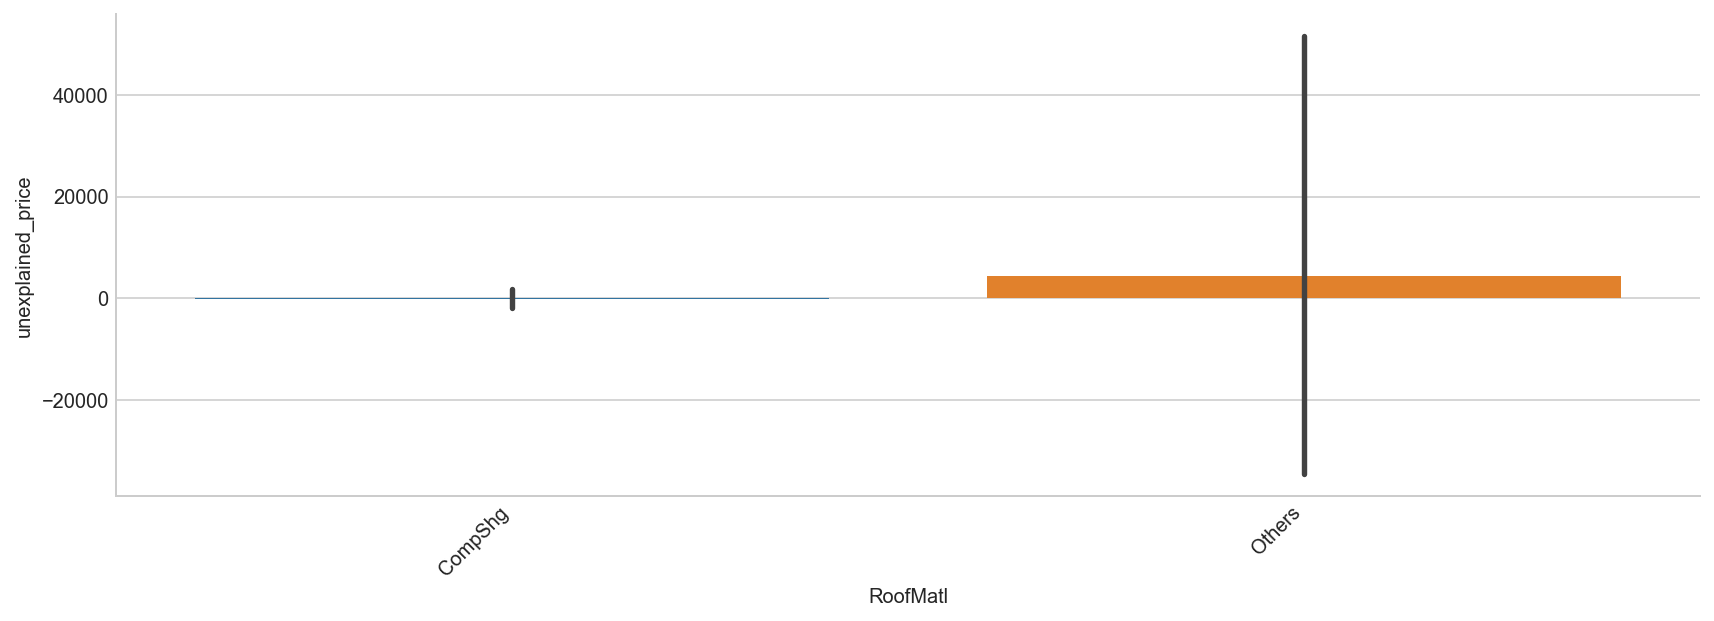

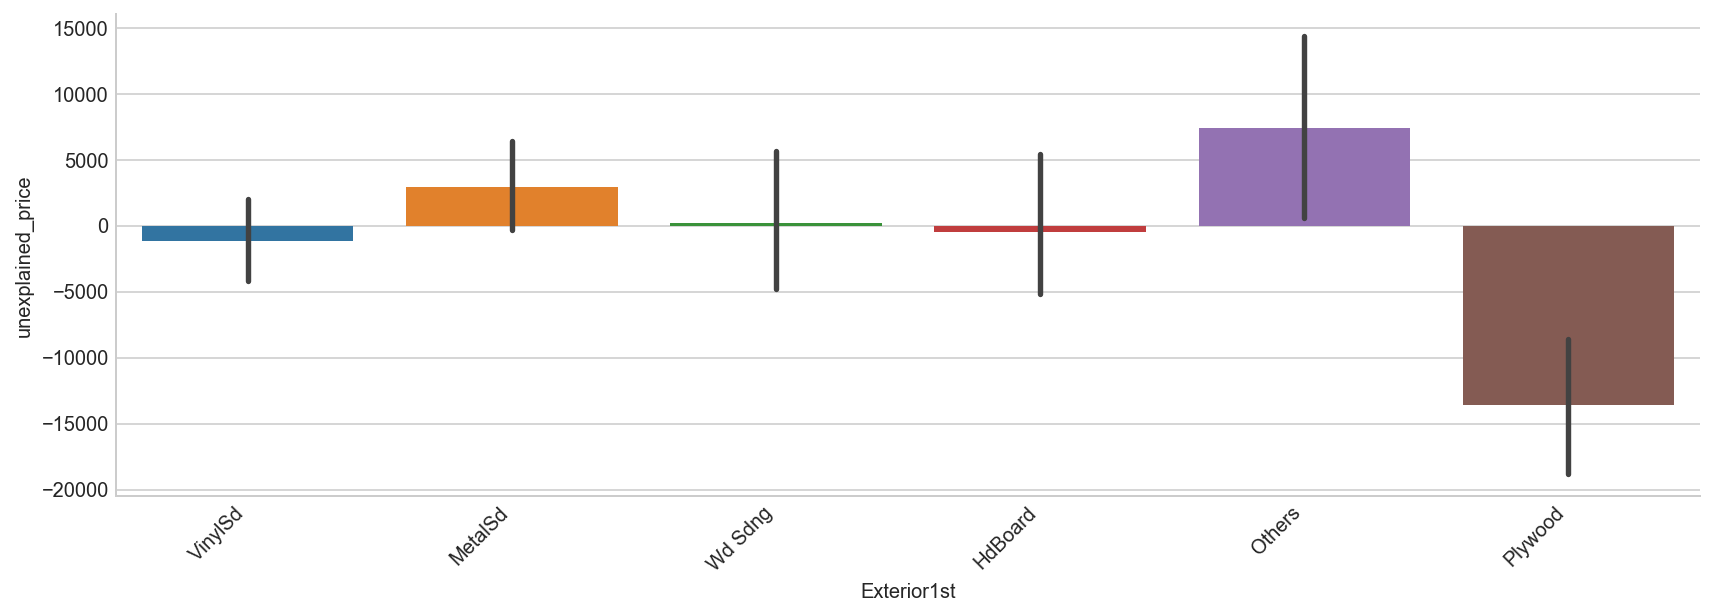

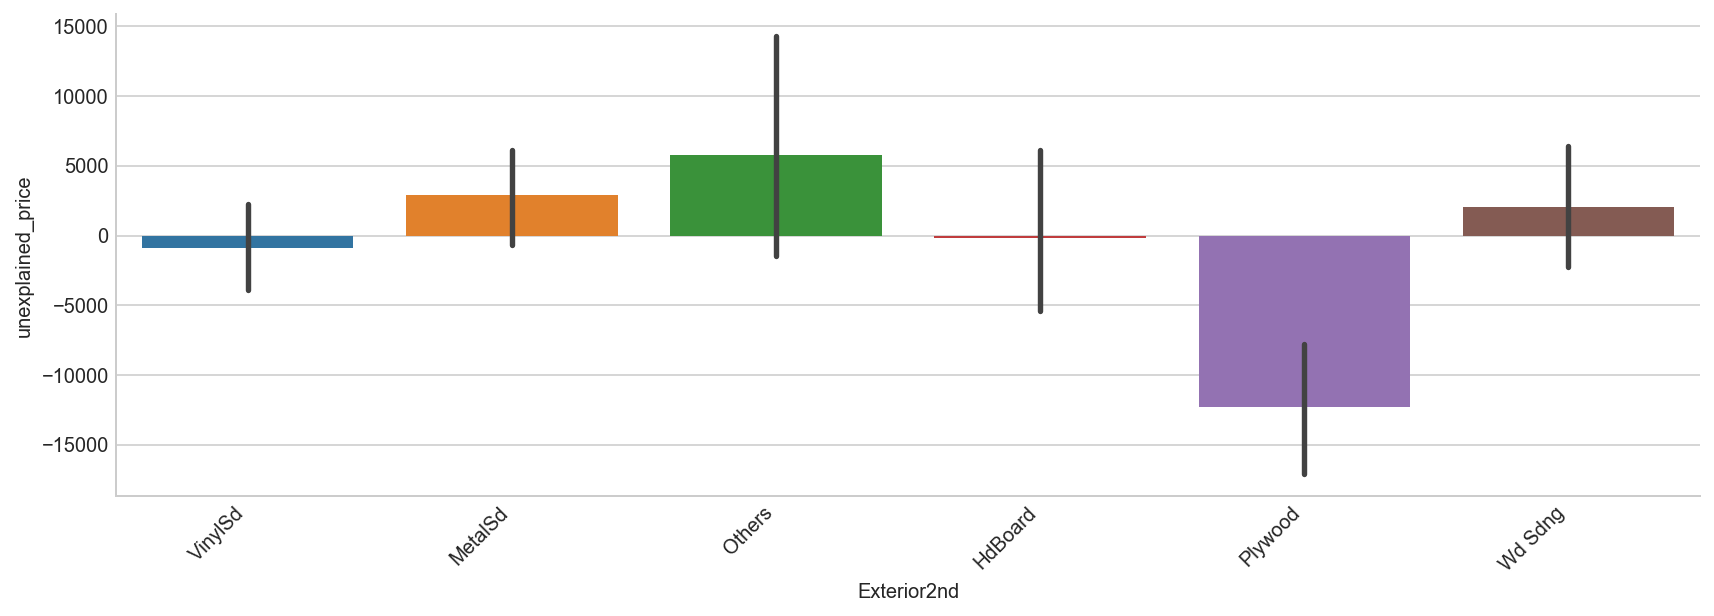

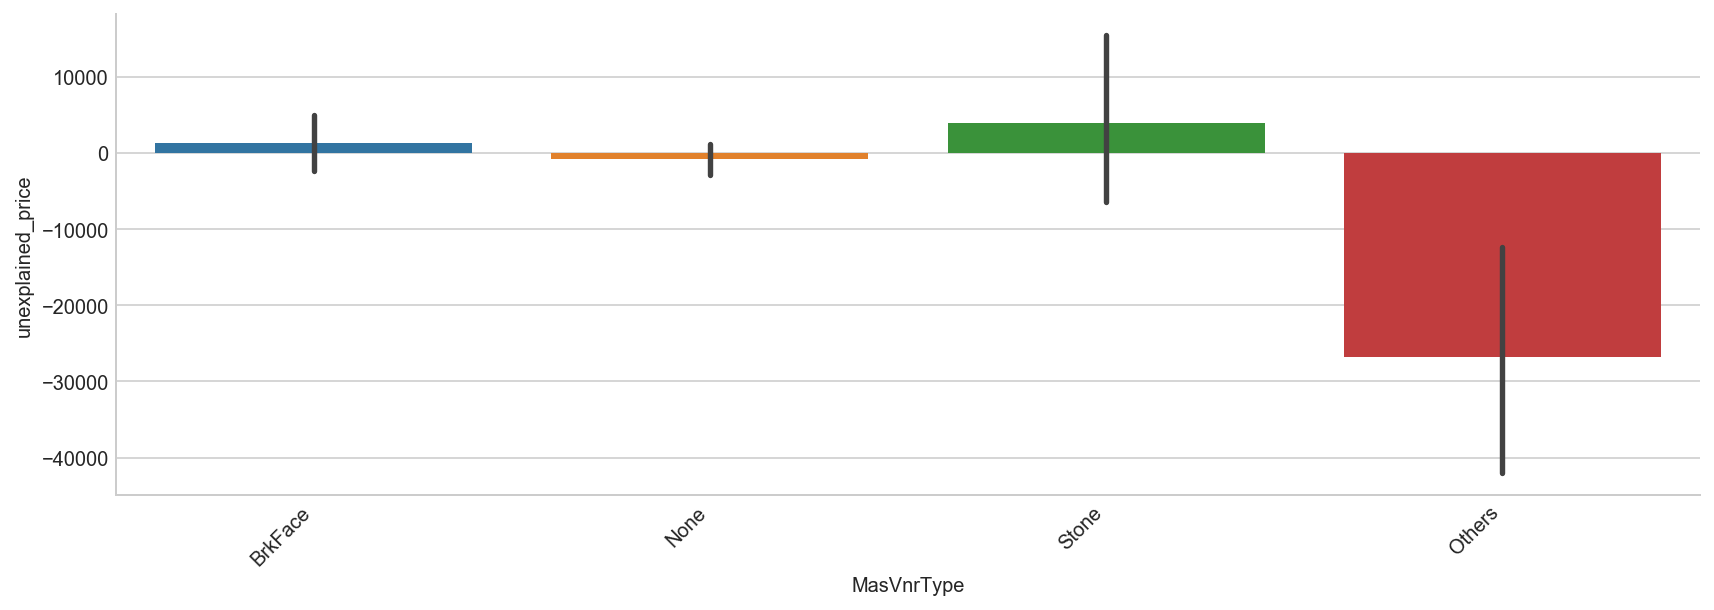

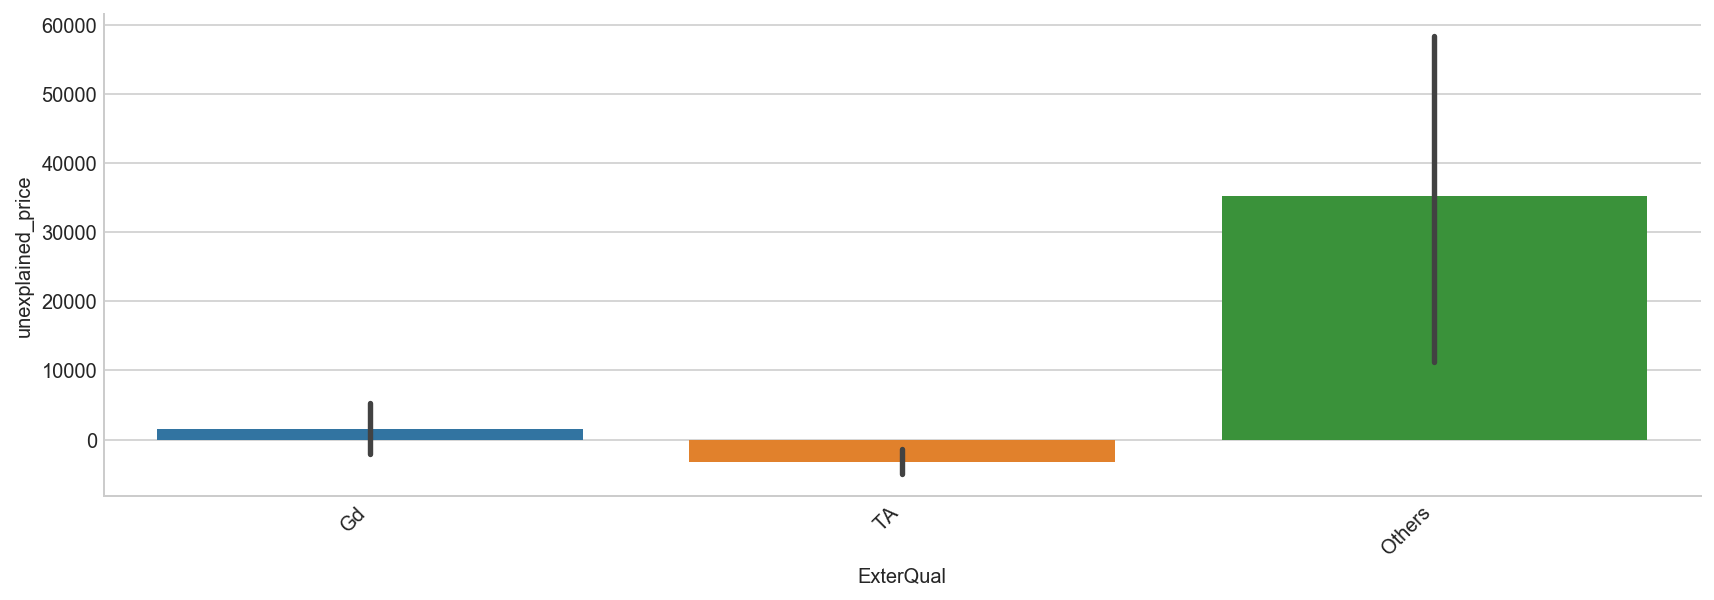

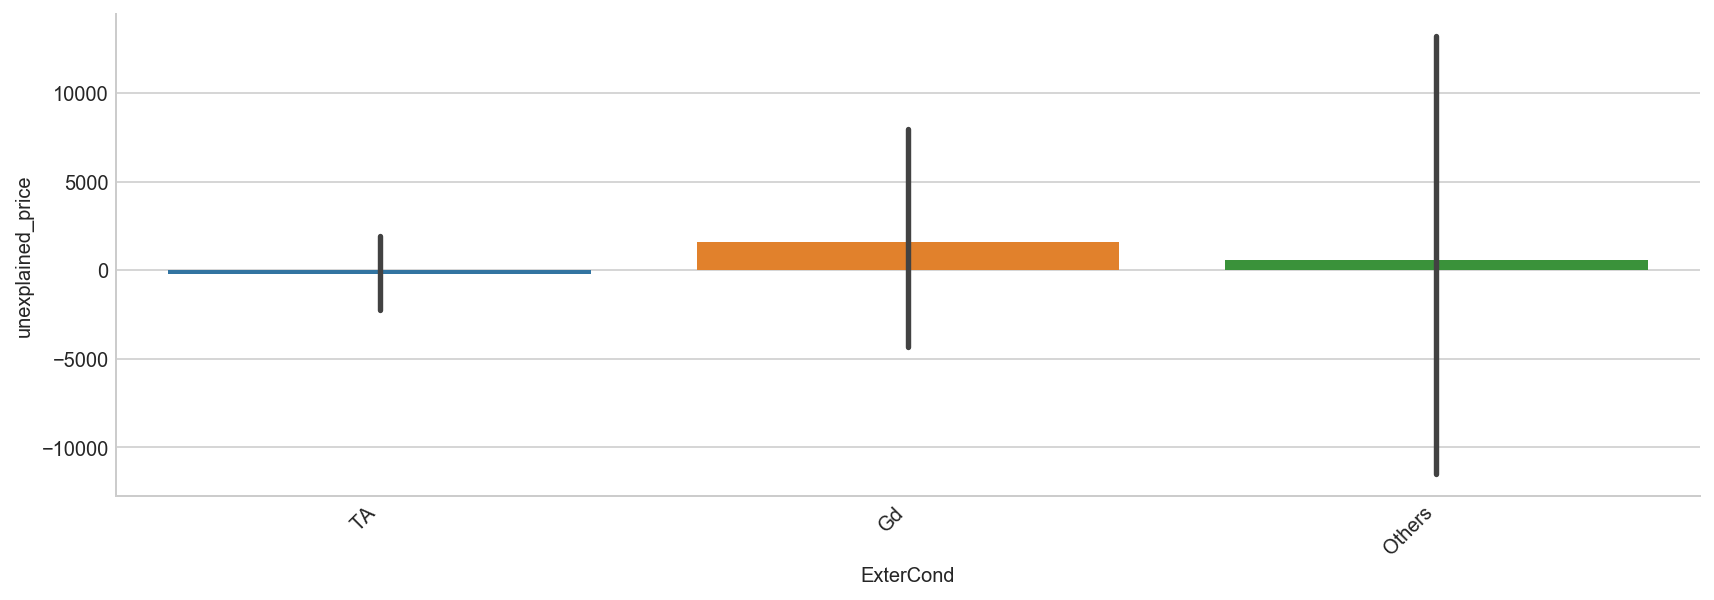

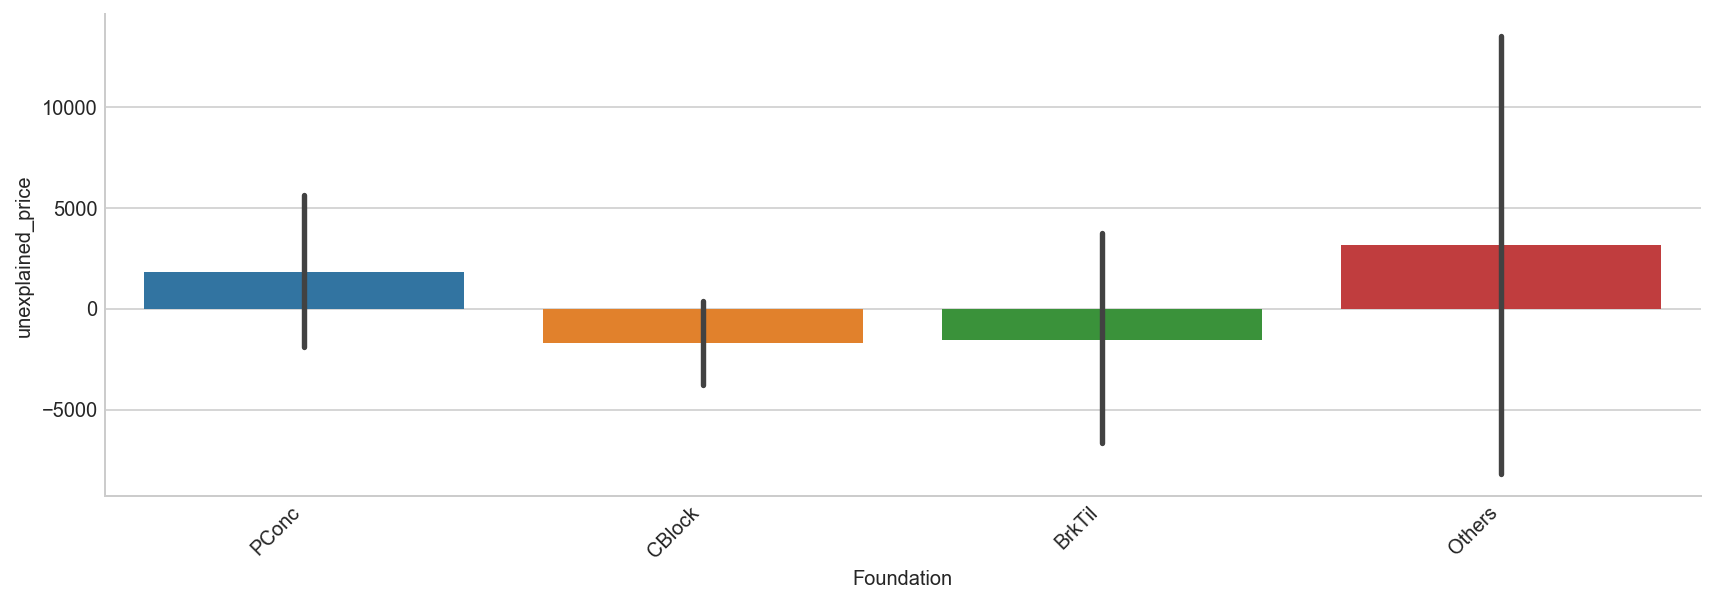

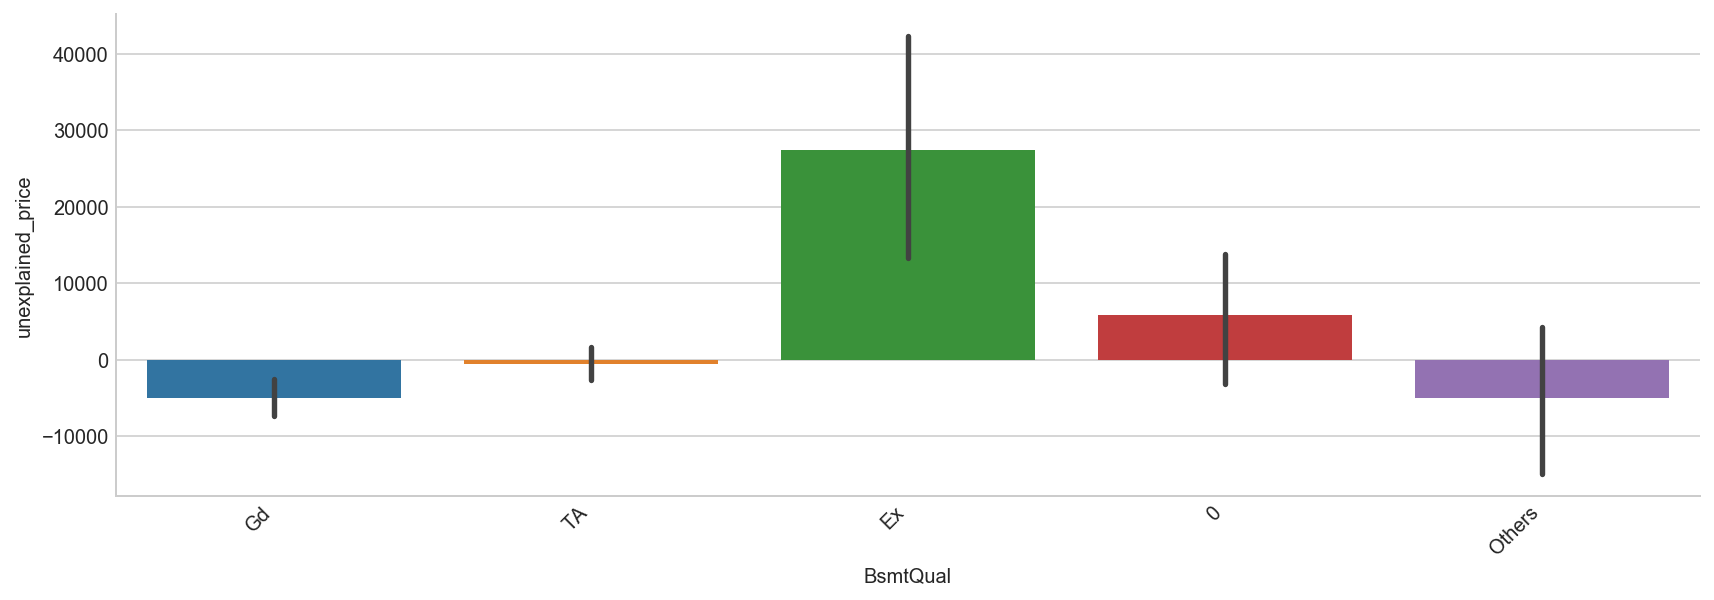

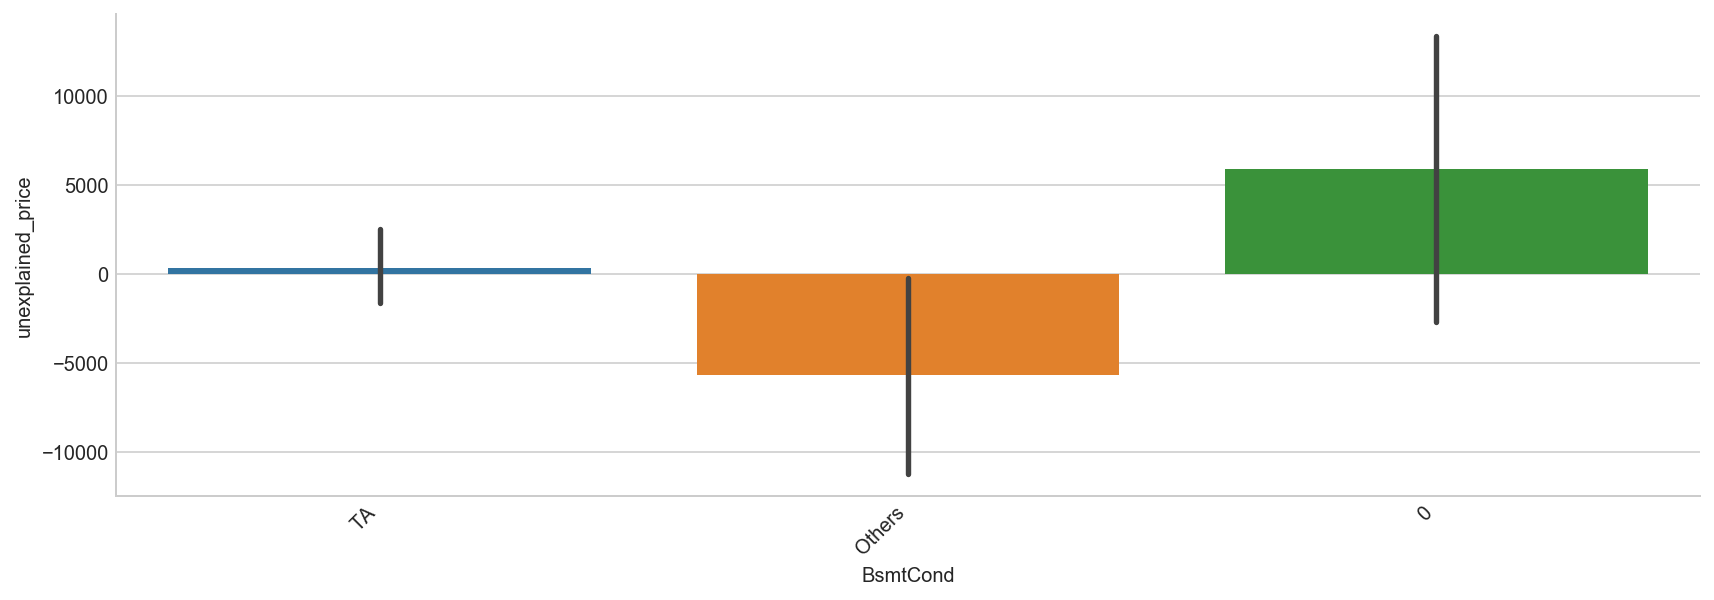

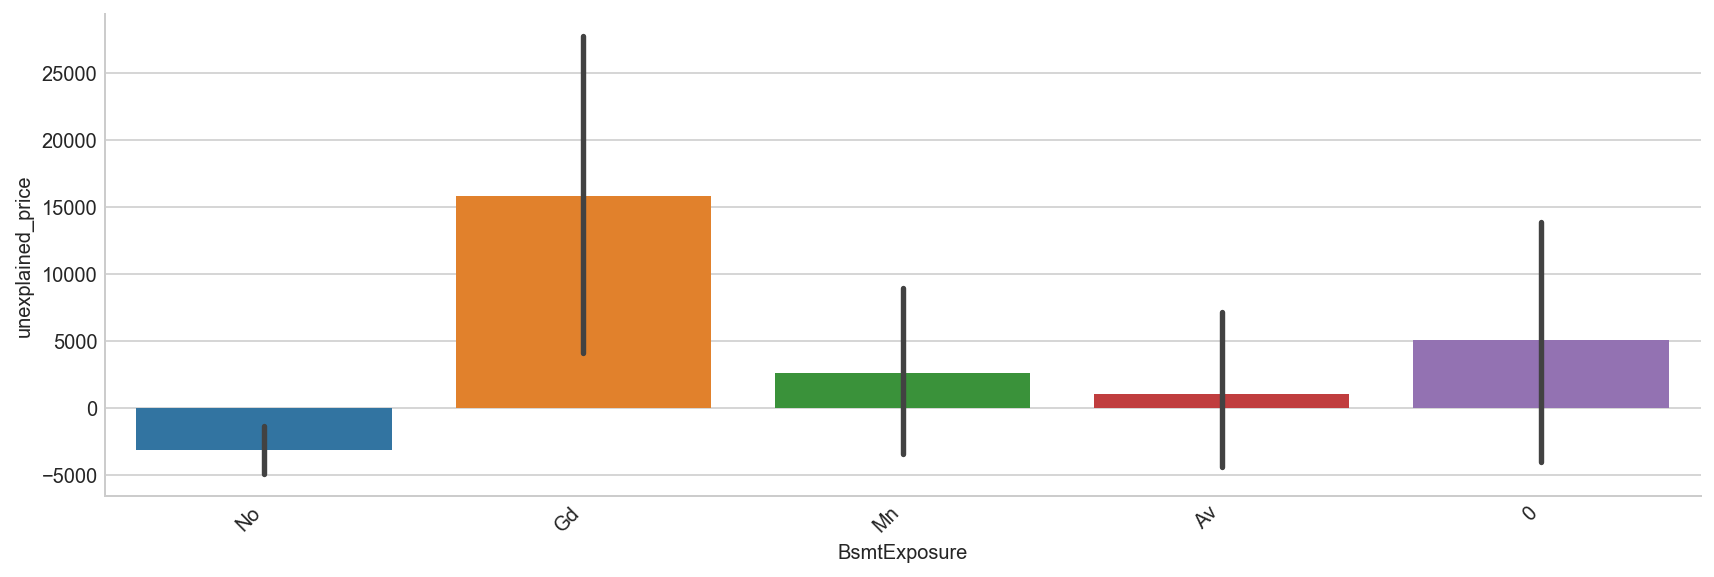

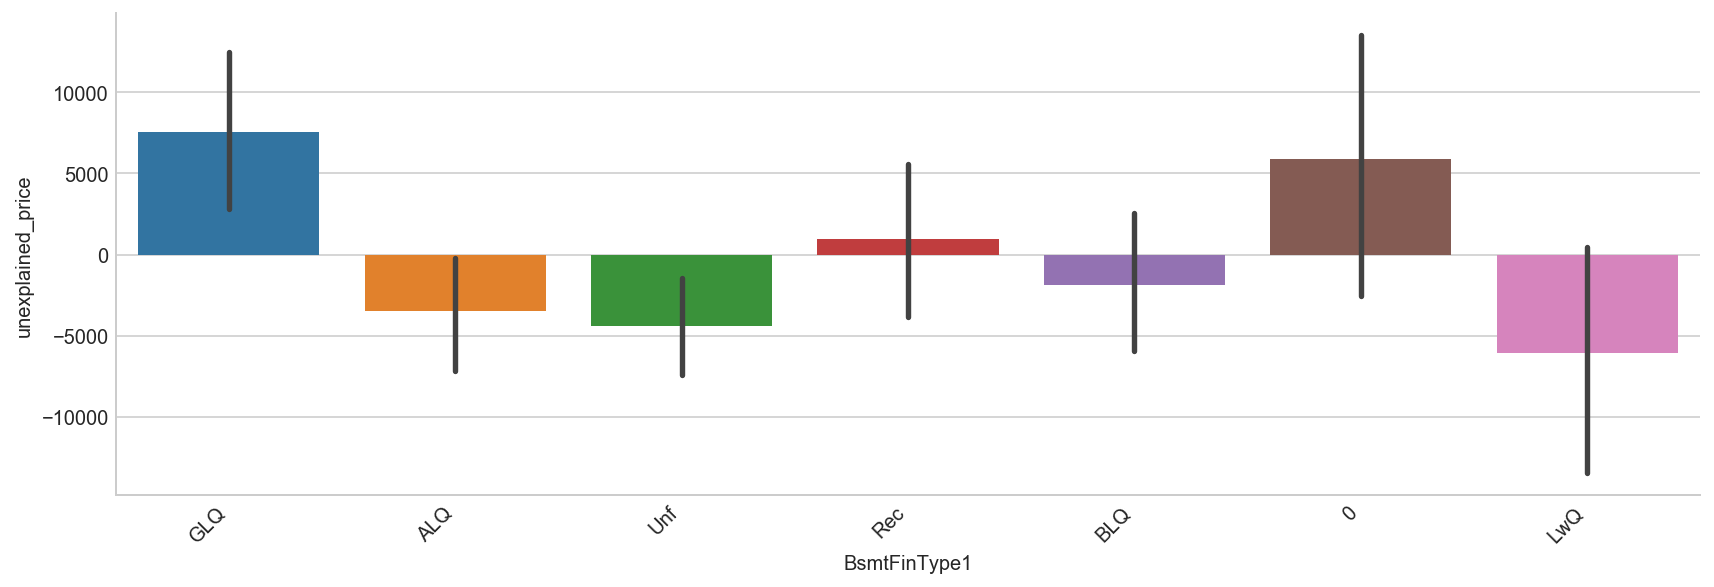

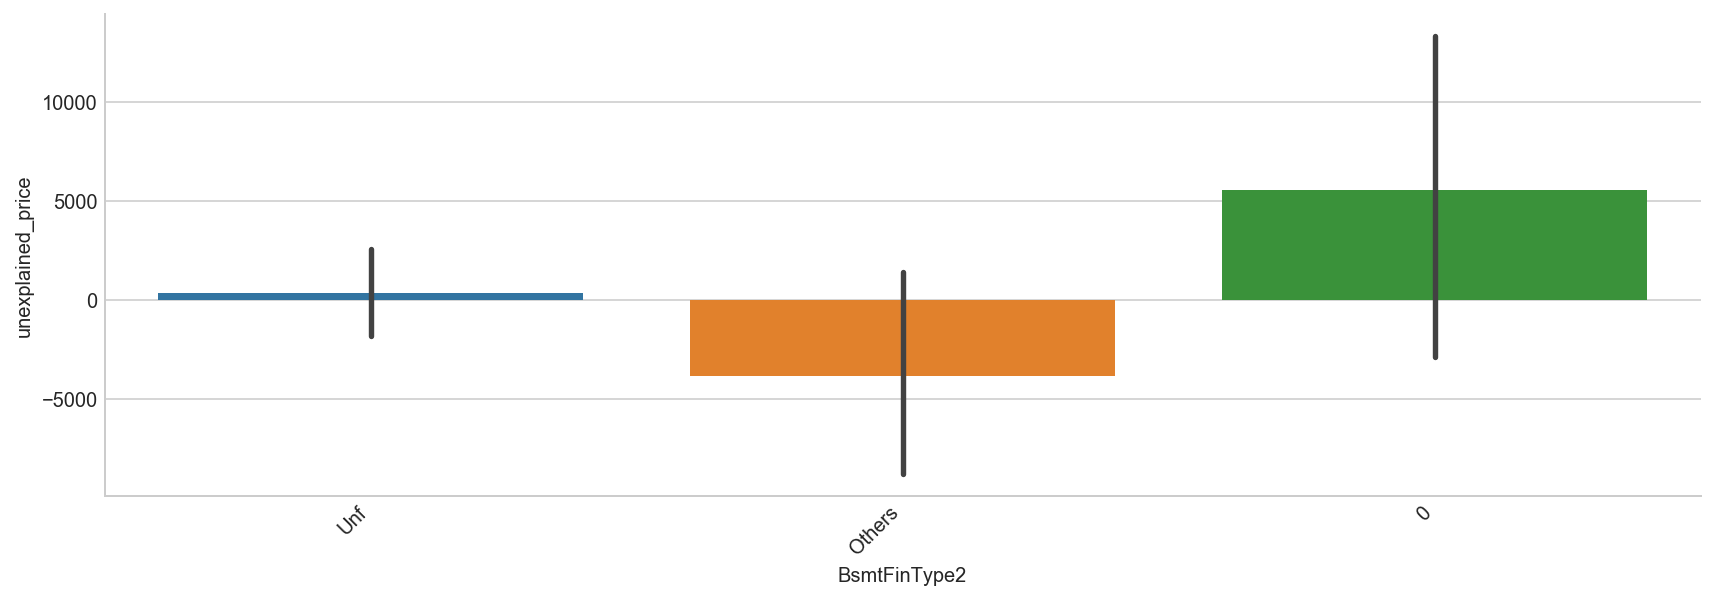

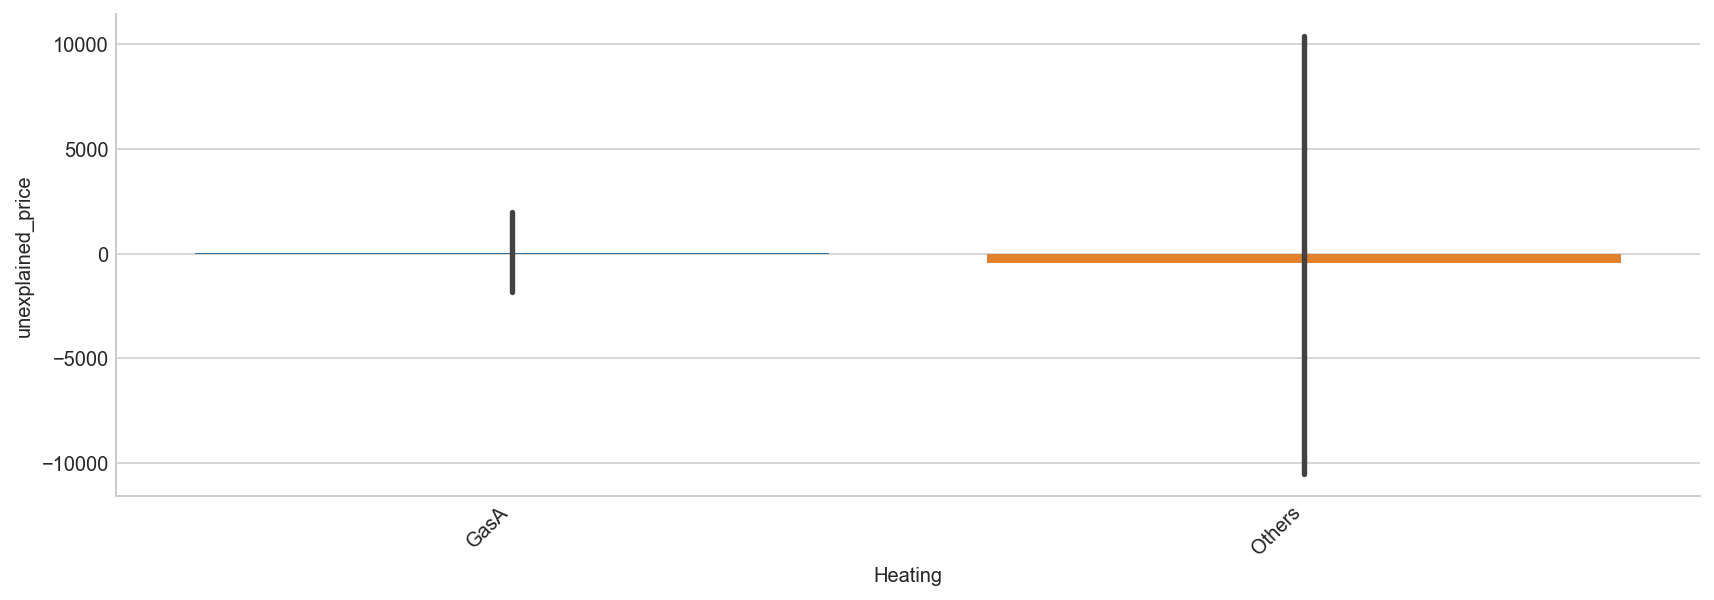

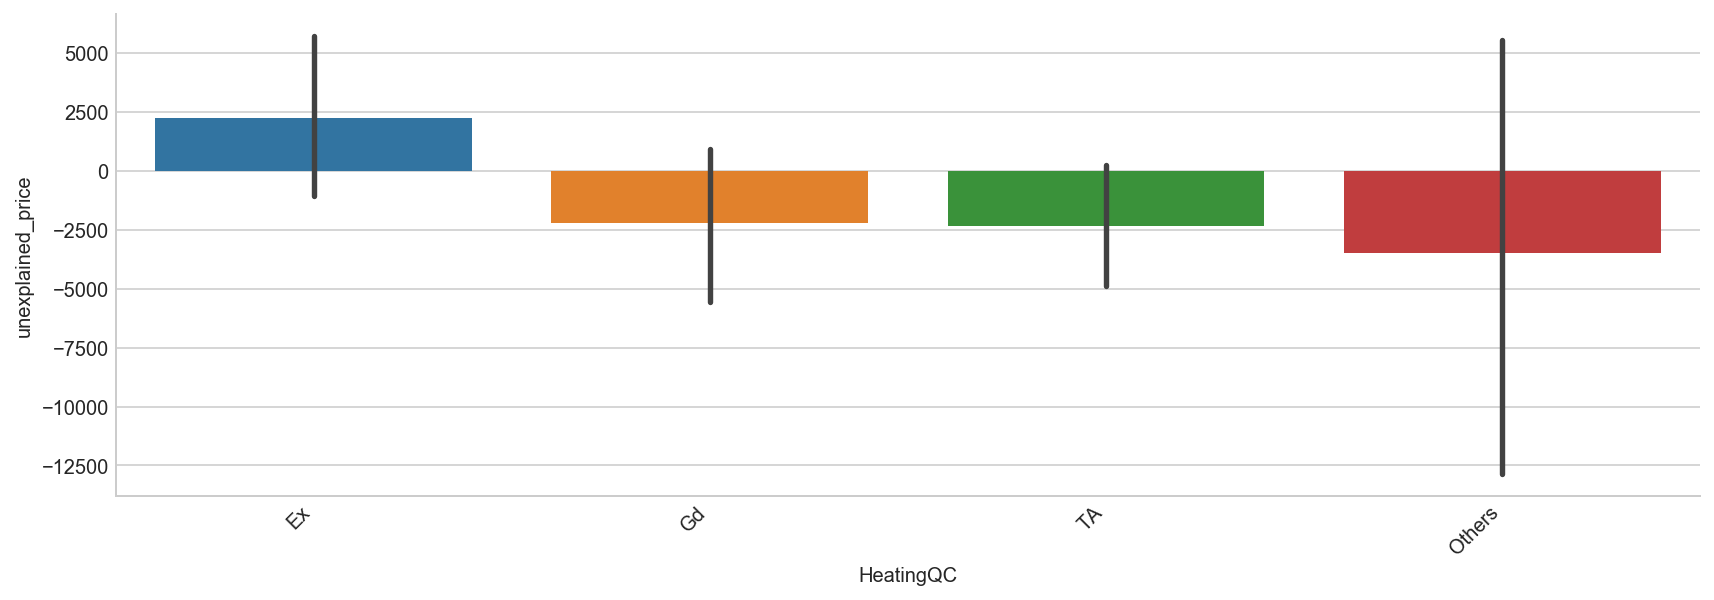

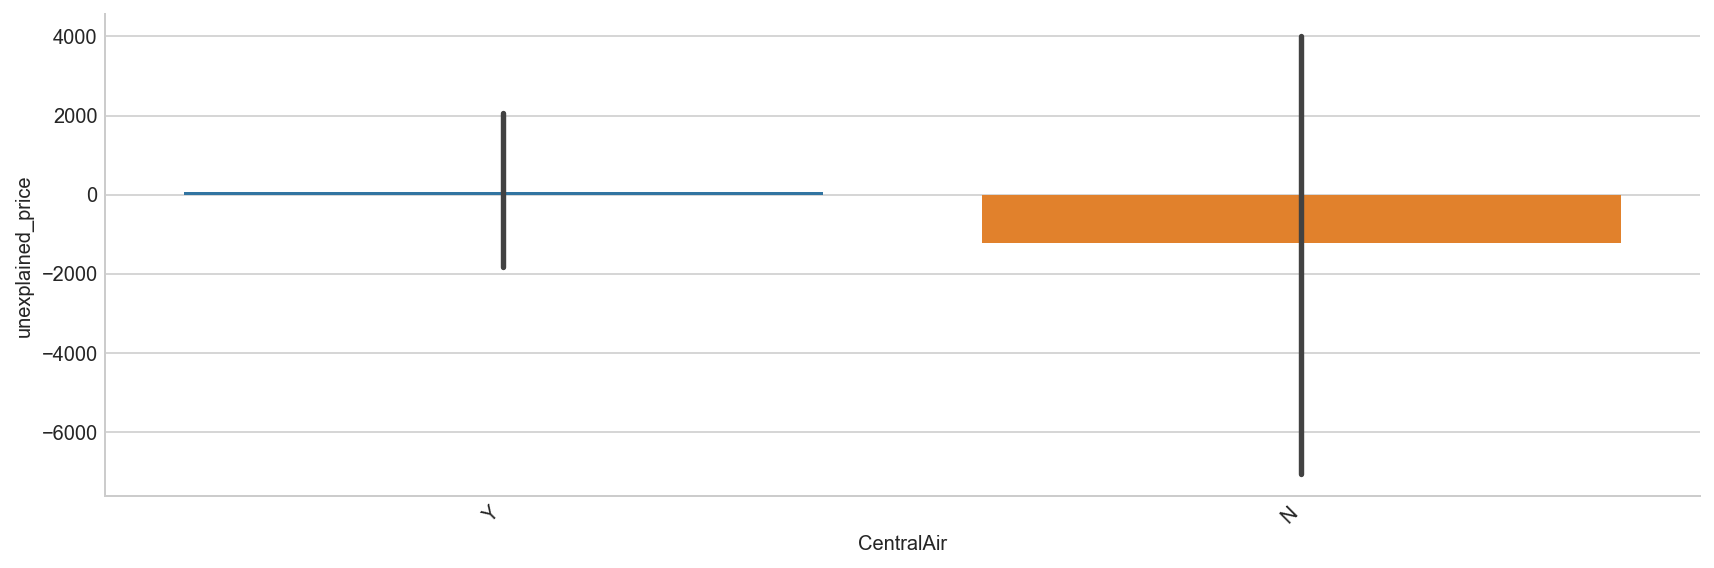

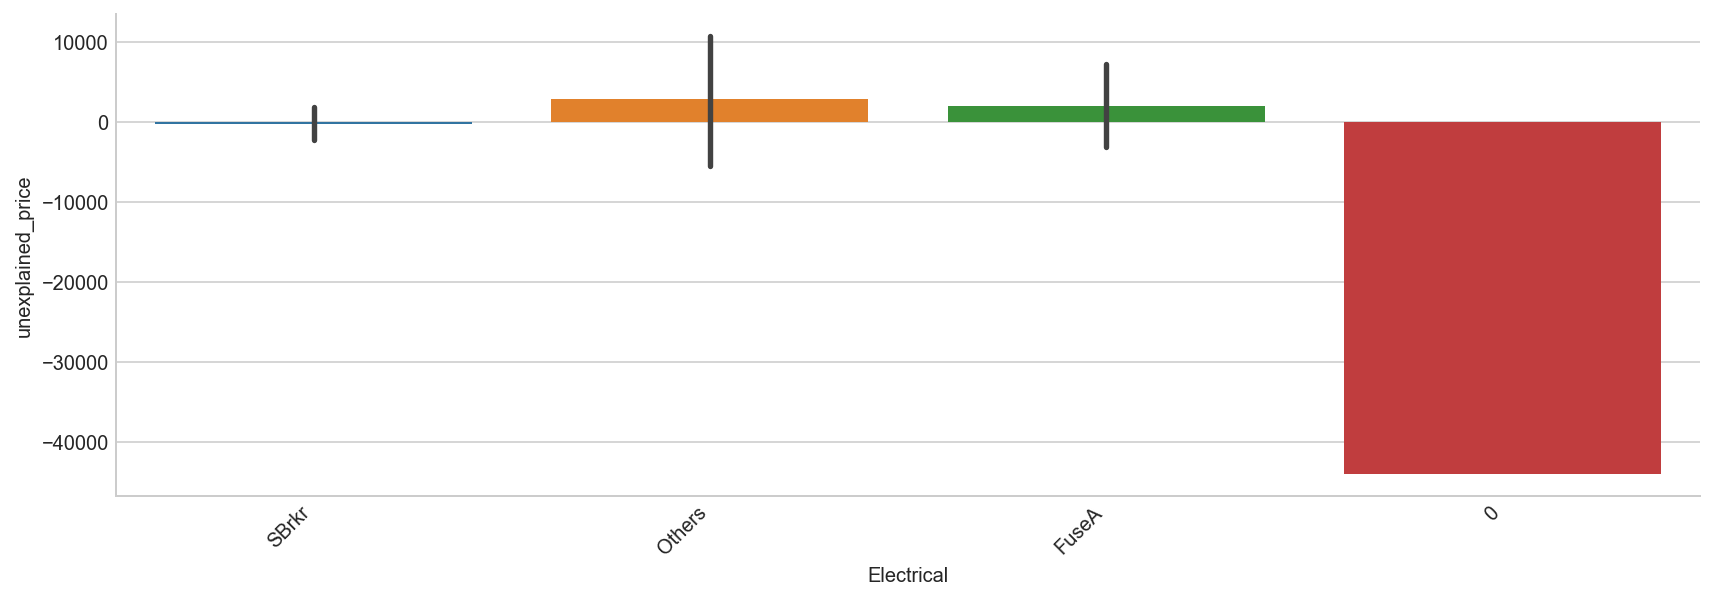

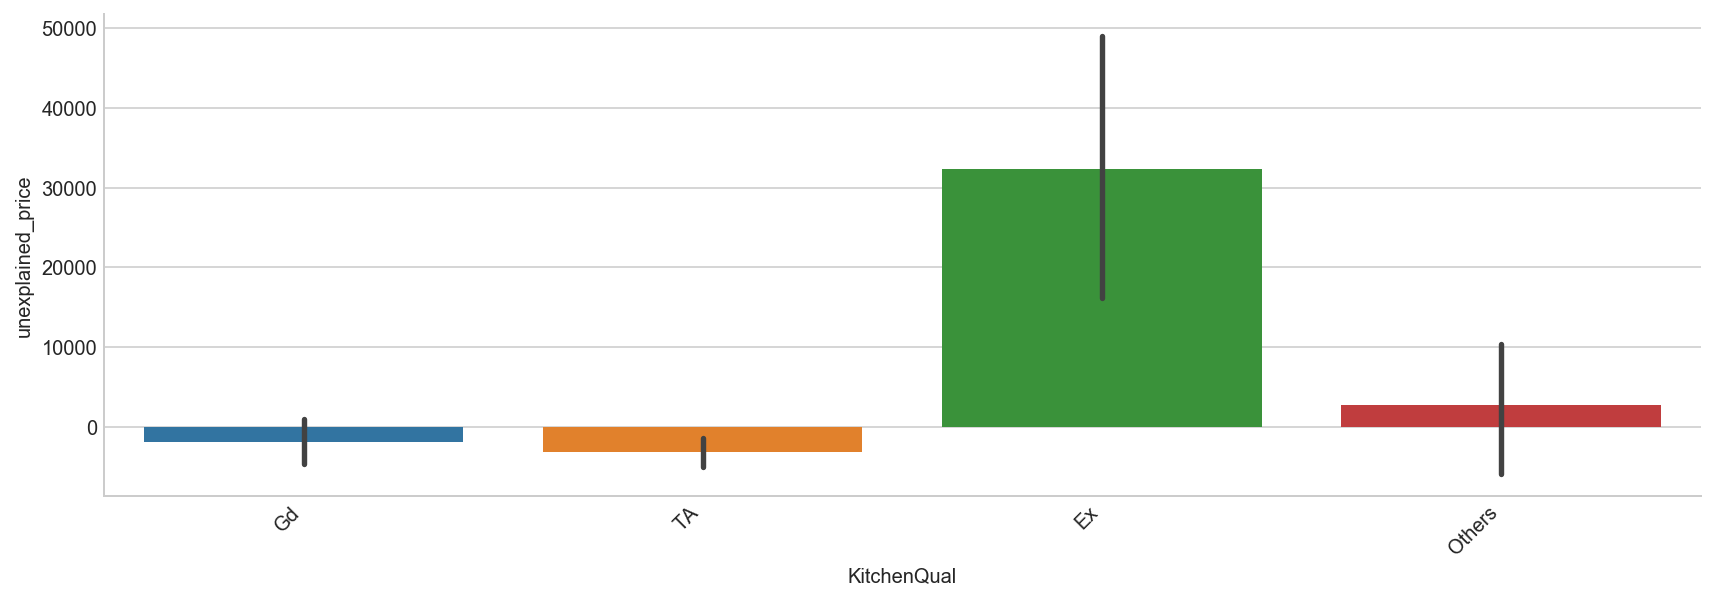

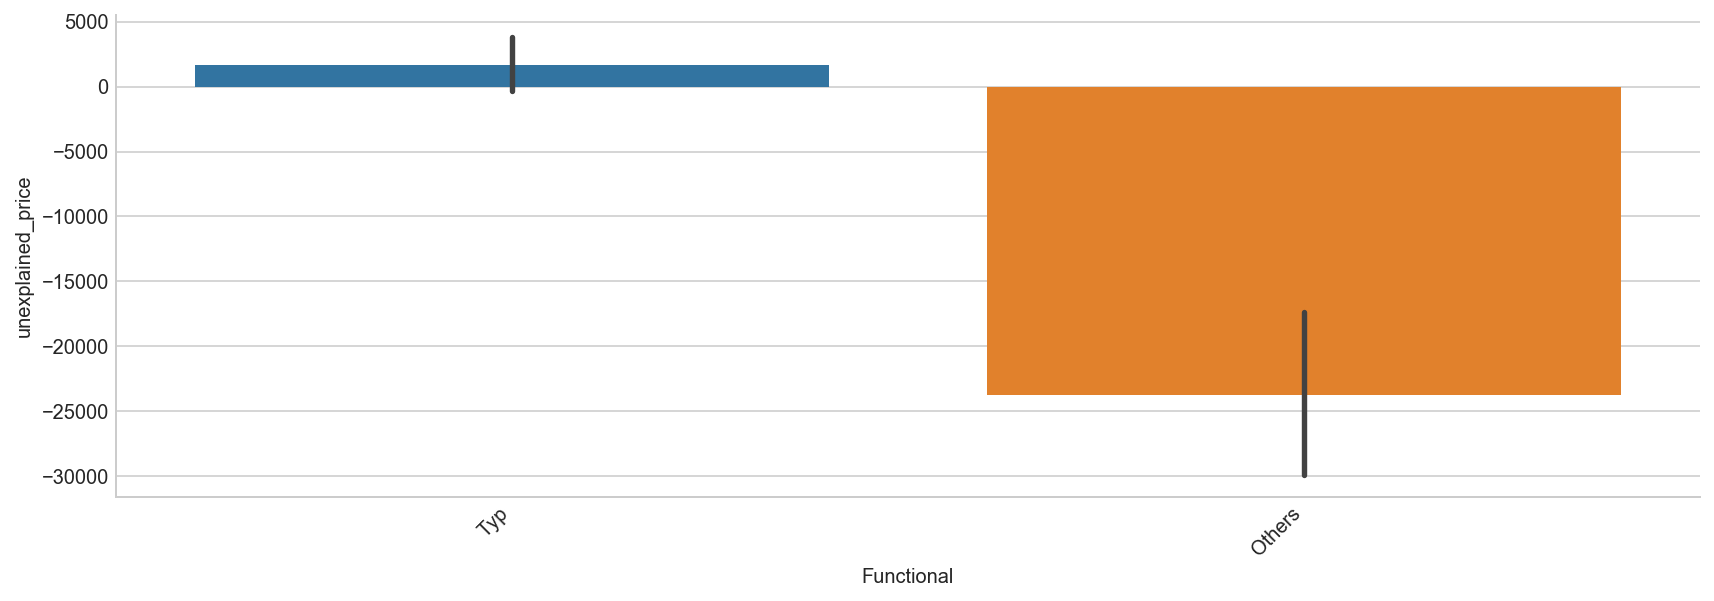

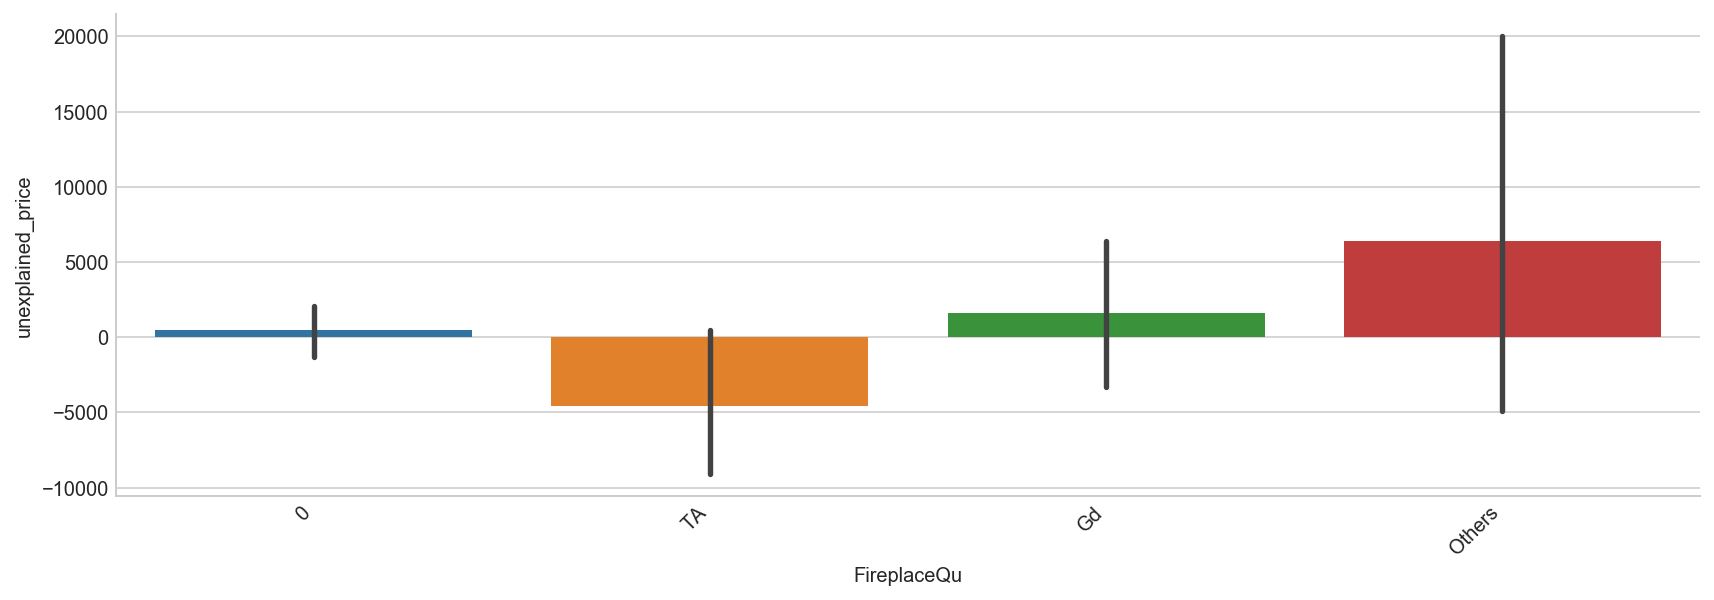

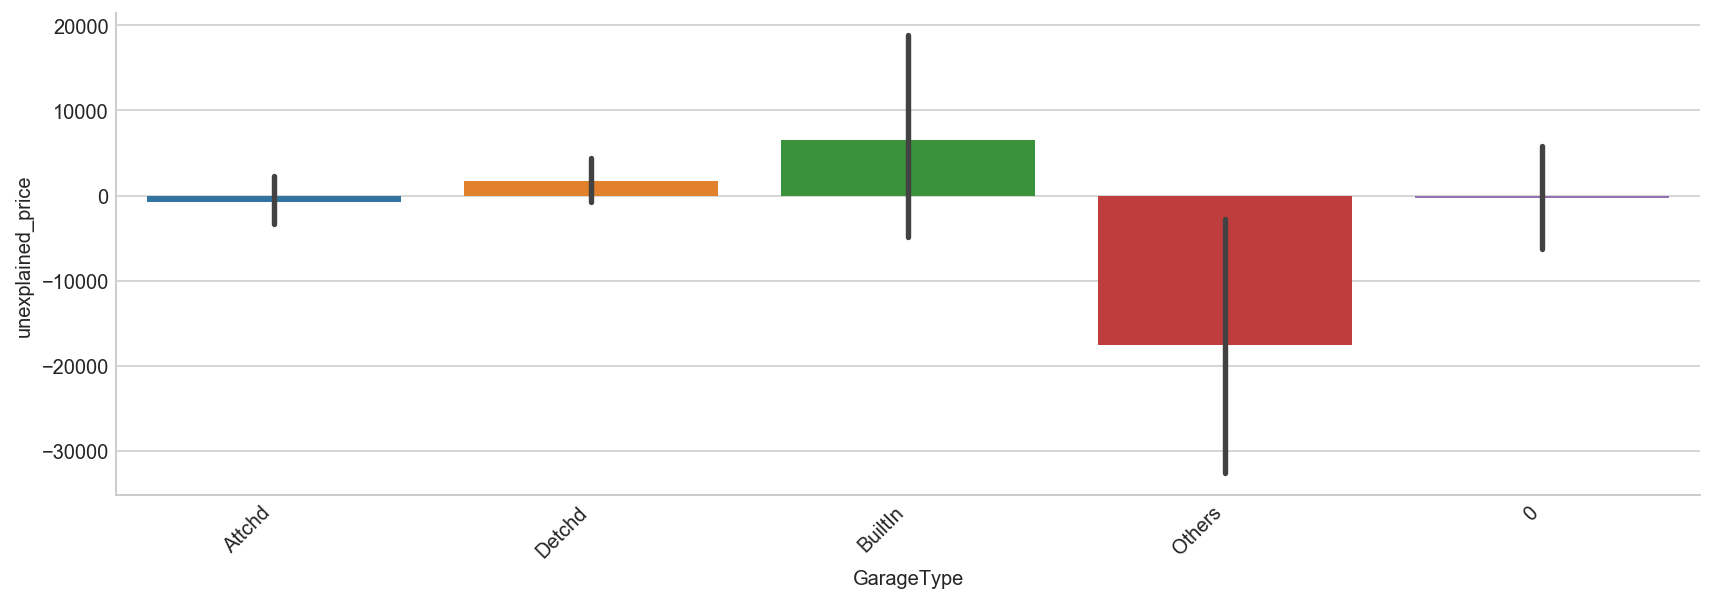

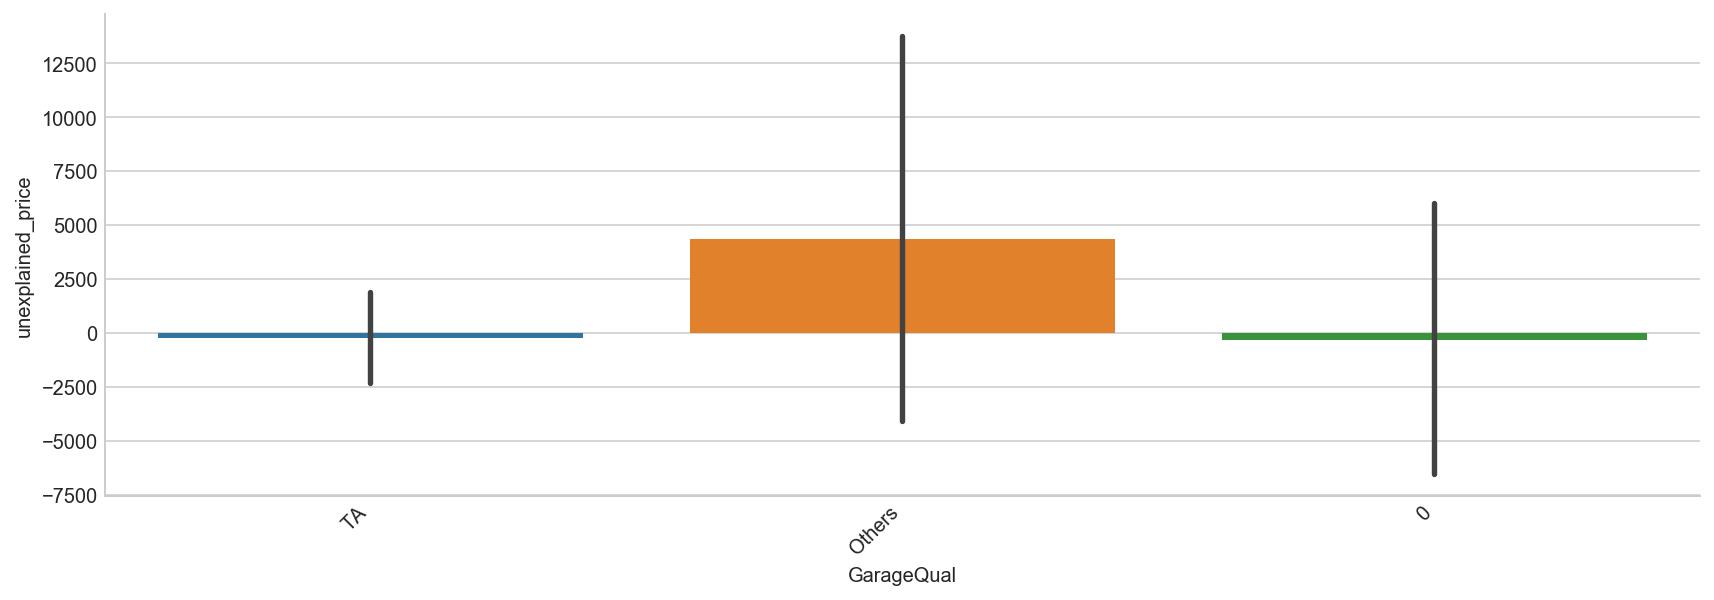

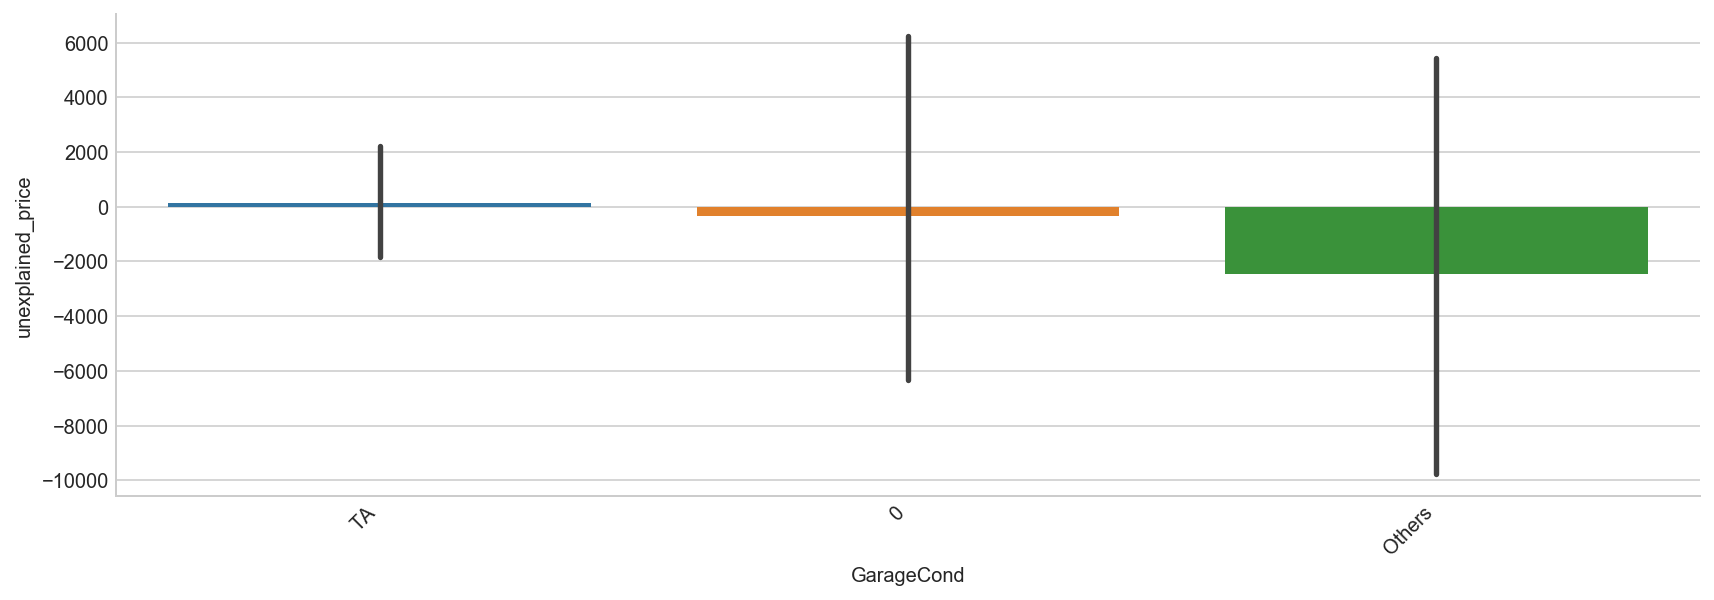

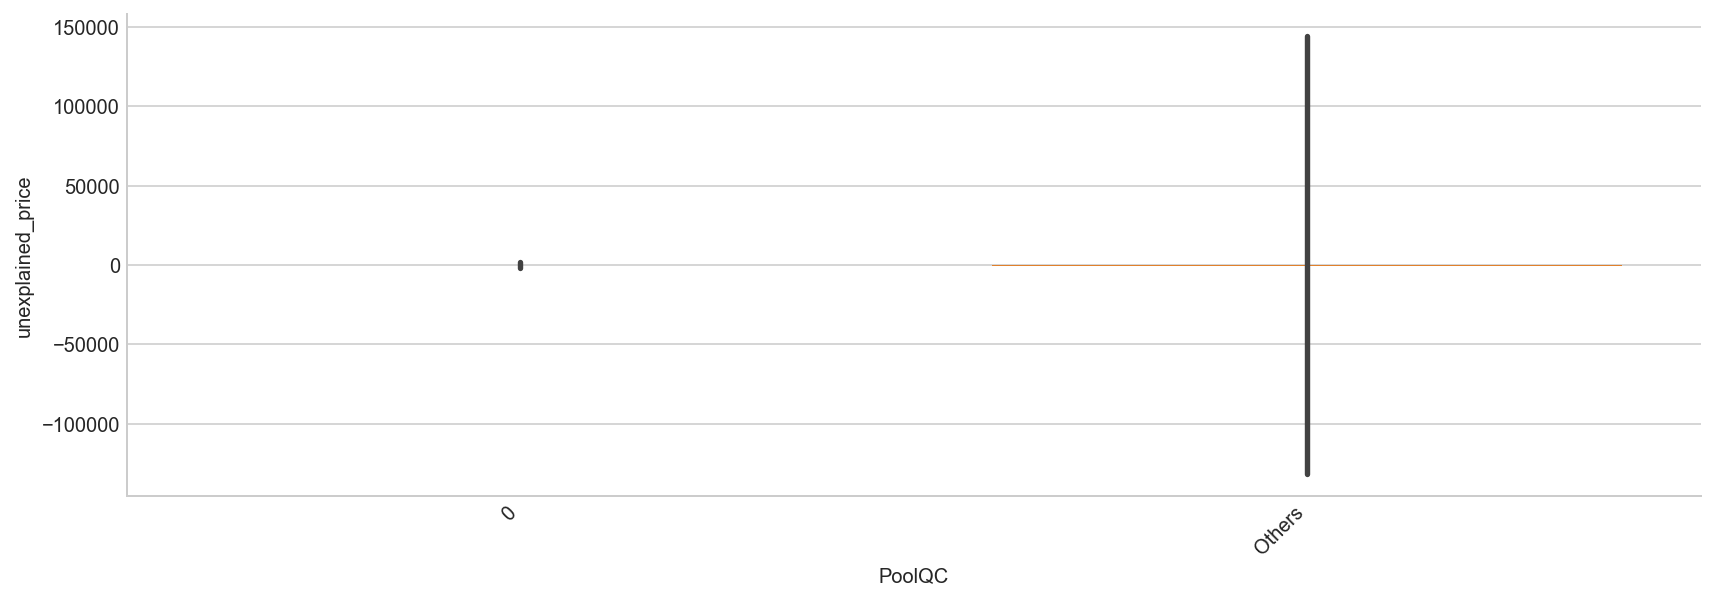

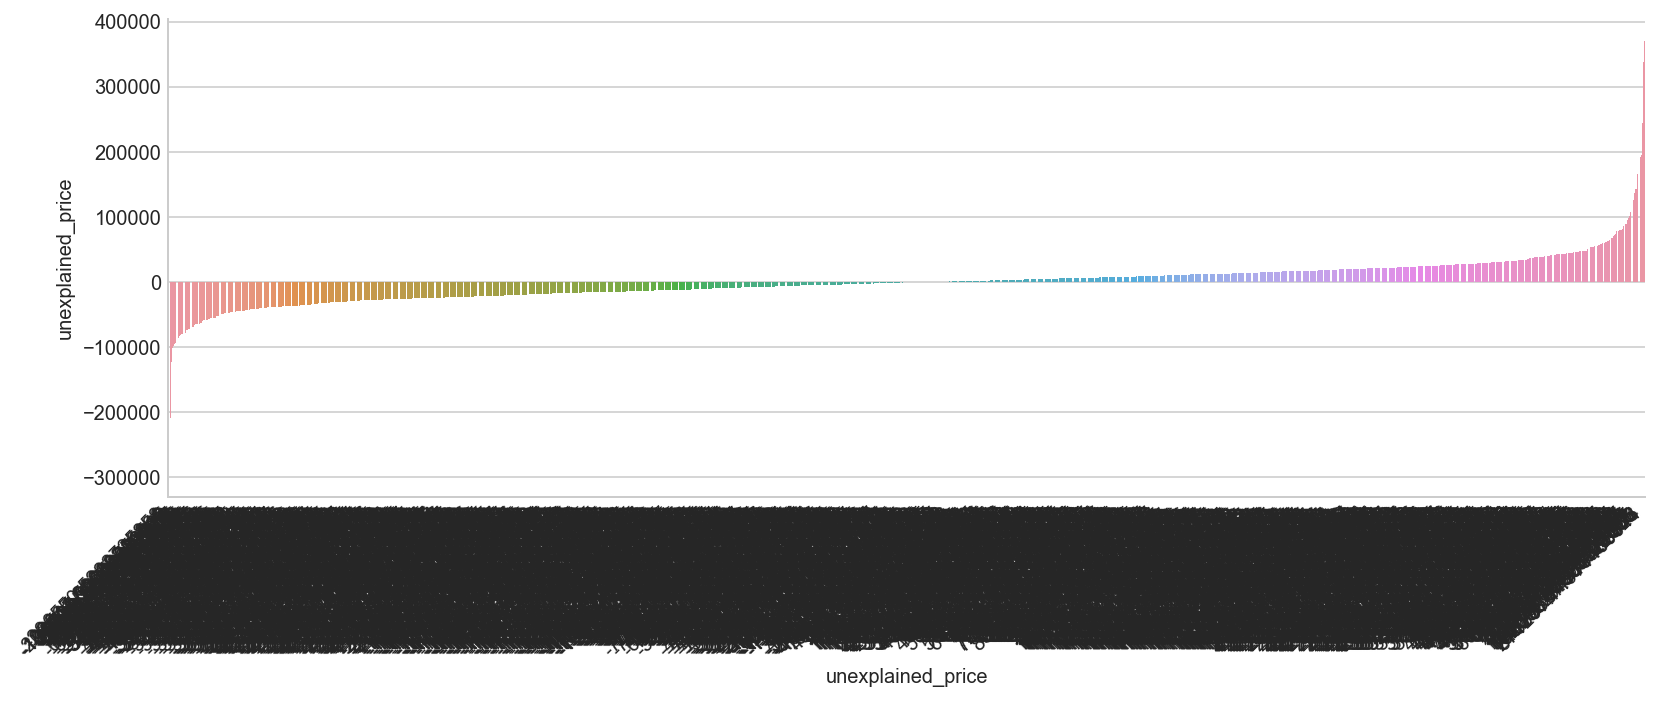

In [55]:
train_etc_obj['unexplained_price'] = train_etc['unexplained_price']
for c in train_etc_obj.columns:
    sns.factorplot(x=c, y='unexplained_price', data=train_etc_obj, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')
#the error term of factor means are much larger

In [56]:
#new dataframe with logged variables without dummies
train_etc_new = pd.concat([train_etc_obj.iloc[:,:-1],train_etc_cont_new], axis=1)

#new dataframe with logged variables with dummies
dummies = pd.get_dummies(train_etc_obj.iloc[:,:-1], drop_first = True)
train_etc_new2 = pd.concat([dummies,train_etc_cont_new], axis=1)

In [57]:
#feature selection
#select training set of features
X_train = train_etc_new2.iloc[:,:-1]
y_train = train_etc_new2['unexplained_price']
#dummy the variables


X_train_ss = StandardScaler().fit_transform(X_train)
#f-test
selector=SelectKBest(score_func=f_classif,k=10) #select k predictors from f-test
selector.fit(X_train_ss,y_train)
list(zip(X_train.columns.values, selector.scores_, selector.pvalues_)) #print variable, F-test value & p-value
X_f_col = np.array(X_train.columns[selector.get_support(True)]) #select chosen column, true gives column index
print 'X_f_col,', X_f_col 
#Recursive feature elimination
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X_train_ss, y_train)
list(zip(X_train.columns.values, selector.support_, selector.ranking_)) #print variables, selection and ranks -> rank 1 is the best
X_RFECV_col = np.array(X_train.columns[selector.support_]) #select chosen column from TRUE
print 'X_RFECV_col:',X_RFECV_col
#lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV decide what alphas to use, just set no. of alphas to test.
optimal_lasso.fit(X_train_ss, y_train)
coefs = list(zip(X_train.columns.values, optimal_lasso.coef_))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
X_lasso_col = coefs[coefs['abs'] != 0].sort_values('abs', ascending=False).head(10)
X_lasso_col = np.array(X_lasso_col.iloc[:,0])
print 'X_lasso_col:', X_RFECV_col
#common features selected for explanation
sel = list(X_RFECV_col)
for e in list(X_f_col):
    sel.append(e)
for e in list(X_lasso_col):
    sel.append(e)
from collections import Counter
sel_fea = pd.DataFrame.from_dict(Counter(sel), orient='index').reset_index()

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


X_f_col, ['GarageCond_Others' 'GarageCond_TA' 'PoolQC_Others' 'OverallQual'
 'OverallCond' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'LowQualFinSF']
X_RFECV_col: ['MasVnrType_None' 'BsmtCond_Others' 'KitchenQual_Gd' 'KitchenQual_TA'
 'OverallQual' 'OverallCond' 'MasVnrArea']
X_lasso_col: ['MasVnrType_None' 'BsmtCond_Others' 'KitchenQual_Gd' 'KitchenQual_TA'
 'OverallQual' 'OverallCond' 'MasVnrArea']


In [58]:
sel_fea.sort_values(0,ascending=False)
#stronger features as follows.

index  0
9         OverallQual  3
12        OverallCond  3
0          MasVnrArea  2
16     KitchenQual_Gd  2
11    BsmtExposure_Gd  1
19         BsmtFinSF2  1
18         BsmtFinSF1  1
17        BsmtQual_Ex  1
15  GarageCond_Others  1
14    MasVnrType_None  1
13   ExterQual_Others  1
10   BsmtFinType1_Unf  1
1           BsmtUnfSF  1
8         BsmtQual_Gd  1
7      KitchenQual_TA  1
6       GarageCond_TA  1
5      FireplaceQu_Gd  1
4     BsmtCond_Others  1
3        LowQualFinSF  1
2      Functional_Typ  1
20      PoolQC_Others  1

In [59]:
train_etc_new2[['MasVnrArea','OverallQual','OverallCond','KitchenQual_Gd','unexplained_price']].corr()
#no strong correlation present among variables except MasVnrArea and OverallQual

MasVnrArea  OverallQual  OverallCond  KitchenQual_Gd  \
MasVnrArea           1.000000     0.415199    -0.171819        0.167034   
OverallQual          0.415199     1.000000    -0.095555        0.411363   
OverallCond         -0.171819    -0.095555     1.000000       -0.022159   
KitchenQual_Gd       0.167034     0.411363    -0.022159        1.000000   
unexplained_price    0.051487     0.224309     0.172776       -0.043393   

                   unexplained_price  
MasVnrArea                  0.051487  
OverallQual                 0.224309  
OverallCond                 0.172776  
KitchenQual_Gd             -0.043393  
unexplained_price           1.000000

In [60]:
#remove MasVnrArea due to collinearity issue leading and stat. insignificant coefficient
#to have better accuracy on kitchen quality's effect on prices, have to understand how overall quality is composed and remove kitchen quality's from the composite.
#select these feature
sel_fea_df = train_etc_new[['OverallQual','OverallCond','KitchenQual','unexplained_price']]
dummies = pd.get_dummies(sel_fea_df['KitchenQual'])
sel_fea_df = sel_fea_df.merge(dummies, left_index = True, right_index = True,how = 'outer')#merge back
sel_fea_df = sel_fea_df.drop('TA', axis=1)
sel_fea_df.head()

model = sm.ols('unexplained_price~OverallQual+OverallCond+Ex+Gd+Others', data=sel_fea_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      unexplained_price   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     36.66
Date:                Mon, 02 Jul 2018   Prob (F-statistic):           3.68e-35
Time:                        20:49:48   Log-Likelihood:                -15039.
No. Observations:                1271   AIC:                         3.009e+04
Df Residuals:                    1265   BIC:                         3.012e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -7.175e+04   7333.910     -9.783      0.000   -8.61e+04   -5.74e+04
OverallQual  6037.1891    928.991      6.499      0.000    4214.655    7859.723
OverallCond  6442.4989    854.720      7.538      0.000    4765.674    8119.324
Ex           1.939e+04   4614.700      4.201      0.000    1.03e+04    2.84e+04
Gd          -7035.4905   2402.912     -2.928      0.003   -1.17e+04   -2321.359
Others       1.171e+04   6008.598      1.949      0.051     -74.272    2.35e+04
==============================================================================
Omnibus:                      430.270   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33379.745
Skew:                           0.636   Prob(JB):                         0.00
Kurtosis:                      28.074   Cond. No.                         70.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. Evaluate the effect in dollars of the renovate-able features. 
        An increase in overall condition rating by 1, improves prices by USD 6,442.
        An increase in overall quality rating by 1, improves prices by USD 6,037.
        The only statisticaly significant renovate-able feature is kitchen quality
        where Excellent kitchen quality increases price by USD 19,390 relative to normal kitchens
        where Good kitchen quality decreases price by USD 7,035 relative to normal kitchens #have to remove kitchen quality from overall quality to further understand true effects.
     
2. How would your company use this second model and its coefficients to determine whether they should buy a property or not?
        To check on the cost of renovation vs price benefit of improving overall condition and quality scales.
        
3. Explain how the company can use the two models you have built to determine if they can make money.
        First check the predicted property price based on the fixed features. If the company is able to purchase at a lower 
        price and sell at a higher predicted price, they can make money. 
        Secondly, if renovation costs < USD 6000 can be used to improve overall condition/quality up a scale of 1, the company should proceed on renovating to earn the margin. Renovating should stop when costs outweigh benefits of improving scale of USD 6000. 
        
4. Investigate how much of the variance in price remaining is explained by these features.
        R square of 0.127. Only 12.7 percent of remaining price variance is explained by these features.
        
5. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
        Only fixed effects should be used. The renovate-able features model is not a good model fit.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [61]:
df['SaleCondition'].value_counts()/len(df)
#Abnormal makes up only 6.7% of the dataframe

Normal     0.825243
Partial    0.084605
Abnorml    0.066574
Others     0.023578
Name: SaleCondition, dtype: float64

In [62]:
#Making new classifier
df['Abnormal'] = (df['SaleCondition'] == 'Abnorml')*1
df = df.drop('SaleCondition', axis=1)

In [63]:
#Classify category and continuous columns
objdf = df.select_dtypes('O')
numdf = df.select_dtypes(include=np.number)

In [64]:
objdf.columns

Index([u'MSSubClass', u'MSZoning', u'Street', u'Alley', u'LotShape',
       u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'ExterQual', u'ExterCond',
       u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinType2', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'KitchenQual', u'Functional',
       u'FireplaceQu', u'GarageType', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence', u'MiscFeature',
       u'MoSold', u'YrSold', u'SaleType'],
      dtype='object')

In [65]:
#drop year built and remodelled since time to 
numdf = numdf.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','GarageYrBlt_tosale','Abnormal'], axis=1)
numdf.columns

Index([u'LotFrontage', u'LotArea', u'OverallQual', u'OverallCond',
       u'MasVnrArea', u'BsmtFinSF1', u'BsmtFinSF2', u'BsmtUnfSF',
       u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'GarageCars', u'GarageArea', u'WoodDeckSF', u'OpenPorchSF',
       u'EnclosedPorch', u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal',
       u'SalePrice', u'YearBuilt_tosale', u'YearRemodAdd_tosale'],
      dtype='object')

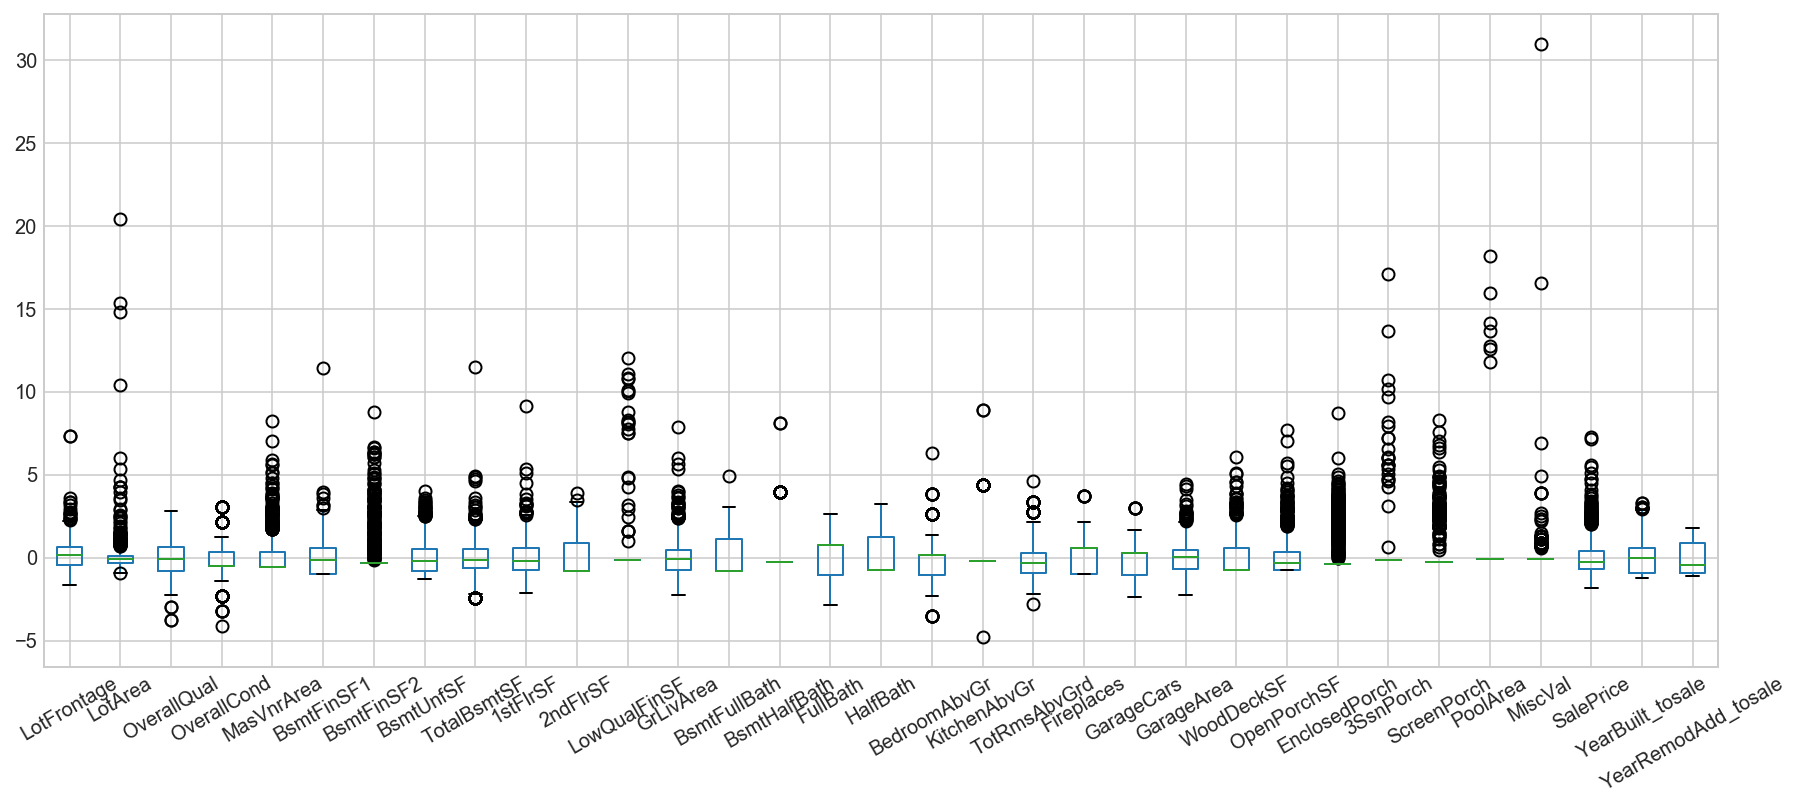

In [66]:
#standardizing continuous variables so as to have a better view of boxplot and distributions
from sklearn.preprocessing import StandardScaler
numdfs = StandardScaler().fit_transform(numdf)
numdfs = pd.DataFrame(numdfs, columns = numdf.columns.values) 

ax = numdfs.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

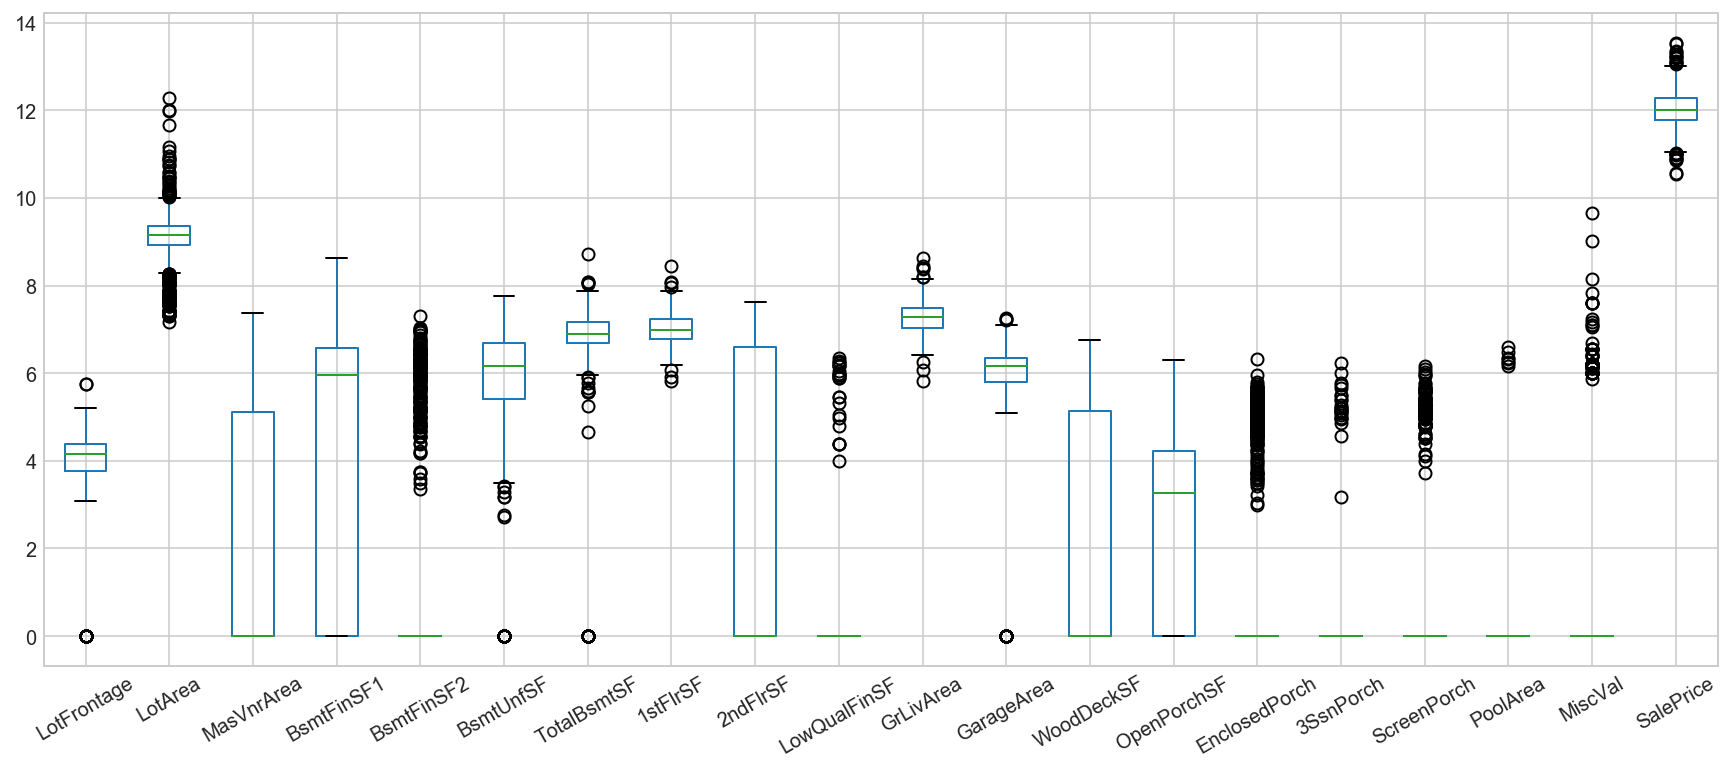

In [67]:
#log selected (area and value) columns of pre-standardized continuous variables, +1 to remove error from np.log(0)
log_numdf = np.log(numdf.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                                 'Fireplaces', 'GarageCars', 'YearBuilt_tosale','YearRemodAdd_tosale', 'OverallQual','OverallCond'], axis=1)
                +1)

ax = log_numdf.boxplot(figsize=(15,6))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [68]:
numdf_ord = numdf[['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                                 'Fireplaces', 'GarageCars', 'YearBuilt_tosale','YearRemodAdd_tosale', 'OverallQual','OverallCond']]

In [69]:
#finished log-normal transformation, create new dataframe of lognormal and ordered continuous variables
numdf_new = pd.concat([log_numdf,numdf_ord], axis=1) 
numdf_new.head()

LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0     4.189655  9.042040    5.283204    6.561031         0.0   5.017280   
1     4.394449  9.169623    0.000000    6.886532         0.0   5.652489   
2     4.234107  9.328212    5.093750    6.188264         0.0   6.075346   
3     4.110874  9.164401    0.000000    5.379897         0.0   6.293419   
4     4.442651  9.565284    5.860786    6.486161         0.0   6.196444   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF     ...       HalfBath  \
0     6.753438  6.753438  6.751101           0.0     ...              1   
1     7.141245  7.141245  0.000000           0.0     ...              0   
2     6.825460  6.825460  6.765039           0.0     ...              1   
3     6.629363  6.869014  6.629363           0.0     ...              0   
4     7.044033  7.044033  6.960348           0.0     ...              1   

   BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageCars  \
0             3             1             8           0           2   
1             3             1             6           1           2   
2             3             1             6           1           2   
3             3             1             7           1           3   
4             4             1             9           1           3   

   YearBuilt_tosale  YearRemodAdd_tosale  OverallQual  OverallCond  
0                 5                    5            7            5  
1                31                   31            6            8  
2                 7                    6            7            5  
3                91                   36            7            5  
4                 8                    8            8            5  

[5 rows x 33 columns]

In [98]:
#get dummies and merge dataset back
dummies = pd.get_dummies(objdf, drop_first = True)
df_new = pd.concat([dummies,numdf_new,df[['YrSold','Abnormal']]],axis=1)

In [99]:
df_new.head()

MSSubClass_50  MSSubClass_60  MSSubClass_120  MSSubClass_Others  \
0              0              1               0                  0   
1              0              0               0                  0   
2              0              1               0                  0   
3              0              0               0                  1   
4              0              1               0                  0   

   MSZoning_RL  MSZoning_RM  Street_Pave  LotShape_Others  LotShape_Reg  \
0            1            0            1                0             1   
1            1            0            1                0             1   
2            1            0            1                0             0   
3            1            0            1                0             0   
4            1            0            1                0             0   

   LandContour_Others    ...     KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0                   0    ...                1             8           0   
1                   0    ...                1             6           1   
2                   0    ...                1             6           1   
3                   0    ...                1             7           1   
4                   0    ...                1             9           1   

   GarageCars  YearBuilt_tosale  YearRemodAdd_tosale  OverallQual  \
0           2                 5                    5            7   
1           2                31                   31            6   
2           2                 7                    6            7   
3           3                91                   36            7   
4           3                 8                    8            8   

   OverallCond  YrSold  Abnormal  
0            5    2008         0  
1            8    2007         0  
2            5    2008         0  
3            5    2006         1  
4            5    2008         0  

[5 rows x 143 columns]

### Solution 1: Sample minority class with replacement to match majority class. This allows the model to learn more from the Abnormal class attributes

In [100]:
df_majority = df_new[df_new.Abnormal==0] #1346 samples
df_minority = df_new[df_new.Abnormal==1] #96 samples

In [104]:
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1346,    # to match majority class
                                 random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts percentage
df_upsampled.Abnormal.value_counts()/len(df_upsampled)

1    0.5
0    0.5
Name: Abnormal, dtype: float64

In [128]:
#train test split
X_train = df_upsampled[df_upsampled['YrSold'] < 2010].iloc[:,:-2]
y_train = df_upsampled[df_upsampled['YrSold'] < 2010].iloc[:,-1]
X_test = df_upsampled[df_upsampled['YrSold'] == 2010].iloc[:,:-2]
y_test = df_upsampled[df_upsampled['YrSold'] == 2010].iloc[:,-1]

#standardize X for lasso and ridge logistic regression
X_train_ss = StandardScaler().fit_transform(X_train)
X_test_ss = StandardScaler().fit_transform(X_test)

In [143]:
#baseline accuracy
y_train.value_counts()/len(y_train)

1    0.504603
0    0.495397
Name: Abnormal, dtype: float64

In [130]:
#logistic regression parameter selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}
lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)
lr_gridsearch.fit(X_train_ss, y_train)
#output
print lr_gridsearch.best_score_
print lr_gridsearch.best_params_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


0.905020920502092
{'penalty': 'l1', 'C': 1.0, 'solver': 'liblinear'}


In [133]:
#predict score
best_lr = lr_gridsearch.best_estimator_
best_lr.score(X_test_ss, y_test)
#overfitting has occurred. High training score but low test scores. Test score is worse that baseline score of 53%.

0.5165562913907285

In [149]:
#get top performing coefficients
coefs_vars = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'variable':X_train.columns,
        'abscoef':np.abs(best_lr.coef_[0])
    })
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars.head()

abscoef      coef         variable
106  4.671474  4.671474  SaleType_Others
127  3.015934 -3.015934        SalePrice
111  2.611997  2.611997       BsmtFinSF1
107  2.371366  2.371366      SaleType_WD
112  2.175706  2.175706       BsmtFinSF2

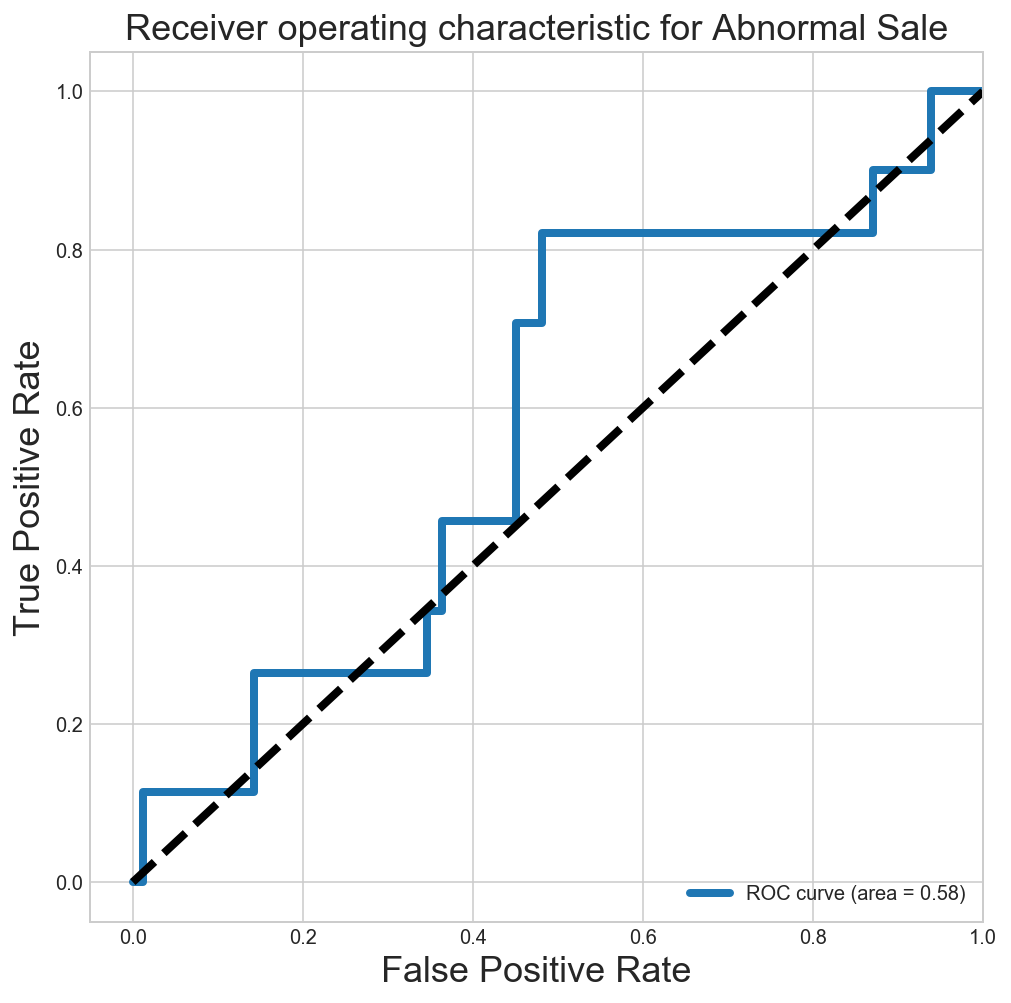

auc: 0.578615520282187


In [141]:
#predict probability
Y_pp = pd.DataFrame(best_lr.predict_proba(X_test_ss), columns=['class_0_pp','class_1_pp'])
#roc, auc for model performance measurement against random forest classifier later
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (abnormal sale).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Abnormal Sale', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print 'auc:',roc_auc

### Solution 2: Use Random Forest Classifier because tree-based hierarchical structure allows good learning of signals from both classes, even on unbalanced datasets.

In [164]:
#get unbalanced dataset train-test split
X_train_unbal = df_new[df_new['YrSold'] < 2010].iloc[:,:-2]
y_train_unbal = df_new[df_new['YrSold'] < 2010].iloc[:,-1]
X_test_unbal = df_new[df_new['YrSold'] == 2010].iloc[:,:-2]
y_test_unbal = df_new[df_new['YrSold'] == 2010].iloc[:,-1]

#standardize X for lasso and ridge logistic regression
X_train_unbal_ss = StandardScaler().fit_transform(X_train_unbal)
X_test_unbal_ss = StandardScaler().fit_transform(X_test_unbal)

In [165]:
#baseline accuracy
y_train_unbal.value_counts()/len(y_train_unbal)

0    0.93155
1    0.06845
Name: Abnormal, dtype: float64

In [166]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'n_estimators':[5,15,20],
    'criterion':["gini", "entropy"],
    'max_features':['auto','sqrt'],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
}

clf = RandomForestClassifier()
clf_gridsearch = GridSearchCV(clf, param_grid, cv=5, verbose=1)
clf_gridsearch.fit(X_train_unbal_ss, y_train_unbal)
#output
print clf_gridsearch.best_score_
print clf_gridsearch.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
0.9346970889063729
{'max_features': 'auto', 'min_samples_split': 3, 'n_estimators': 5, 'criterion': 'gini', 'min_samples_leaf': 3}


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   45.9s finished


In [167]:
#predict score
best_clf = clf_gridsearch.best_estimator_
best_clf.score(X_test_unbal_ss, y_test_unbal)

0.9415204678362573

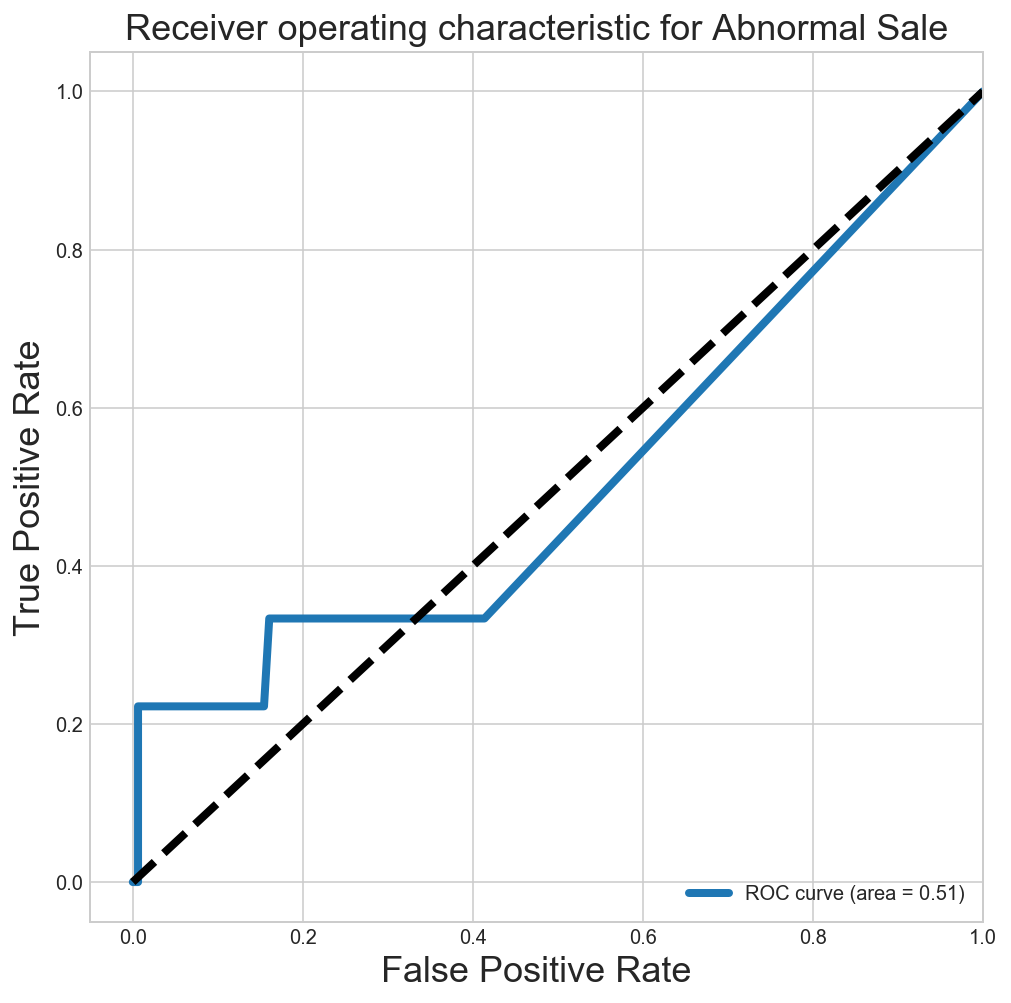

auc: 0.5099451303155006


In [168]:
#predict probability
Y_pp = pd.DataFrame(best_clf.predict_proba(X_test_unbal_ss), columns=['class_0_pp','class_1_pp'])
#roc, auc for model for common performance measurement
from sklearn.metrics import roc_curve, auc
# For class 1, find the area under the curve.
fpr, tpr, _ = roc_curve(y_test_unbal, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (abnormal sale).
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for Abnormal Sale', fontsize=18)
plt.legend(loc="lower right")
plt.show()
print 'auc:',roc_auc

### Solution 2 did not succeed in performing on unbalanced dataset. Solution 2 AUC: 0.51 < Solution 1 AUC: 0.58.
##### A larger sample of minority class for model learning seems to provide a better solution.